In [7]:
import os 
from scipy.signal.windows import hann
import pandas as pd 
import numpy as np
from numpy.fft import fft
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch 
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18
from torch import nn, optim
import seaborn as sns
import timm
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import timm
import torch, gc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler


# Feature Extraction

## Feature- del STFT 

In [8]:
df_aug = pd.read_pickle('data_augmented.pkl')

In [9]:
df_aug

,file_name,sensor,segment_id,signal,fault_class,fault_class_id,relative_path,folder,sampling_freq,original_fs,signal_length,augmentation
0,290_0.mat,DE,0-60000,"[-0.0028426147704590818, 0.06091317365269461, ...",B,2,12k_Fan_End_Bearing_Fault_Data/B/021/290_0.mat,12k_Fan_End_Bearing_Fault_Data,12000,12000,60000,NaN
1,290_0.mat,DE,12000-72000,"[-0.07553233532934131, 0.0787810379241517, 0.0...",B,2,12k_Fan_End_Bearing_Fault_Data/B/021/290_0.mat,12k_Fan_End_Bearing_Fault_Data,12000,12000,60000,NaN
2,290_0.mat,DE,24000-84000,"[0.006091317365269461, 0.01258872255489022, 0....",B,2,12k_Fan_End_Bearing_Fault_Data/B/021/290_0.mat,12k_Fan_End_Bearing_Fault_Data,12000,12000,60000,NaN
3,290_0.mat,DE,36000-96000,"[-0.13482115768463074, -0.05604011976047904, 0...",B,2,12k_Fan_End_Bearing_Fault_Data/B/021/290_0.mat,12k_Fan_End_Bearing_Fault_Data,12000,12000,60000,NaN
4,290_0.mat,DE,48000-108000,"[-0.11126806387225549, -0.17786646706586826, -...",B,2,12k_Fan_End_Bearing_Fault_Data/B/021/290_0.mat,12k_Fan_End_Bearing_Fault_Data,12000,12000,60000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12475,100_Normal_3.mat,FE,60000-120000_gaussian_noise,"[0.05828176200225435, -0.014997261677986862, -...",normal,9,Normal/100_Normal_3.mat,Normal,12000,48000,60000,gaussian_noise
12476,100_Normal_3.mat,FE,60000-120000_masking,"[0.052584165933847016, -0.010331182710528452, ...",normal,9,Normal/100_Normal_3.mat,Normal,12000,48000,60000,masking
12477,100_Normal_3.mat,FE,60000-120000_translated,"[0.14511389283732098, 0.1242955098091302, 0.07...",normal,9,Normal/100_Normal_3.mat,Normal,12000,48000,60000,translated
12478,100_Normal_3.mat,FE,60000-120000_amp_shifted,"[0.07980996912782151, 0.016894620483446046, -0...",normal,9,Normal/100_Normal_3.mat,Normal,12000,48000,60000,amp_shifted


In [10]:
#Spectrogram (we are doing the point 3 in here)

# STFT Parameters
fs = 12000
fi = 100
Nseg1 = int(fs / fi)
Nseg2 = Nseg1 // 2
Nseg3 = Nseg1 // 4
Nfft = 256

# Final tensor shape
target_shape = (128, 64, 3)

In [11]:

def compute_stft(x, Nseg, Nfft):
    overlap_ratio = 0.9
    Nover = int(Nseg * overlap_ratio)
    Nstep = Nseg - Nover
    Nframe = (len(x) - Nseg) // Nstep
    X = np.zeros((Nframe, Nfft))
    window = hann(Nseg)
    for n in range(Nframe):
        start = n * Nstep
        end = start + Nseg
        segment = x[start:end] * window
        spectrum = np.abs(fft(segment, Nfft))
        X[n, :] = spectrum
    return X.T


def normalize_tensor(tensor):
    tensor = np.abs(tensor)  # Ensure all values are non-negative
    tensor = np.log1p(tensor)
    return tensor / np.max(tensor)

def fix_tensor_shape(tensor, target_shape):
    tensor = tensor[:target_shape[0], :target_shape[1], :target_shape[2]]
    padded = np.zeros(target_shape, dtype=np.float32)
    padded[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
    return padded


In [12]:
processed_data = []
for index, row in df_aug.iterrows():
                signal = row['signal']
                #print(signal)
                label = row['fault_class_id']
        
                X1 = compute_stft(signal, Nseg1, Nseg1)
                X2 = compute_stft(signal, Nseg2, Nseg2)
                X3 = compute_stft(signal, Nseg3, Nseg3)

                min_shape = (
                    min(X1.shape[0], X2.shape[0], X3.shape[0]),
                    min(X1.shape[1], X2.shape[1], X3.shape[1])
                )

                X1 = X1[:min_shape[0], :min_shape[1]]
                X2 = X2[:min_shape[0], :min_shape[1]]
                X3 = X3[:min_shape[0], :min_shape[1]]

                D12 = X1 - X2
                D13 = X1 - X3
                D23 = X2 - X3

                raw_tensor = np.stack([D12[:128], D13[:128], D23[:128]], axis=-1)
                fixed = fix_tensor_shape(normalize_tensor(raw_tensor), target_shape)

                processed_data.append({'tensor': fixed, 'label': label})
                

### Train-Test Split and DataLoader 

In [13]:
#  STEP 3: Dataset, Dataloader, and Transforms
class DeltaSTFTDataset(Dataset):
    def __init__(self, tensors, labels, transform=None):
        self.data = tensors
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.fromarray((self.data[idx] * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [14]:

# -------------------------------
# STEP 3: Transform (for CNNs/ViT)
# -------------------------------
# Model training:  Deit_tiny_patch16_224


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize as needed: 224x224 for ResNet-50/ViT
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
#                          std=[0.229, 0.224, 0.225])
# ])


# #ResNet 18
# transform = transforms.Compose([
#     transforms.Resize((128, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])



#Inceptionnet resnet v2
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Model training:  Deit_tiny_patch16_224




In [15]:
# -------------------------------
# STEP 4: Train/Test Split (80/20)
# -------------------------------

X = [item['tensor'] for item in processed_data]
y = [item['label'] for item in processed_data]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



In [16]:
# -------------------------------
# STEP 5: 10-Fold CV on 80% Train
# -------------------------------

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights = [class_weights[label] for label in y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    
    # Dataset & Loaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # --- Insert your model, optimizer, criterion, and training logic here ---
    # e.g., train_model(model, train_loader, val_loader, ...)
    

# -------------------------------
# STEP 6: Final Test Loader (20%)
# -------------------------------

test_dataset = DeltaSTFTDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# --- Use test_loader for final evaluation after best model selection ---



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

--- Fold 6 ---

--- Fold 7 ---

--- Fold 8 ---

--- Fold 9 ---

--- Fold 10 ---


In [17]:

# Count class occurrences
train_counts = Counter(y_trainval)
test_counts = Counter(y_test)

# Mapping class ID to (Fault Type, Diameter)
fault_map = {
    0: ("Ball Fault", "0.007\""),
    1: ("Ball Fault", "0.014\""),
    2: ("Ball Fault", "0.021\""),
    3: ("Inner Race Fault", "0.007\""),
    4: ("Inner Race Fault", "0.014\""),
    5: ("Inner Race Fault", "0.021\""),
    6: ("Outer Race Fault", "0.007\""),
    7: ("Outer Race Fault", "0.014\""),
    8: ("Outer Race Fault", "0.021\""),
    9: ("Normal (Healthy)", "--")
}

# Fill in the table data
rows = []
for class_id in range(10):
    fault_type, diameter = fault_map[class_id]
    train_sample_count = train_counts.get(class_id, 0)
    test_sample_count = test_counts.get(class_id, 0)
    rows.append([class_id, fault_type, diameter, train_sample_count, test_sample_count])

# Add total row
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
rows.append(["", "Total", "--", total_train, total_test])

# Display as DataFrame 
df_class_dist = pd.DataFrame(rows, columns=[
    "Class ID", "Fault Type", "Diameter (in)", "Train samples", "Test samples"
])

print(df_class_dist.to_string(index=False))


Class ID       Fault Type Diameter (in)  Train samples  Test samples
       0       Ball Fault        0.007"            874           218
       1       Ball Fault        0.014"            874           218
       2       Ball Fault        0.021"            874           218
       3 Inner Race Fault        0.007"            873           219
       4 Inner Race Fault        0.014"            835           209
       5 Inner Race Fault        0.021"            874           218
       6 Outer Race Fault        0.007"           2256           564
       7 Outer Race Fault        0.014"            432           108
       8 Outer Race Fault        0.021"           1910           478
       9 Normal (Healthy)            --            182            46
                    Total            --           9984          2496


# Experiment 1: Baseline Models

## ResNet- 18- 128 * 64

In [16]:

def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model

In [19]:
# STEP 4: Define Model (ResNet18 without Dropout)
num_classes = 10

def get_resnet18_for_spectrogram(num_classes):
    model = models.resnet18(pretrained=True)
    
    # Modify first conv layer to accept 3-channel spectrogram input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove maxpool to preserve spatial resolution
    model.maxpool = nn.Identity()
    
    # Replace final classification layer (no dropout)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [],  # overall F1
        'val_classwise_f1': []  # per-class F1 scores
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == y_batch).item()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)

        # Per-class F1 score
        class_f1 = f1_score(all_labels, all_preds, average=None)  # shape: [num_classes]
        macro_f1 = f1_score(all_labels, all_preds, average='macro')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10
n_splits = 10

cv_history = {
    'train_acc': [],
    'val_acc': [],
    'train_loss': [],
    'val_loss': [],
    'val_f1_macro': [],
    'val_classwise_f1': []
}

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)



In [31]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Class weighting and sampling
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Datasets and loaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # Model setup
    model = get_resnet18_for_spectrogram(num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Train
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

    # Save final metrics for this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])  # numpy array shape: [num_classes]

    # Optional: Save model
    torch.save(model.state_dict(), f"resnet18_fold{fold+1}.pth")


/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.70it/s]


Epoch 1: Train Loss=0.5472, Val Loss=0.3566, Train Acc=83.96%, Val Acc=88.69%, Val F1-Macro=0.8954


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.77it/s]


Epoch 2: Train Loss=0.0921, Val Loss=0.1362, Train Acc=97.66%, Val Acc=96.10%, Val F1-Macro=0.9687


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.75it/s]


Epoch 3: Train Loss=0.0652, Val Loss=0.1173, Train Acc=98.30%, Val Acc=96.10%, Val F1-Macro=0.9578


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.79it/s]


Epoch 4: Train Loss=0.0345, Val Loss=0.0623, Train Acc=99.24%, Val Acc=98.30%, Val F1-Macro=0.9819


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.67it/s]


Epoch 5: Train Loss=0.0321, Val Loss=0.0334, Train Acc=99.24%, Val Acc=99.30%, Val F1-Macro=0.9911


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.98it/s]


Epoch 6: Train Loss=0.0240, Val Loss=0.0692, Train Acc=99.34%, Val Acc=98.00%, Val F1-Macro=0.9782


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.69it/s]


Epoch 7: Train Loss=0.0105, Val Loss=0.0348, Train Acc=99.87%, Val Acc=98.60%, Val F1-Macro=0.9834


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.64it/s]


Epoch 8: Train Loss=0.0130, Val Loss=0.0473, Train Acc=99.73%, Val Acc=98.80%, Val F1-Macro=0.9873


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.02it/s]


Epoch 9: Train Loss=0.0534, Val Loss=0.0754, Train Acc=98.52%, Val Acc=97.50%, Val F1-Macro=0.9760


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.95it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0174, Val Loss=0.0299, Train Acc=99.63%, Val Acc=99.10%, Val F1-Macro=0.9899

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.96it/s]


Epoch 1: Train Loss=0.5656, Val Loss=0.1939, Train Acc=83.23%, Val Acc=94.89%, Val F1-Macro=0.9558


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.69it/s]


Epoch 2: Train Loss=0.1026, Val Loss=0.1226, Train Acc=97.41%, Val Acc=96.80%, Val F1-Macro=0.9714


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.60it/s]


Epoch 3: Train Loss=0.0567, Val Loss=0.0759, Train Acc=98.54%, Val Acc=97.40%, Val F1-Macro=0.9766


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.81it/s]


Epoch 4: Train Loss=0.0263, Val Loss=0.0809, Train Acc=99.40%, Val Acc=97.80%, Val F1-Macro=0.9780


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.93it/s]


Epoch 5: Train Loss=0.0428, Val Loss=0.0536, Train Acc=98.79%, Val Acc=98.10%, Val F1-Macro=0.9806


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.92it/s]


Epoch 6: Train Loss=0.0316, Val Loss=0.0387, Train Acc=99.14%, Val Acc=98.60%, Val F1-Macro=0.9876


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


Epoch 7: Train Loss=0.0207, Val Loss=0.0294, Train Acc=99.53%, Val Acc=98.90%, Val F1-Macro=0.9876


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.83it/s]


Epoch 8: Train Loss=0.0147, Val Loss=0.0209, Train Acc=99.70%, Val Acc=99.30%, Val F1-Macro=0.9938


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.62it/s]


Epoch 9: Train Loss=0.0156, Val Loss=0.0414, Train Acc=99.67%, Val Acc=98.90%, Val F1-Macro=0.9882


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.88it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0505, Val Loss=0.0683, Train Acc=98.55%, Val Acc=98.10%, Val F1-Macro=0.9827

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


Epoch 1: Train Loss=0.5490, Val Loss=0.1931, Train Acc=84.17%, Val Acc=94.79%, Val F1-Macro=0.9478


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.36it/s]


Epoch 2: Train Loss=0.1083, Val Loss=0.1214, Train Acc=97.28%, Val Acc=96.40%, Val F1-Macro=0.9668


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.79it/s]


Epoch 3: Train Loss=0.0528, Val Loss=0.1003, Train Acc=98.62%, Val Acc=96.60%, Val F1-Macro=0.9709


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.13it/s]


Epoch 4: Train Loss=0.0291, Val Loss=0.0996, Train Acc=99.48%, Val Acc=96.60%, Val F1-Macro=0.9703


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.85it/s]


Epoch 5: Train Loss=0.0339, Val Loss=0.0964, Train Acc=99.10%, Val Acc=97.00%, Val F1-Macro=0.9691


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.72it/s]


Epoch 6: Train Loss=0.0316, Val Loss=0.0498, Train Acc=99.19%, Val Acc=98.70%, Val F1-Macro=0.9882


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.66it/s]


Epoch 7: Train Loss=0.0257, Val Loss=0.0884, Train Acc=99.40%, Val Acc=97.40%, Val F1-Macro=0.9721


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.74it/s]


Epoch 8: Train Loss=0.0095, Val Loss=0.0221, Train Acc=99.78%, Val Acc=99.40%, Val F1-Macro=0.9958


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.00it/s]


Epoch 9: Train Loss=0.0042, Val Loss=0.0162, Train Acc=99.94%, Val Acc=99.50%, Val F1-Macro=0.9959


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.72it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0123, Val Loss=0.3383, Train Acc=99.68%, Val Acc=89.79%, Val F1-Macro=0.9036

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.84it/s]


Epoch 1: Train Loss=0.5267, Val Loss=0.3271, Train Acc=84.99%, Val Acc=88.79%, Val F1-Macro=0.9006


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.71it/s]


Epoch 2: Train Loss=0.1051, Val Loss=0.1865, Train Acc=97.24%, Val Acc=93.19%, Val F1-Macro=0.9410


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.93it/s]


Epoch 3: Train Loss=0.0556, Val Loss=0.1407, Train Acc=98.58%, Val Acc=95.30%, Val F1-Macro=0.9596


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


Epoch 4: Train Loss=0.0473, Val Loss=0.0954, Train Acc=98.75%, Val Acc=96.90%, Val F1-Macro=0.9664


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.05it/s]


Epoch 5: Train Loss=0.0368, Val Loss=0.1387, Train Acc=99.04%, Val Acc=95.90%, Val F1-Macro=0.9550


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


Epoch 6: Train Loss=0.0217, Val Loss=0.0650, Train Acc=99.54%, Val Acc=98.10%, Val F1-Macro=0.9808


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.77it/s]


Epoch 7: Train Loss=0.0237, Val Loss=0.1003, Train Acc=99.34%, Val Acc=97.20%, Val F1-Macro=0.9725


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.89it/s]


Epoch 8: Train Loss=0.0374, Val Loss=0.0642, Train Acc=98.96%, Val Acc=97.90%, Val F1-Macro=0.9728


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.72it/s]


Epoch 9: Train Loss=0.0109, Val Loss=0.0588, Train Acc=99.79%, Val Acc=98.00%, Val F1-Macro=0.9716


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.90it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0211, Val Loss=0.0460, Train Acc=99.42%, Val Acc=98.40%, Val F1-Macro=0.9852

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.67it/s]


Epoch 1: Train Loss=0.5604, Val Loss=0.2547, Train Acc=83.45%, Val Acc=91.48%, Val F1-Macro=0.9196


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.65it/s]


Epoch 2: Train Loss=0.1044, Val Loss=0.1622, Train Acc=97.41%, Val Acc=94.99%, Val F1-Macro=0.9452


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.51it/s]


Epoch 3: Train Loss=0.0525, Val Loss=0.2037, Train Acc=98.80%, Val Acc=93.29%, Val F1-Macro=0.9313


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.19it/s]


Epoch 4: Train Loss=0.0483, Val Loss=0.1403, Train Acc=98.86%, Val Acc=95.59%, Val F1-Macro=0.9451


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.82it/s]


Epoch 5: Train Loss=0.0324, Val Loss=0.0480, Train Acc=99.18%, Val Acc=99.00%, Val F1-Macro=0.9839


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.88it/s]


Epoch 6: Train Loss=0.0241, Val Loss=0.0839, Train Acc=99.45%, Val Acc=97.80%, Val F1-Macro=0.9762


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.93it/s]


Epoch 7: Train Loss=0.0279, Val Loss=0.0436, Train Acc=99.25%, Val Acc=98.70%, Val F1-Macro=0.9873


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.59it/s]


Epoch 8: Train Loss=0.0147, Val Loss=0.0543, Train Acc=99.71%, Val Acc=97.60%, Val F1-Macro=0.9783


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.68it/s]


Epoch 9: Train Loss=0.0095, Val Loss=0.0494, Train Acc=99.82%, Val Acc=98.40%, Val F1-Macro=0.9824


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.85it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0303, Val Loss=0.1600, Train Acc=99.22%, Val Acc=94.79%, Val F1-Macro=0.9591

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.67it/s]


Epoch 1: Train Loss=0.5536, Val Loss=0.2600, Train Acc=83.59%, Val Acc=92.59%, Val F1-Macro=0.9249


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.65it/s]


Epoch 2: Train Loss=0.1088, Val Loss=0.1313, Train Acc=97.37%, Val Acc=96.09%, Val F1-Macro=0.9624


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.76it/s]


Epoch 3: Train Loss=0.0441, Val Loss=0.1639, Train Acc=99.00%, Val Acc=93.79%, Val F1-Macro=0.9255


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.70it/s]


Epoch 4: Train Loss=0.0329, Val Loss=0.1004, Train Acc=99.34%, Val Acc=96.49%, Val F1-Macro=0.9562


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.20it/s]


Epoch 5: Train Loss=0.0357, Val Loss=0.1472, Train Acc=99.03%, Val Acc=94.69%, Val F1-Macro=0.9516


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.70it/s]


Epoch 6: Train Loss=0.0377, Val Loss=0.0727, Train Acc=99.04%, Val Acc=97.80%, Val F1-Macro=0.9764


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.49it/s]


Epoch 7: Train Loss=0.0186, Val Loss=0.0365, Train Acc=99.62%, Val Acc=98.60%, Val F1-Macro=0.9844


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.85it/s]


Epoch 8: Train Loss=0.0202, Val Loss=0.0456, Train Acc=99.55%, Val Acc=98.50%, Val F1-Macro=0.9835


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.72it/s]


Epoch 9: Train Loss=0.0217, Val Loss=0.3917, Train Acc=99.43%, Val Acc=88.68%, Val F1-Macro=0.8939


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.61it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0239, Val Loss=0.0591, Train Acc=99.40%, Val Acc=98.00%, Val F1-Macro=0.9802

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.81it/s]


Epoch 1: Train Loss=0.5865, Val Loss=0.3147, Train Acc=82.19%, Val Acc=89.98%, Val F1-Macro=0.8895


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.58it/s]


Epoch 2: Train Loss=0.1052, Val Loss=0.1173, Train Acc=97.36%, Val Acc=96.79%, Val F1-Macro=0.9675


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.82it/s]


Epoch 3: Train Loss=0.0578, Val Loss=0.0515, Train Acc=98.61%, Val Acc=98.80%, Val F1-Macro=0.9893


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.74it/s]


Epoch 4: Train Loss=0.0311, Val Loss=0.0553, Train Acc=99.25%, Val Acc=98.50%, Val F1-Macro=0.9875


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.78it/s]


Epoch 5: Train Loss=0.0332, Val Loss=0.0898, Train Acc=99.21%, Val Acc=97.19%, Val F1-Macro=0.9725


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.63it/s]


Epoch 6: Train Loss=0.0286, Val Loss=0.0514, Train Acc=99.30%, Val Acc=98.30%, Val F1-Macro=0.9794


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.69it/s]


Epoch 7: Train Loss=0.0186, Val Loss=0.0313, Train Acc=99.62%, Val Acc=99.20%, Val F1-Macro=0.9932


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.87it/s]


Epoch 8: Train Loss=0.0191, Val Loss=0.1440, Train Acc=99.53%, Val Acc=95.89%, Val F1-Macro=0.9587


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.89it/s]


Epoch 9: Train Loss=0.0187, Val Loss=0.0438, Train Acc=99.59%, Val Acc=98.40%, Val F1-Macro=0.9856


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.84it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0284, Val Loss=0.0535, Train Acc=99.30%, Val Acc=98.10%, Val F1-Macro=0.9823

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.77it/s]


Epoch 1: Train Loss=0.5730, Val Loss=0.3406, Train Acc=82.92%, Val Acc=88.38%, Val F1-Macro=0.9031


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.82it/s]


Epoch 2: Train Loss=0.1042, Val Loss=0.1092, Train Acc=97.50%, Val Acc=97.09%, Val F1-Macro=0.9723


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.66it/s]


Epoch 3: Train Loss=0.0652, Val Loss=0.1919, Train Acc=98.33%, Val Acc=94.29%, Val F1-Macro=0.9473


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.72it/s]


Epoch 4: Train Loss=0.0461, Val Loss=0.0897, Train Acc=98.79%, Val Acc=96.79%, Val F1-Macro=0.9739


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.15it/s]


Epoch 5: Train Loss=0.0265, Val Loss=0.0762, Train Acc=99.48%, Val Acc=98.10%, Val F1-Macro=0.9825


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.85it/s]


Epoch 6: Train Loss=0.0158, Val Loss=0.0406, Train Acc=99.67%, Val Acc=98.90%, Val F1-Macro=0.9905


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.54it/s]


Epoch 7: Train Loss=0.0280, Val Loss=0.2029, Train Acc=99.21%, Val Acc=93.89%, Val F1-Macro=0.9408


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.68it/s]


Epoch 8: Train Loss=0.0204, Val Loss=0.1389, Train Acc=99.45%, Val Acc=95.79%, Val F1-Macro=0.9614


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.96it/s]


Epoch 9: Train Loss=0.0377, Val Loss=0.0722, Train Acc=98.98%, Val Acc=97.19%, Val F1-Macro=0.9709


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.78it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0113, Val Loss=0.0684, Train Acc=99.72%, Val Acc=98.00%, Val F1-Macro=0.9825

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.75it/s]


Epoch 1: Train Loss=0.5660, Val Loss=0.3190, Train Acc=83.33%, Val Acc=89.68%, Val F1-Macro=0.8984


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.90it/s]


Epoch 2: Train Loss=0.1028, Val Loss=0.1898, Train Acc=97.53%, Val Acc=94.09%, Val F1-Macro=0.9416


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.36it/s]


Epoch 3: Train Loss=0.0486, Val Loss=0.0920, Train Acc=98.80%, Val Acc=96.89%, Val F1-Macro=0.9656


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.70it/s]


Epoch 4: Train Loss=0.0298, Val Loss=0.0844, Train Acc=99.38%, Val Acc=97.09%, Val F1-Macro=0.9731


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.92it/s]


Epoch 5: Train Loss=0.0376, Val Loss=0.0800, Train Acc=98.97%, Val Acc=97.19%, Val F1-Macro=0.9720


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.54it/s]


Epoch 6: Train Loss=0.0237, Val Loss=0.0337, Train Acc=99.51%, Val Acc=99.10%, Val F1-Macro=0.9863


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 26.03it/s]


Epoch 7: Train Loss=0.0167, Val Loss=0.1654, Train Acc=99.63%, Val Acc=94.19%, Val F1-Macro=0.9506


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.75it/s]


Epoch 8: Train Loss=0.0139, Val Loss=0.0629, Train Acc=99.67%, Val Acc=98.40%, Val F1-Macro=0.9805


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.83it/s]


Epoch 9: Train Loss=0.0347, Val Loss=0.0685, Train Acc=99.09%, Val Acc=97.29%, Val F1-Macro=0.9744


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.69it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0074, Val Loss=0.0258, Train Acc=99.86%, Val Acc=99.20%, Val F1-Macro=0.9925

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.76it/s]


Epoch 1: Train Loss=0.5727, Val Loss=0.1926, Train Acc=82.98%, Val Acc=94.89%, Val F1-Macro=0.9543


Epoch 2/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.83it/s]


Epoch 2: Train Loss=0.1050, Val Loss=0.1980, Train Acc=97.42%, Val Acc=93.79%, Val F1-Macro=0.9512


Epoch 3/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.86it/s]


Epoch 3: Train Loss=0.0615, Val Loss=0.0931, Train Acc=98.30%, Val Acc=97.19%, Val F1-Macro=0.9747


Epoch 4/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.71it/s]


Epoch 4: Train Loss=0.0355, Val Loss=0.0675, Train Acc=99.17%, Val Acc=98.20%, Val F1-Macro=0.9806


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.90it/s]


Epoch 5: Train Loss=0.0227, Val Loss=0.2115, Train Acc=99.45%, Val Acc=94.79%, Val F1-Macro=0.9563


Epoch 6/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.80it/s]


Epoch 6: Train Loss=0.0267, Val Loss=0.0642, Train Acc=99.33%, Val Acc=98.00%, Val F1-Macro=0.9808


Epoch 7/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.81it/s]


Epoch 7: Train Loss=0.0453, Val Loss=0.1486, Train Acc=98.80%, Val Acc=94.39%, Val F1-Macro=0.9469


Epoch 8/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.95it/s]


Epoch 8: Train Loss=0.0163, Val Loss=0.0376, Train Acc=99.60%, Val Acc=99.10%, Val F1-Macro=0.9918


Epoch 9/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.60it/s]


Epoch 9: Train Loss=0.0130, Val Loss=0.0498, Train Acc=99.66%, Val Acc=98.70%, Val F1-Macro=0.9882


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 25.90it/s]

Epoch 10: Train Loss=0.0108, Val Loss=0.0196, Train Acc=99.77%, Val Acc=99.50%, Val F1-Macro=0.9959


In [32]:
test_dataset = DeltaSTFTDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# You can now load the best model and evaluate here.


In [33]:
print("\n=== 10-Fold CV Summary ===")
for metric in cv_history:
    values = cv_history[metric]
    print(f"{metric}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}")



=== 10-Fold CV Summary ===
train_acc: Mean = 99.45, Std = 0.36
val_acc: Mean = 97.30, Std = 2.79
train_loss: Mean = 0.02, Std = 0.01
val_loss: Mean = 0.09, Std = 0.09
val_f1_macro: Mean = 0.98, Std = 0.03
val_classwise_f1: Mean = 0.98, Std = 0.05


In [36]:

# Convert list of per-class F1s into a DataFrame
f1_df = pd.DataFrame(cv_history['val_classwise_f1'])  # Shape: (n_folds, num_classes)
f1_df.columns = [f'Class_{i}' for i in range(f1_df.shape[1])]

# Print detailed statistics for each class
summary_df = f1_df.describe().T[['mean', 'std']].round(4)
summary_df.columns = ['Mean F1', 'Std F1']

print("\n=== Per-Class F1 Score Summary Across 10 Folds ===")
print(summary_df)



=== Per-Class F1 Score Summary Across 10 Folds ===
         Mean F1  Std F1
Class_0   0.9784  0.0188
Class_1   0.9874  0.0140
Class_2   0.9635  0.0331
Class_3   0.9880  0.0178
Class_4   0.9866  0.0058
Class_5   0.9902  0.0155
Class_6   0.9708  0.0343
Class_7   0.9519  0.1310
Class_8   0.9783  0.0243
Class_9   0.9930  0.0127


In [37]:
# Combine key metrics into a single DataFrame
fold_summary = pd.DataFrame({
    'Fold': [f'Fold_{i+1}' for i in range(len(cv_history['val_acc']))],
    'Train Acc': cv_history['train_acc'],
    'Val Acc': cv_history['val_acc'],
    'Train Loss': cv_history['train_loss'],
    'Val Loss': cv_history['val_loss'],
    'Val F1 Macro': cv_history['val_f1_macro']
}).round(4)

print("\n=== Per-Fold Summary ===")
print(fold_summary)



=== Per-Fold Summary ===
      Fold  Train Acc  Val Acc  Train Loss  Val Loss  Val F1 Macro
0   Fold_1    99.6327  99.0991      0.0174    0.0299        0.9899
1   Fold_2    98.5531  98.0981      0.0505    0.0683        0.9827
2   Fold_3    99.6772  89.7898      0.0123    0.3383        0.9036
3   Fold_4    99.4213  98.3984      0.0211    0.0460        0.9852
4   Fold_5    99.2210  94.7896      0.0303    0.1600        0.9591
5   Fold_6    99.3991  97.9960      0.0239    0.0591        0.9802
6   Fold_7    99.2989  98.0962      0.0284    0.0535        0.9823
7   Fold_8    99.7218  97.9960      0.0113    0.0684        0.9825
8   Fold_9    99.8553  99.1984      0.0074    0.0258        0.9925
9  Fold_10    99.7663  99.4990      0.0108    0.0196        0.9959


In [38]:
# Load best model from file (e.g. Fold_10)
model = get_resnet18_for_spectrogram(num_classes).to(device)
model.load_state_dict(torch.load("resnet18_fold10.pth"))  # Adjust to your best fold
model.eval()


/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [39]:
test_dataset = DeltaSTFTDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [40]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Final metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4)
cm = confusion_matrix(all_labels, all_preds)

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9896
Macro F1-score : 0.9913

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9862    0.9931       218
           1     0.9908    0.9908    0.9908       218
           2     0.9819    0.9954    0.9886       218
           3     0.9864    0.9954    0.9909       219
           4     0.9765    0.9952    0.9858       209
           5     1.0000    0.9862    0.9931       218
           6     0.9824    0.9911    0.9868       564
           7     1.0000    0.9907    0.9953       108
           8     0.9958    0.9812    0.9884       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9896      2496
   macro avg     0.9914    0.9912    0.9913      2496
weighted avg     0.9897    0.9896    0.9896      2496



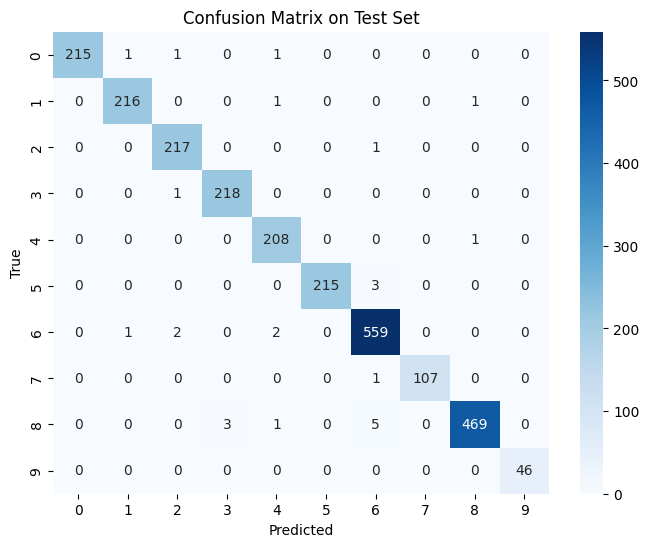

In [42]:

report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


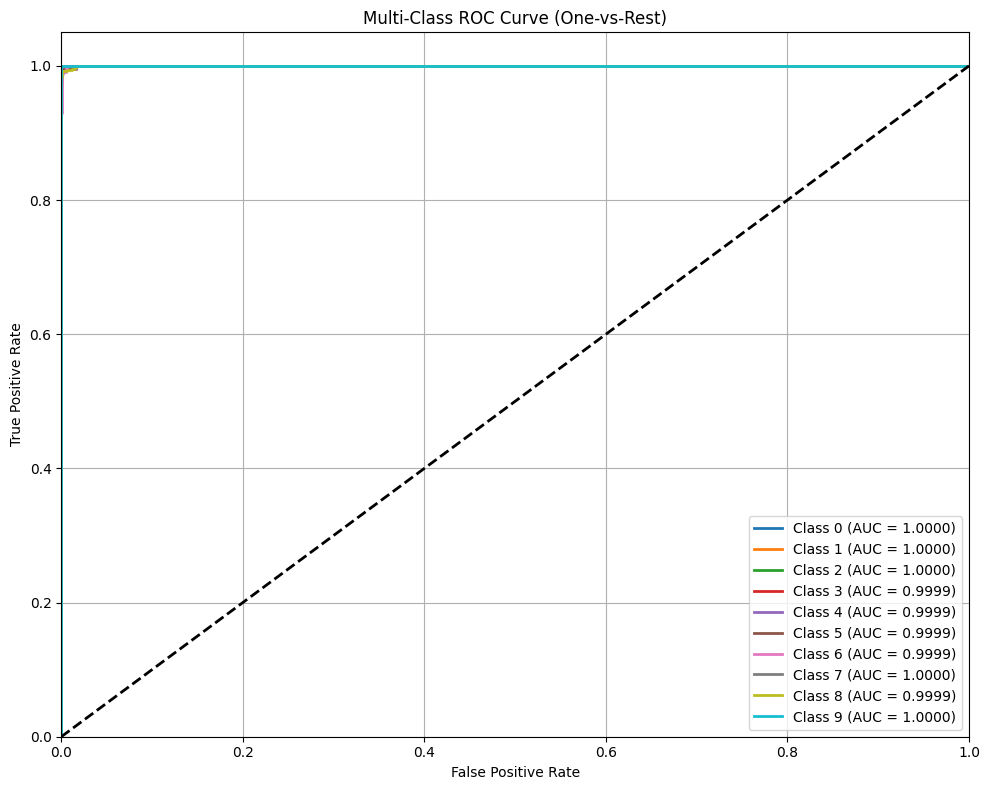

In [46]:
# Prepare data
classes = list(range(num_classes))

# Get probabilities and true labels
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Convert to arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
y_test_bin = label_binarize(all_labels, classes=classes)

# ROC per class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting with 4 decimal AUC values
colors = cycle(plt.cm.tab10.colors)
plt.figure(figsize=(10, 8))

for i, color in zip(range(num_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'Class {i} (AUC = {roc_auc[i]:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## ResNet 50 224*224

In [62]:
def get_timm_model(model_name, num_classes):
    #model = timm.create_model(model_name, pretrained=True)
    model = timm.create_model(model_name, weights="IMAGENET1K_V1")  # Updated from pretrained=True
    
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model

In [63]:
# STEP 4: Define Model (ResNet18 without Dropout)
num_classes = 10
def get_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # Replace classifier head
    return model


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet50_model(num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [66]:

# ----------------------
# Train Function
# ----------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}

    scaler = GradScaler("cuda")

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", disable=(epoch + 1) % 5 != 0 and (epoch + 1) != num_epochs):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", disable=(epoch + 1) % 5 != 0 and (epoch + 1) != num_epochs):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        class_f1 = f1_score(all_labels, all_preds, average=None)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        # Save best model
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        # Print selectively
        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history

In [68]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [69]:
gc.collect()
torch.cuda.empty_cache()

In [70]:

cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Split data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Model, loss, optimizer
    model = get_resnet50_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Train
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store last epoch metrics
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.80it/s]

Epoch 5: Train Loss=0.0625, Val Loss=0.1916, Train Acc=98.09%, Val Acc=93.69%, Val F1-Macro=0.9422



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.65it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0471, Val Loss=0.1628, Train Acc=98.68%, Val Acc=96.10%, Val F1-Macro=0.9620

--- Fold 2 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.82it/s]

Epoch 5: Train Loss=0.0653, Val Loss=0.1822, Train Acc=98.01%, Val Acc=95.40%, Val F1-Macro=0.9576



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.69it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0144, Val Loss=0.1181, Train Acc=99.61%, Val Acc=96.90%, Val F1-Macro=0.9664

--- Fold 3 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.69it/s]


Epoch 5: Train Loss=0.0601, Val Loss=0.1163, Train Acc=98.11%, Val Acc=96.40%, Val F1-Macro=0.9648


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.76it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0322, Val Loss=0.0812, Train Acc=99.04%, Val Acc=97.60%, Val F1-Macro=0.9744

--- Fold 4 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.46it/s]

Epoch 5: Train Loss=0.0696, Val Loss=0.1762, Train Acc=97.89%, Val Acc=93.69%, Val F1-Macro=0.9386



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.80it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0419, Val Loss=0.0561, Train Acc=98.78%, Val Acc=97.90%, Val F1-Macro=0.9817

--- Fold 5 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.69it/s]

Epoch 5: Train Loss=0.0552, Val Loss=0.1561, Train Acc=98.29%, Val Acc=94.89%, Val F1-Macro=0.9436



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.65it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0366, Val Loss=0.1085, Train Acc=99.01%, Val Acc=96.99%, Val F1-Macro=0.9740

--- Fold 6 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.71it/s]

Epoch 5: Train Loss=0.0464, Val Loss=0.1140, Train Acc=98.64%, Val Acc=96.89%, Val F1-Macro=0.9649



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.54it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0424, Val Loss=0.0791, Train Acc=98.69%, Val Acc=97.39%, Val F1-Macro=0.9714

--- Fold 7 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.79it/s]


Epoch 5: Train Loss=0.0695, Val Loss=0.0835, Train Acc=97.74%, Val Acc=97.29%, Val F1-Macro=0.9752


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.63it/s]


Epoch 10: Train Loss=0.0236, Val Loss=0.0400, Train Acc=99.20%, Val Acc=98.90%, Val F1-Macro=0.9892

--- Fold 8 ---


/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


Epoch 5: Train Loss=0.0534, Val Loss=0.0561, Train Acc=98.43%, Val Acc=98.20%, Val F1-Macro=0.9851


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.69it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0384, Val Loss=0.0926, Train Acc=98.92%, Val Acc=97.70%, Val F1-Macro=0.9802

--- Fold 9 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.83it/s]


Epoch 5: Train Loss=0.0552, Val Loss=0.1142, Train Acc=98.26%, Val Acc=96.19%, Val F1-Macro=0.9641


Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10: Train Loss=0.0354, Val Loss=0.0723, Train Acc=98.83%, Val Acc=97.60%, Val F1-Macro=0.9776

--- Fold 10 ---


Epoch 5/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]

Epoch 5: Train Loss=0.0454, Val Loss=0.1269, Train Acc=98.72%, Val Acc=95.69%, Val F1-Macro=0.9605



Epoch 10/10 [Val]: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]

Epoch 10: Train Loss=0.0231, Val Loss=0.0910, Train Acc=99.31%, Val Acc=97.49%, Val F1-Macro=0.9767


In [83]:
# Step 1: Load the best fold model
best_fold = np.argmax(cv_history['val_f1_macro'])  # or pick manually
model = get_resnet50_model(num_classes).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model.eval()

# Step 2: Evaluate on Test Set
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Step 3: Metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4)
cm = confusion_matrix(all_labels, all_preds)

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rsimhadr/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Final Test Set Evaluation ===
Accuracy       : 0.9872
Macro F1-score : 0.9862

Classification Report:
               precision    recall  f1-score   support

           0     0.9641    0.9862    0.9751       218
           1     0.9953    0.9817    0.9885       218
           2     0.9767    0.9633    0.9700       218
           3     0.9908    0.9817    0.9862       219
           4     0.9626    0.9856    0.9740       209
           5     0.9864    1.0000    0.9932       218
           6     0.9929    0.9894    0.9911       564
           7     1.0000    0.9722    0.9859       108
           8     0.9979    0.9979    0.9979       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9872      2496
   macro avg     0.9867    0.9858    0.9862      2496
weighted avg     0.9873    0.9872    0.9872      2496



In [85]:

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round to 4 decimals for clarity
fold_summary = fold_summary.round(4)

print("\n=== Per-Fold Summary ===")
# Display the table
print(fold_summary)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.6756           96.0961      0.0471    0.1628   
1   Fold 2             99.6105           96.8969      0.0144    0.1181   
2   Fold 3             99.0428           97.5976      0.0322    0.0812   
3   Fold 4             98.7757           97.8979      0.0419    0.0561   
4   Fold 5             99.0096           96.9940      0.0366    0.1085   
5   Fold 6             98.6868           97.3948      0.0424    0.0791   
6   Fold 7             99.1988           98.8978      0.0236    0.0400   
7   Fold 8             98.9205           97.6954      0.0384    0.0926   
8   Fold 9             98.8315           97.5952      0.0354    0.0723   
9  Fold 10             99.3100           97.4950      0.0231    0.0910   

   Val Macro F1  
0        0.9620  
1        0.9664  
2        0.9744  
3        0.9817  
4        0.9740  
5        0.9714  
6        0.9892  
7        0.9802

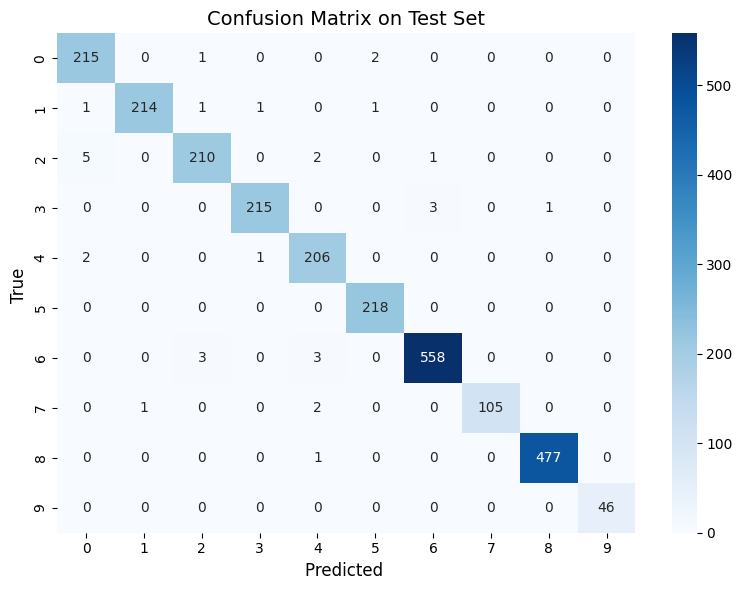

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()


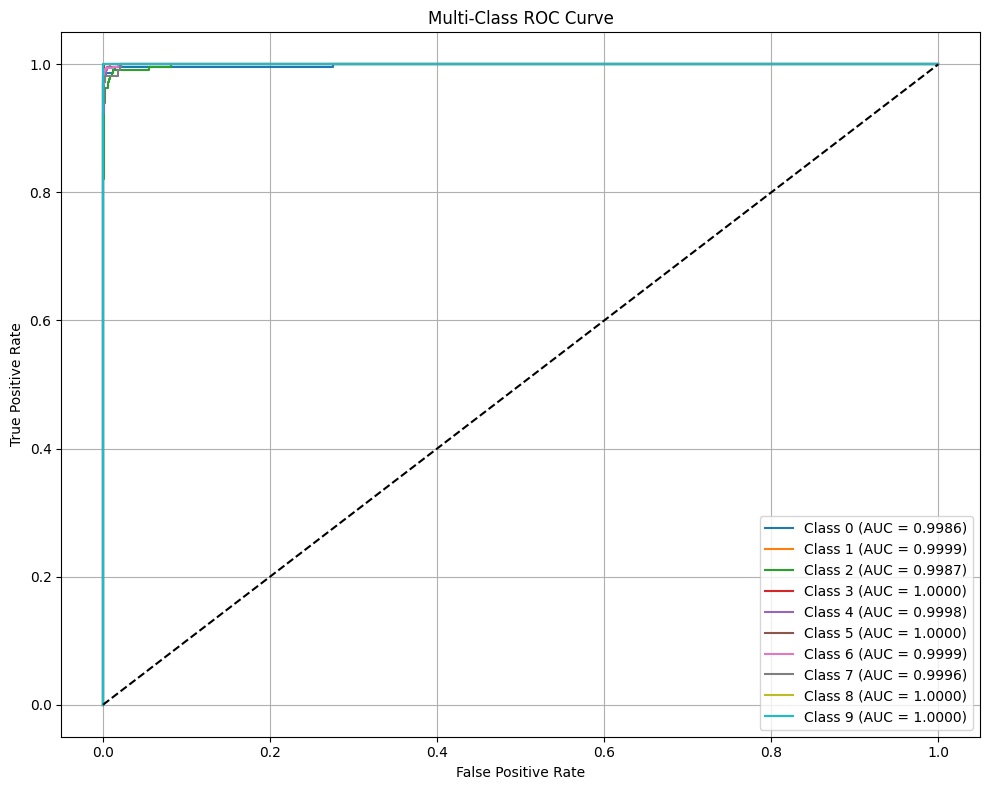

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## InceptionNet- ResNet V2

In [25]:
import torch
import torch.nn as nn
import timm

# General-purpose model loader with classifier head replacement
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)

    # Replace the final classifier layer based on architecture
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classif'):
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head') and hasattr(model.head, 'fc'):
        in_features = model.head.fc.in_features
        model.head.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model



In [41]:
def get_inception_resnet_v2_bundle(num_classes):
    model = get_timm_model("inception_resnet_v2", num_classes)
    return model


In [44]:
from torch.cuda.amp import GradScaler, autocast

In [ ]:
# #from torch.amp import GradScaler, autocast

# def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
#     best_val_f1 = 0.0
#     best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"
#     history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}

#     scaler = GradScaler()  # AMP for CUDA
#     # scaler = GradScaler(device_type='cuda')
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct = 0.0, 0

#         for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()

#             with autocast():  # AMP context
            
#             #with autocast(device_type='cuda'):
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             train_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             train_correct += torch.sum(preds == y_batch).item()

#         train_loss /= len(train_loader.dataset)
#         train_acc = 100. * train_correct / len(train_loader.dataset)

#         # Validation phase
#         model.eval()
#         val_loss, val_correct = 0.0, 0
#         all_preds, all_labels = [], []

#         for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             with torch.no_grad(), autocast():
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             val_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             val_correct += torch.sum(preds == y_batch).item()
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(y_batch.cpu().numpy())

#         val_loss /= len(val_loader.dataset)
#         val_acc = 100. * val_correct / len(val_loader.dataset)
#         class_f1 = f1_score(all_labels, all_preds, average=None)
#         macro_f1 = f1_score(all_labels, all_preds, average='macro')

#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['train_acc'].append(train_acc)
#         history['val_acc'].append(val_acc)
#         history['val_f1_macro'].append(macro_f1)
#         history['val_classwise_f1'].append(class_f1)

#         if macro_f1 > best_val_f1:
#             best_val_f1 = macro_f1
#             torch.save(model.state_dict(), best_model_path)

#         if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
#             print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
#                   f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

#     return history


In [ ]:
# from torch.cuda.amp import GradScaler, autocast  # ✅ Safe for all PyTorch versions
# from tqdm import tqdm
# from sklearn.metrics import f1_score

# def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
#     best_val_f1 = 0.0
#     best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"
#     history = {
#         'train_loss': [], 'val_loss': [],
#         'train_acc': [], 'val_acc': [],
#         'val_f1_macro': [], 'val_classwise_f1': []
#     }

#     scaler = GradScaler()  # ✅ AMP scaler

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct = 0.0, 0

#         for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()

#             with autocast():  # ✅ AMP context
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             train_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             train_correct += torch.sum(preds == y_batch).item()

#         train_loss /= len(train_loader.dataset)
#         train_acc = 100. * train_correct / len(train_loader.dataset)

#         # Validation
#         model.eval()
#         val_loss, val_correct = 0.0, 0
#         all_preds, all_labels = [], []

#         for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             with torch.no_grad(), autocast():
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)

#             val_loss += loss.item() * X_batch.size(0)
#             _, preds = torch.max(outputs, 1)
#             val_correct += torch.sum(preds == y_batch).item()
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(y_batch.cpu().numpy())

#         val_loss /= len(val_loader.dataset)
#         val_acc = 100. * val_correct / len(val_loader.dataset)
#         class_f1 = f1_score(all_labels, all_preds, average=None)
#         macro_f1 = f1_score(all_labels, all_preds, average='macro')

#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['train_acc'].append(train_acc)
#         history['val_acc'].append(val_acc)
#         history['val_f1_macro'].append(macro_f1)
#         history['val_classwise_f1'].append(class_f1)

#         if macro_f1 > best_val_f1:
#             best_val_f1 = macro_f1
#             torch.save(model.state_dict(), best_model_path)

#         # ✅ Always print metrics per epoch
#         print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
#               f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

#     return history


In [48]:
import torch
print(torch.__version__)



2.7.0+cu126


In [50]:
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    scaler = GradScaler('cuda')  # ✅ PyTorch 2.7+ AMP scaler

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast('cuda'):  # ✅ AMP context for 2.7+
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad(), autocast('cuda'):  # ✅ AMP in eval
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        class_f1 = f1_score(all_labels, all_preds, average=None)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        # ✅ Print metrics every epoch
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}", flush=True)
        sys.stdout.flush()

    return history


In [51]:
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(s
                                            kf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Data Split
    
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampling
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Model + Loss + Optimizer
    model = get_inception_resnet_v2_bundle(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    #model, device, criterion, optimizer = get_inception_resnet_v2_bundle(num_classes)


    # Train
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store results
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.73it/s]


Epoch 1: Train Loss=0.9354, Val Loss=0.5921, Train Acc=67.90%, Val Acc=79.38%, Val F1-Macro=0.8104


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.70it/s]


Epoch 2: Train Loss=0.2820, Val Loss=0.1943, Train Acc=91.11%, Val Acc=93.29%, Val F1-Macro=0.9368


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.63it/s]

Epoch 3: Train Loss=0.1439, Val Loss=0.2487, Train Acc=95.53%, Val Acc=91.99%, Val F1-Macro=0.9140



Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.64it/s]


Epoch 4: Train Loss=0.0862, Val Loss=0.1568, Train Acc=97.57%, Val Acc=95.20%, Val F1-Macro=0.9596


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.64it/s]


Epoch 5: Train Loss=0.0699, Val Loss=0.0944, Train Acc=97.83%, Val Acc=96.70%, Val F1-Macro=0.9645


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.62it/s]


Epoch 6: Train Loss=0.0581, Val Loss=0.0546, Train Acc=98.34%, Val Acc=98.40%, Val F1-Macro=0.9854


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.68it/s]

Epoch 7: Train Loss=0.0398, Val Loss=0.0807, Train Acc=98.90%, Val Acc=97.40%, Val F1-Macro=0.9744



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.60it/s]

Epoch 8: Train Loss=0.0374, Val Loss=0.0587, Train Acc=98.86%, Val Acc=98.00%, Val F1-Macro=0.9783



Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.65it/s]

Epoch 9: Train Loss=0.0327, Val Loss=0.1300, Train Acc=99.09%, Val Acc=96.10%, Val F1-Macro=0.9595



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]

Epoch 10: Train Loss=0.0424, Val Loss=0.0795, Train Acc=98.79%, Val Acc=97.30%, Val F1-Macro=0.9749



--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.67it/s]


Epoch 1: Train Loss=0.8875, Val Loss=0.6447, Train Acc=69.60%, Val Acc=80.38%, Val F1-Macro=0.7823


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.64it/s]


Epoch 2: Train Loss=0.2584, Val Loss=0.2245, Train Acc=92.08%, Val Acc=92.49%, Val F1-Macro=0.9312


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 3: Train Loss=0.1442, Val Loss=0.0967, Train Acc=95.35%, Val Acc=97.60%, Val F1-Macro=0.9772


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]

Epoch 4: Train Loss=0.0868, Val Loss=0.1134, Train Acc=97.45%, Val Acc=96.70%, Val F1-Macro=0.9697



Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.57it/s]

Epoch 5: Train Loss=0.0703, Val Loss=0.1580, Train Acc=97.87%, Val Acc=95.20%, Val F1-Macro=0.9535



Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.55it/s]

Epoch 6: Train Loss=0.0623, Val Loss=0.0899, Train Acc=98.15%, Val Acc=96.90%, Val F1-Macro=0.9644



Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.60it/s]

Epoch 7: Train Loss=0.0502, Val Loss=0.1112, Train Acc=98.51%, Val Acc=96.50%, Val F1-Macro=0.9703



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 8: Train Loss=0.0346, Val Loss=0.0575, Train Acc=98.93%, Val Acc=98.10%, Val F1-Macro=0.9834


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]

Epoch 9: Train Loss=0.0409, Val Loss=0.0900, Train Acc=98.75%, Val Acc=97.40%, Val F1-Macro=0.9738



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.58it/s]

Epoch 10: Train Loss=0.0399, Val Loss=0.1357, Train Acc=98.76%, Val Acc=95.60%, Val F1-Macro=0.9587



--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.58it/s]


Epoch 1: Train Loss=0.9444, Val Loss=0.6041, Train Acc=67.94%, Val Acc=80.68%, Val F1-Macro=0.8034


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.46it/s]


Epoch 2: Train Loss=0.2733, Val Loss=0.2390, Train Acc=91.26%, Val Acc=92.79%, Val F1-Macro=0.9292


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 3: Train Loss=0.1411, Val Loss=0.1822, Train Acc=95.74%, Val Acc=93.79%, Val F1-Macro=0.9402


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 4: Train Loss=0.0974, Val Loss=0.1508, Train Acc=97.16%, Val Acc=95.10%, Val F1-Macro=0.9499


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 5: Train Loss=0.0737, Val Loss=0.1638, Train Acc=97.74%, Val Acc=94.89%, Val F1-Macro=0.9499



Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]


Epoch 6: Train Loss=0.0550, Val Loss=0.1038, Train Acc=98.43%, Val Acc=97.10%, Val F1-Macro=0.9714


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 7: Train Loss=0.0527, Val Loss=0.0812, Train Acc=98.49%, Val Acc=97.50%, Val F1-Macro=0.9722


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.46it/s]


Epoch 8: Train Loss=0.0363, Val Loss=0.0875, Train Acc=99.00%, Val Acc=97.70%, Val F1-Macro=0.9783


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 9: Train Loss=0.0353, Val Loss=0.1446, Train Acc=98.92%, Val Acc=94.89%, Val F1-Macro=0.9356



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.49it/s]

Epoch 10: Train Loss=0.0377, Val Loss=0.1149, Train Acc=98.91%, Val Acc=96.40%, Val F1-Macro=0.9626



--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]


Epoch 1: Train Loss=0.9530, Val Loss=0.3715, Train Acc=67.16%, Val Acc=87.09%, Val F1-Macro=0.8823


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 2: Train Loss=0.2644, Val Loss=0.1692, Train Acc=91.93%, Val Acc=94.69%, Val F1-Macro=0.9476


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 3: Train Loss=0.1380, Val Loss=0.1808, Train Acc=95.66%, Val Acc=93.99%, Val F1-Macro=0.9346



Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.46it/s]


Epoch 4: Train Loss=0.0923, Val Loss=0.1240, Train Acc=97.43%, Val Acc=96.40%, Val F1-Macro=0.9619


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 5: Train Loss=0.0648, Val Loss=0.0837, Train Acc=97.92%, Val Acc=97.60%, Val F1-Macro=0.9771


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 6: Train Loss=0.0595, Val Loss=0.0854, Train Acc=98.16%, Val Acc=97.90%, Val F1-Macro=0.9810


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 7: Train Loss=0.0595, Val Loss=0.1212, Train Acc=98.21%, Val Acc=96.80%, Val F1-Macro=0.9749



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 8: Train Loss=0.0399, Val Loss=0.1822, Train Acc=98.92%, Val Acc=94.29%, Val F1-Macro=0.9483



Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.55it/s]

Epoch 9: Train Loss=0.0420, Val Loss=0.1119, Train Acc=98.88%, Val Acc=96.40%, Val F1-Macro=0.9596



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 10: Train Loss=0.0301, Val Loss=0.0816, Train Acc=99.15%, Val Acc=97.50%, Val F1-Macro=0.9797



--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.34it/s]


Epoch 1: Train Loss=0.8627, Val Loss=0.3798, Train Acc=71.05%, Val Acc=87.88%, Val F1-Macro=0.8718


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 2: Train Loss=0.2449, Val Loss=0.4571, Train Acc=92.56%, Val Acc=85.27%, Val F1-Macro=0.8675



Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 3: Train Loss=0.1369, Val Loss=0.0946, Train Acc=95.78%, Val Acc=97.49%, Val F1-Macro=0.9755


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]

Epoch 4: Train Loss=0.0812, Val Loss=0.1059, Train Acc=97.53%, Val Acc=96.79%, Val F1-Macro=0.9682



Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.59it/s]

Epoch 5: Train Loss=0.0652, Val Loss=0.0829, Train Acc=98.12%, Val Acc=97.39%, Val F1-Macro=0.9675



Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 6: Train Loss=0.0518, Val Loss=0.0802, Train Acc=98.44%, Val Acc=97.49%, Val F1-Macro=0.9737



Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]

Epoch 7: Train Loss=0.0473, Val Loss=0.0776, Train Acc=98.63%, Val Acc=97.70%, Val F1-Macro=0.9728



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.59it/s]


Epoch 8: Train Loss=0.0459, Val Loss=0.0549, Train Acc=98.63%, Val Acc=98.40%, Val F1-Macro=0.9819


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 9: Train Loss=0.0372, Val Loss=0.0650, Train Acc=98.91%, Val Acc=97.90%, Val F1-Macro=0.9799



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.47it/s]

Epoch 10: Train Loss=0.0303, Val Loss=0.2300, Train Acc=99.13%, Val Acc=93.59%, Val F1-Macro=0.9354



--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 1: Train Loss=0.8732, Val Loss=0.5397, Train Acc=70.35%, Val Acc=80.96%, Val F1-Macro=0.8245


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 2: Train Loss=0.2473, Val Loss=0.1303, Train Acc=92.37%, Val Acc=95.49%, Val F1-Macro=0.9573


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]

Epoch 3: Train Loss=0.1346, Val Loss=0.2221, Train Acc=95.65%, Val Acc=93.69%, Val F1-Macro=0.9338



Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 4: Train Loss=0.0909, Val Loss=0.1498, Train Acc=97.25%, Val Acc=95.29%, Val F1-Macro=0.9516



Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]

Epoch 5: Train Loss=0.0599, Val Loss=0.1324, Train Acc=98.30%, Val Acc=95.79%, Val F1-Macro=0.9497



Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.47it/s]

Epoch 6: Train Loss=0.0592, Val Loss=0.1456, Train Acc=98.29%, Val Acc=95.89%, Val F1-Macro=0.9338



Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 7: Train Loss=0.0575, Val Loss=0.0540, Train Acc=98.34%, Val Acc=98.50%, Val F1-Macro=0.9827


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]

Epoch 8: Train Loss=0.0443, Val Loss=0.2143, Train Acc=98.71%, Val Acc=93.49%, Val F1-Macro=0.9262



Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]

Epoch 9: Train Loss=0.0335, Val Loss=0.0643, Train Acc=99.12%, Val Acc=97.90%, Val F1-Macro=0.9754



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 10: Train Loss=0.0296, Val Loss=0.0422, Train Acc=99.14%, Val Acc=98.40%, Val F1-Macro=0.9831

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 1: Train Loss=0.8567, Val Loss=0.4185, Train Acc=70.92%, Val Acc=85.47%, Val F1-Macro=0.8723


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.47it/s]


Epoch 2: Train Loss=0.2466, Val Loss=0.1732, Train Acc=92.40%, Val Acc=94.39%, Val F1-Macro=0.9500


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 3: Train Loss=0.1230, Val Loss=0.1512, Train Acc=96.29%, Val Acc=95.49%, Val F1-Macro=0.9531


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]


Epoch 4: Train Loss=0.0890, Val Loss=0.1050, Train Acc=97.14%, Val Acc=96.59%, Val F1-Macro=0.9702


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]


Epoch 5: Train Loss=0.0577, Val Loss=0.0843, Train Acc=98.36%, Val Acc=97.29%, Val F1-Macro=0.9727


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]


Epoch 6: Train Loss=0.0516, Val Loss=0.0646, Train Acc=98.40%, Val Acc=97.70%, Val F1-Macro=0.9759


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]

Epoch 7: Train Loss=0.0547, Val Loss=0.1118, Train Acc=98.30%, Val Acc=96.59%, Val F1-Macro=0.9707



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]


Epoch 8: Train Loss=0.0357, Val Loss=0.0627, Train Acc=98.93%, Val Acc=98.10%, Val F1-Macro=0.9830


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]

Epoch 9: Train Loss=0.0238, Val Loss=0.2028, Train Acc=99.25%, Val Acc=94.79%, Val F1-Macro=0.9478



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]

Epoch 10: Train Loss=0.0366, Val Loss=0.0679, Train Acc=98.97%, Val Acc=97.60%, Val F1-Macro=0.9786



--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]


Epoch 1: Train Loss=0.8607, Val Loss=0.4646, Train Acc=70.92%, Val Acc=83.97%, Val F1-Macro=0.8527


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 2: Train Loss=0.2524, Val Loss=0.1933, Train Acc=92.11%, Val Acc=93.69%, Val F1-Macro=0.9458


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.57it/s]


Epoch 3: Train Loss=0.1300, Val Loss=0.1802, Train Acc=96.24%, Val Acc=95.19%, Val F1-Macro=0.9562


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 4: Train Loss=0.0801, Val Loss=0.1422, Train Acc=97.60%, Val Acc=95.99%, Val F1-Macro=0.9632


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.49it/s]


Epoch 5: Train Loss=0.0617, Val Loss=0.0873, Train Acc=98.12%, Val Acc=97.60%, Val F1-Macro=0.9782


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 6: Train Loss=0.0521, Val Loss=0.1080, Train Acc=98.50%, Val Acc=95.99%, Val F1-Macro=0.9621



Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.45it/s]

Epoch 7: Train Loss=0.0487, Val Loss=0.1337, Train Acc=98.53%, Val Acc=95.79%, Val F1-Macro=0.9679



Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 8: Train Loss=0.0387, Val Loss=0.0801, Train Acc=98.98%, Val Acc=97.09%, Val F1-Macro=0.9709



Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.57it/s]

Epoch 9: Train Loss=0.0492, Val Loss=0.1552, Train Acc=98.38%, Val Acc=96.39%, Val F1-Macro=0.9570



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.55it/s]

Epoch 10: Train Loss=0.0254, Val Loss=0.1209, Train Acc=99.23%, Val Acc=97.29%, Val F1-Macro=0.9743



--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.58it/s]


Epoch 1: Train Loss=0.8726, Val Loss=0.6126, Train Acc=70.79%, Val Acc=77.25%, Val F1-Macro=0.7862


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.50it/s]


Epoch 2: Train Loss=0.2455, Val Loss=0.1912, Train Acc=92.27%, Val Acc=93.69%, Val F1-Macro=0.9371


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]


Epoch 3: Train Loss=0.1375, Val Loss=0.1302, Train Acc=95.84%, Val Acc=95.59%, Val F1-Macro=0.9566


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.49it/s]

Epoch 4: Train Loss=0.0901, Val Loss=0.1623, Train Acc=97.34%, Val Acc=94.59%, Val F1-Macro=0.9528



Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]


Epoch 5: Train Loss=0.0658, Val Loss=0.0972, Train Acc=98.13%, Val Acc=96.89%, Val F1-Macro=0.9681


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.48it/s]


Epoch 6: Train Loss=0.0486, Val Loss=0.1113, Train Acc=98.61%, Val Acc=96.59%, Val F1-Macro=0.9684


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 7: Train Loss=0.0499, Val Loss=0.0754, Train Acc=98.59%, Val Acc=97.60%, Val F1-Macro=0.9779


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.47it/s]

Epoch 8: Train Loss=0.0410, Val Loss=0.0679, Train Acc=98.82%, Val Acc=97.90%, Val F1-Macro=0.9762



Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.58it/s]

Epoch 9: Train Loss=0.0345, Val Loss=0.0771, Train Acc=98.94%, Val Acc=96.89%, Val F1-Macro=0.9709



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 10: Train Loss=0.0275, Val Loss=0.1001, Train Acc=99.31%, Val Acc=97.09%, Val F1-Macro=0.9739



--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.56it/s]


Epoch 1: Train Loss=0.8730, Val Loss=0.4900, Train Acc=70.78%, Val Acc=83.57%, Val F1-Macro=0.8541


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 2: Train Loss=0.2411, Val Loss=0.2381, Train Acc=92.62%, Val Acc=92.18%, Val F1-Macro=0.9325


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 3: Train Loss=0.1340, Val Loss=0.1033, Train Acc=96.00%, Val Acc=96.89%, Val F1-Macro=0.9717


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 4: Train Loss=0.0834, Val Loss=0.1395, Train Acc=97.60%, Val Acc=95.49%, Val F1-Macro=0.9615



Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 5: Train Loss=0.0753, Val Loss=0.0842, Train Acc=97.95%, Val Acc=97.60%, Val F1-Macro=0.9741


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.54it/s]

Epoch 6: Train Loss=0.0570, Val Loss=0.1131, Train Acc=98.13%, Val Acc=96.59%, Val F1-Macro=0.9656



Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.51it/s]


Epoch 7: Train Loss=0.0520, Val Loss=0.0576, Train Acc=98.39%, Val Acc=97.80%, Val F1-Macro=0.9800


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.42it/s]


Epoch 8: Train Loss=0.0299, Val Loss=0.0630, Train Acc=99.14%, Val Acc=98.00%, Val F1-Macro=0.9805


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]

Epoch 9: Train Loss=0.0422, Val Loss=0.2169, Train Acc=98.84%, Val Acc=93.99%, Val F1-Macro=0.9306



Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 20.52it/s]


Epoch 10: Train Loss=0.0352, Val Loss=0.0621, Train Acc=98.95%, Val Acc=98.10%, Val F1-Macro=0.9831


In [54]:
best_fold = np.argmax(cv_history['val_f1_macro'])  # Best fold index

# Just get the model (don't unpack)
model = get_inception_resnet_v2_bundle(num_classes)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9768
Macro F1-score : 0.9775

Classification Report:
               precision    recall  f1-score   support

           0     0.9860    0.9679    0.9769       218
           1     0.9351    0.9908    0.9621       218
           2     0.9491    0.9404    0.9447       218
           3     0.9683    0.9772    0.9727       219
           4     0.9904    0.9856    0.9880       209
           5     1.0000    1.0000    1.0000       218
           6     0.9667    0.9770    0.9718       564
           7     0.9906    0.9722    0.9813       108
           8     1.0000    0.9770    0.9884       478
           9     1.0000    0.9783    0.9890        46

    accuracy                         0.9768      2496
   macro avg     0.9786    0.9766    0.9775      2496
weighted avg     0.9771    0.9768    0.9768      2496



In [55]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.7869           97.2973      0.0424    0.0795   
1   Fold 2             98.7646           95.5956      0.0399    0.1357   
2   Fold 3             98.9093           96.3964      0.0377    0.1149   
3   Fold 4             99.1541           97.4975      0.0301    0.0816   
4   Fold 5             99.1320           93.5872      0.0303    0.2300   
5   Fold 6             99.1431           98.3968      0.0296    0.0422   
6   Fold 7             98.9651           97.5952      0.0366    0.0679   
7   Fold 8             99.2321           97.2946      0.0254    0.1209   
8   Fold 9             99.3100           97.0942      0.0275    0.1001   
9  Fold 10             98.9539           98.0962      0.0352    0.0621   

   Val Macro F1  
0        0.9749  
1        0.9587  
2        0.9626  
3        0.9797  
4        0.9354  
5        0.9831  
6        0.9786  
7        0.9743

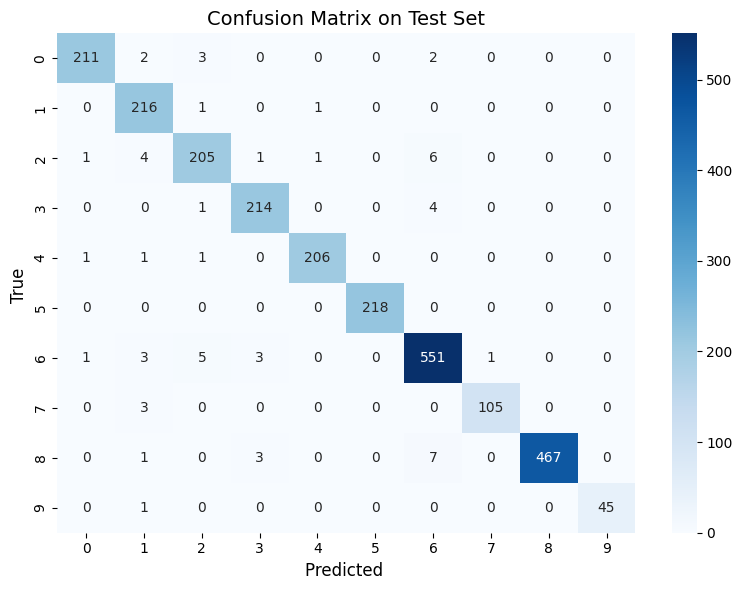

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

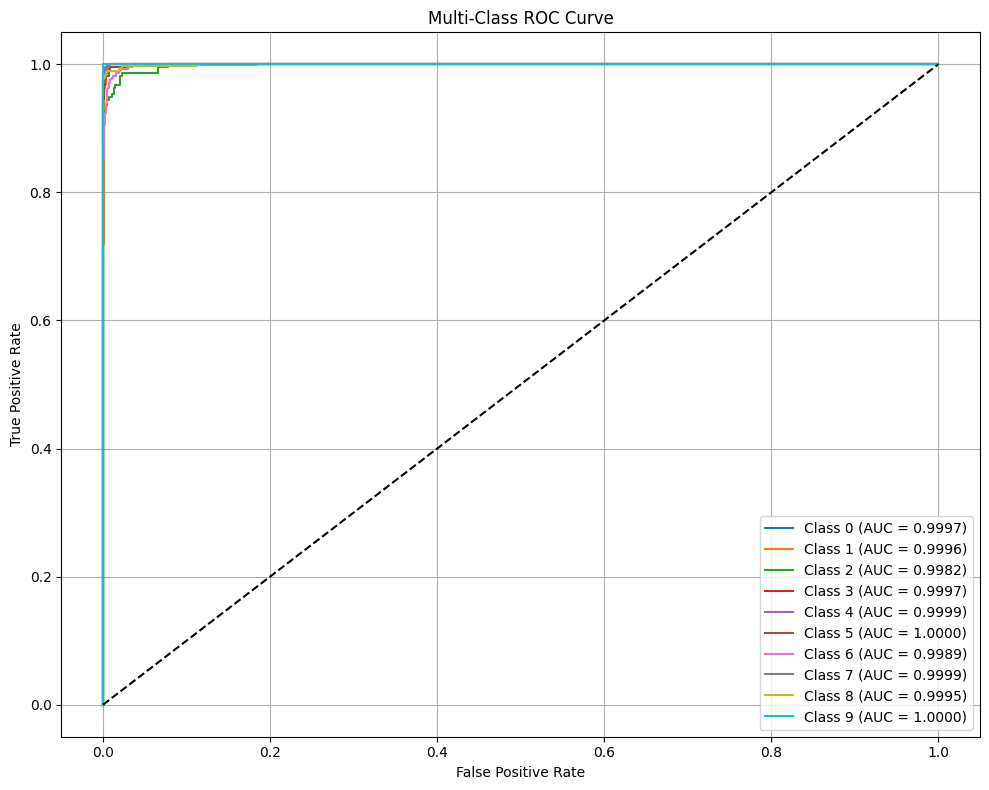

In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Model training: Xception Net 71

In [12]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classif'):
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head') and hasattr(model.head, 'fc'):
        in_features = model.head.fc.in_features
        model.head.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [13]:
def get_xception71_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("xception71", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            #with autocast():
            with autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #with torch.no_grad(), autocast():
            with torch.no_grad(), autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [ ]:
# cv_history = {
#     'train_acc': [], 'val_acc': [],
#     'train_loss': [], 'val_loss': [],
#     'val_f1_macro': [], 'val_classwise_f1': []
# }

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#     print(f"\n--- Fold {fold + 1} ---")

#     # Prepare train/val data
#     X_train = [X_trainval[i] for i in train_idx]
#     y_train = [y_trainval[i] for i in train_idx]
#     X_val = [X_trainval[i] for i in val_idx]
#     y_val = [y_trainval[i] for i in val_idx]

#     # Weighted sampler
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#     sample_weights = [weight_map[y] for y in y_train]
#     sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#     # DataLoaders
#     train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
#     val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

#     # Model + optimizer
#     num_classes = 10
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = get_timm_model("xception71", num_classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#     # Train
#     history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

#     # Save final metrics (last epoch)
#     cv_history['train_acc'].append(history['train_acc'][-1])
#     cv_history['val_acc'].append(history['val_acc'][-1])
#     cv_history['train_loss'].append(history['train_loss'][-1])
#     cv_history['val_loss'].append(history['val_loss'][-1])
#     cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
#     cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.71it/s]


Epoch 1: Train Loss=0.8198, Val Loss=0.5725, Train Acc=72.50%, Val Acc=84.58%, Val F1-Macro=0.8560


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.64it/s]


Epoch 2: Train Loss=0.2378, Val Loss=0.2362, Train Acc=92.33%, Val Acc=92.49%, Val F1-Macro=0.9242


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.65it/s]


Epoch 3: Train Loss=0.1527, Val Loss=0.2091, Train Acc=95.01%, Val Acc=92.09%, Val F1-Macro=0.9263


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.61it/s]


Epoch 4: Train Loss=0.1039, Val Loss=0.1056, Train Acc=96.71%, Val Acc=96.60%, Val F1-Macro=0.9687


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.63it/s]


Epoch 5: Train Loss=0.0833, Val Loss=0.1346, Train Acc=97.51%, Val Acc=96.30%, Val F1-Macro=0.9606


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.60it/s]


Epoch 6: Train Loss=0.0613, Val Loss=0.1355, Train Acc=98.17%, Val Acc=95.60%, Val F1-Macro=0.9578


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.53it/s]


Epoch 7: Train Loss=0.0749, Val Loss=0.0607, Train Acc=97.61%, Val Acc=98.20%, Val F1-Macro=0.9757


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.55it/s]


Epoch 8: Train Loss=0.0667, Val Loss=0.1086, Train Acc=98.02%, Val Acc=96.80%, Val F1-Macro=0.9738


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.44it/s]


Epoch 9: Train Loss=0.0614, Val Loss=0.0902, Train Acc=98.09%, Val Acc=97.50%, Val F1-Macro=0.9713


Epoch 10/10 [Train]:  51%|█████     | 284/562 [00:31<00:31,  8.93it/s]


KeyboardInterrupt: 

In [23]:
import torch, gc

torch.cuda.empty_cache()
gc.collect()


0

In [25]:
from collections import defaultdict
import gc
import torch

cv_history = defaultdict(list)  # Stores per-epoch lists for all metrics
summary_table = []
fold_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # === Clear GPU memory before new model setup ===
    torch.cuda.empty_cache()
    gc.collect()

    # === Prepare Train/Val Data ===
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val   = [X_trainval[i] for i in val_idx]
    y_val   = [y_trainval[i] for i in val_idx]

    # === Weighted Sampler ===
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # === DataLoaders ===
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset   = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # === Model, Loss, Optimizer ===
    num_classes = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("xception71", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # === Train Model ===
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # === Store full per-epoch history in cv_history ===
    for metric_name, epoch_values in history.items():
        cv_history[metric_name].append(epoch_values)

    # === Recompute predictions for classification report (optional) ===
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.cpu().numpy())
    fold_preds.append((y_true, y_pred, fold))

    # === Add to summary table (final epoch stats) ===
    summary_table.append({
        "Fold": f"Fold {fold+1}",
        "Train Accuracy (%)": history['train_acc'][-1],
        "Val Accuracy (%)": history['val_acc'][-1],
        "Train Loss": history['train_loss'][-1],
        "Val Loss": history['val_loss'][-1],
        "Val Macro F1": f1_score(y_true, y_pred, average='macro')
    })

    # === Cleanup ===
    del model
    torch.cuda.empty_cache()
    gc.collect()

# === Convert summary table to DataFrame for printing ===
summary_df = pd.DataFrame(summary_table)



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 31.05it/s]


Epoch 1: Train Loss=0.7715, Val Loss=0.4387, Train Acc=74.08%, Val Acc=87.69%, Val F1-Macro=0.8835


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 31.25it/s]


Epoch 2: Train Loss=0.2542, Val Loss=2.8797, Train Acc=91.70%, Val Acc=87.29%, Val F1-Macro=0.8941


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 31.14it/s]


Epoch 3: Train Loss=0.1602, Val Loss=0.1469, Train Acc=94.86%, Val Acc=94.89%, Val F1-Macro=0.9491


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 31.15it/s]


Epoch 4: Train Loss=0.1179, Val Loss=0.1703, Train Acc=95.99%, Val Acc=94.69%, Val F1-Macro=0.9481


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.95it/s]


Epoch 5: Train Loss=0.1004, Val Loss=0.1625, Train Acc=96.94%, Val Acc=95.20%, Val F1-Macro=0.9498


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.86it/s]


Epoch 6: Train Loss=0.0974, Val Loss=1.2869, Train Acc=96.98%, Val Acc=93.39%, Val F1-Macro=0.9386


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.80it/s]


Epoch 7: Train Loss=0.0697, Val Loss=0.1105, Train Acc=98.09%, Val Acc=96.50%, Val F1-Macro=0.9645


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.83it/s]


Epoch 8: Train Loss=0.0707, Val Loss=0.1412, Train Acc=97.95%, Val Acc=95.90%, Val F1-Macro=0.9635


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 31.02it/s]


Epoch 9: Train Loss=0.0585, Val Loss=0.0692, Train Acc=98.09%, Val Acc=98.10%, Val F1-Macro=0.9822


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.83it/s]

Epoch 10: Train Loss=0.0527, Val Loss=0.0877, Train Acc=98.55%, Val Acc=97.50%, Val F1-Macro=0.9754



--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.54it/s]


Epoch 1: Train Loss=0.8176, Val Loss=nan, Train Acc=72.52%, Val Acc=85.09%, Val F1-Macro=0.8542


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.64it/s]


Epoch 2: Train Loss=0.2848, Val Loss=0.1484, Train Acc=90.71%, Val Acc=95.90%, Val F1-Macro=0.9623


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.53it/s]


Epoch 3: Train Loss=0.1710, Val Loss=0.1251, Train Acc=94.66%, Val Acc=96.30%, Val F1-Macro=0.9655


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.52it/s]


Epoch 4: Train Loss=0.1312, Val Loss=0.1841, Train Acc=95.80%, Val Acc=94.49%, Val F1-Macro=0.9429


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]


Epoch 5: Train Loss=0.1085, Val Loss=0.0729, Train Acc=96.59%, Val Acc=97.80%, Val F1-Macro=0.9783


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 6: Train Loss=0.0883, Val Loss=0.1248, Train Acc=97.40%, Val Acc=96.20%, Val F1-Macro=0.9603


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.55it/s]


Epoch 7: Train Loss=0.0854, Val Loss=0.1270, Train Acc=97.48%, Val Acc=96.30%, Val F1-Macro=0.9624


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.50it/s]


Epoch 8: Train Loss=0.0766, Val Loss=0.0765, Train Acc=97.54%, Val Acc=97.80%, Val F1-Macro=0.9818


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.49it/s]


Epoch 9: Train Loss=0.0612, Val Loss=0.0610, Train Acc=98.13%, Val Acc=98.00%, Val F1-Macro=0.9820


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]

Epoch 10: Train Loss=0.0540, Val Loss=0.1120, Train Acc=98.41%, Val Acc=97.00%, Val F1-Macro=0.9701



--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.51it/s]


Epoch 1: Train Loss=0.7865, Val Loss=0.3979, Train Acc=73.19%, Val Acc=89.19%, Val F1-Macro=0.8858


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]


Epoch 2: Train Loss=0.2445, Val Loss=0.3791, Train Acc=92.16%, Val Acc=90.49%, Val F1-Macro=0.9269


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.31it/s]


Epoch 3: Train Loss=0.1566, Val Loss=0.1929, Train Acc=95.07%, Val Acc=93.79%, Val F1-Macro=0.9358


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]


Epoch 4: Train Loss=0.1138, Val Loss=0.4684, Train Acc=96.25%, Val Acc=89.49%, Val F1-Macro=0.8715


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]


Epoch 5: Train Loss=0.1066, Val Loss=0.0867, Train Acc=96.44%, Val Acc=96.90%, Val F1-Macro=0.9723


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.36it/s]


Epoch 6: Train Loss=0.0821, Val Loss=0.0938, Train Acc=97.47%, Val Acc=97.20%, Val F1-Macro=0.9767


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.37it/s]


Epoch 7: Train Loss=0.0692, Val Loss=0.0479, Train Acc=97.86%, Val Acc=98.50%, Val F1-Macro=0.9781


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 8: Train Loss=0.0614, Val Loss=0.0475, Train Acc=98.01%, Val Acc=98.50%, Val F1-Macro=0.9873


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.33it/s]


Epoch 9: Train Loss=0.0589, Val Loss=0.1175, Train Acc=98.21%, Val Acc=97.20%, Val F1-Macro=0.9739


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 10: Train Loss=0.0546, Val Loss=0.0610, Train Acc=98.30%, Val Acc=98.30%, Val F1-Macro=0.9828

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.51it/s]


Epoch 1: Train Loss=0.8091, Val Loss=nan, Train Acc=72.72%, Val Acc=86.79%, Val F1-Macro=0.8670


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 2: Train Loss=0.2498, Val Loss=nan, Train Acc=91.99%, Val Acc=93.29%, Val F1-Macro=0.9355


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 3: Train Loss=0.1590, Val Loss=nan, Train Acc=95.11%, Val Acc=95.30%, Val F1-Macro=0.9452


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.32it/s]


Epoch 4: Train Loss=0.1239, Val Loss=0.1081, Train Acc=95.95%, Val Acc=97.30%, Val F1-Macro=0.9751


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 5: Train Loss=0.0944, Val Loss=nan, Train Acc=97.11%, Val Acc=93.09%, Val F1-Macro=0.9328


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 6: Train Loss=0.0804, Val Loss=nan, Train Acc=97.54%, Val Acc=97.90%, Val F1-Macro=0.9790


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 7: Train Loss=0.0860, Val Loss=0.1632, Train Acc=97.41%, Val Acc=95.80%, Val F1-Macro=0.9653


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.50it/s]


Epoch 8: Train Loss=0.0677, Val Loss=0.0889, Train Acc=97.89%, Val Acc=97.30%, Val F1-Macro=0.9717


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.32it/s]


Epoch 9: Train Loss=0.0687, Val Loss=0.0827, Train Acc=97.94%, Val Acc=98.10%, Val F1-Macro=0.9777


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]

Epoch 10: Train Loss=0.0561, Val Loss=0.1186, Train Acc=98.48%, Val Acc=97.10%, Val F1-Macro=0.9689



--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.25it/s]


Epoch 1: Train Loss=0.7611, Val Loss=0.4932, Train Acc=74.39%, Val Acc=84.07%, Val F1-Macro=0.8646


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 2: Train Loss=0.2575, Val Loss=nan, Train Acc=91.88%, Val Acc=85.77%, Val F1-Macro=0.8623


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 3: Train Loss=0.1486, Val Loss=0.1290, Train Acc=95.13%, Val Acc=95.59%, Val F1-Macro=0.9634


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 4: Train Loss=0.1212, Val Loss=0.1468, Train Acc=96.24%, Val Acc=95.69%, Val F1-Macro=0.9545


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 5: Train Loss=0.0905, Val Loss=0.1098, Train Acc=97.48%, Val Acc=96.39%, Val F1-Macro=0.9481


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 6: Train Loss=0.0927, Val Loss=0.0697, Train Acc=97.21%, Val Acc=97.80%, Val F1-Macro=0.9799


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.52it/s]


Epoch 7: Train Loss=0.0754, Val Loss=0.0571, Train Acc=97.75%, Val Acc=97.80%, Val F1-Macro=0.9781


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 8: Train Loss=0.0665, Val Loss=0.0809, Train Acc=97.90%, Val Acc=97.70%, Val F1-Macro=0.9731


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.53it/s]


Epoch 9: Train Loss=0.0423, Val Loss=0.0739, Train Acc=98.75%, Val Acc=97.49%, Val F1-Macro=0.9712


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.42it/s]


Epoch 10: Train Loss=0.0613, Val Loss=0.0617, Train Acc=98.19%, Val Acc=98.30%, Val F1-Macro=0.9828

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.49it/s]


Epoch 1: Train Loss=0.7945, Val Loss=0.2736, Train Acc=73.40%, Val Acc=91.88%, Val F1-Macro=0.9262


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.56it/s]


Epoch 2: Train Loss=0.2465, Val Loss=0.1362, Train Acc=92.18%, Val Acc=95.79%, Val F1-Macro=0.9543


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.40it/s]


Epoch 3: Train Loss=0.1634, Val Loss=0.1725, Train Acc=94.90%, Val Acc=95.19%, Val F1-Macro=0.9429


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.39it/s]


Epoch 4: Train Loss=0.1331, Val Loss=0.2188, Train Acc=95.84%, Val Acc=94.19%, Val F1-Macro=0.9381


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.44it/s]


Epoch 5: Train Loss=0.0978, Val Loss=0.0749, Train Acc=97.05%, Val Acc=97.09%, Val F1-Macro=0.9726


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.34it/s]


Epoch 6: Train Loss=0.0947, Val Loss=0.1046, Train Acc=97.00%, Val Acc=97.29%, Val F1-Macro=0.9704


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.50it/s]


Epoch 7: Train Loss=0.0739, Val Loss=0.0623, Train Acc=97.74%, Val Acc=98.20%, Val F1-Macro=0.9805


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.38it/s]


Epoch 8: Train Loss=0.0693, Val Loss=0.1321, Train Acc=97.92%, Val Acc=96.19%, Val F1-Macro=0.9640


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.44it/s]


Epoch 9: Train Loss=0.0602, Val Loss=0.0414, Train Acc=98.16%, Val Acc=99.00%, Val F1-Macro=0.9881


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]

Epoch 10: Train Loss=0.0513, Val Loss=0.0978, Train Acc=98.42%, Val Acc=97.90%, Val F1-Macro=0.9771



--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.38it/s]


Epoch 1: Train Loss=0.8162, Val Loss=0.5185, Train Acc=72.75%, Val Acc=84.47%, Val F1-Macro=0.8447


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.62it/s]


Epoch 2: Train Loss=0.2587, Val Loss=0.1775, Train Acc=91.45%, Val Acc=94.29%, Val F1-Macro=0.9465


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.60it/s]


Epoch 3: Train Loss=0.1649, Val Loss=nan, Train Acc=94.80%, Val Acc=95.19%, Val F1-Macro=0.9518


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.36it/s]


Epoch 4: Train Loss=0.1230, Val Loss=0.1661, Train Acc=96.19%, Val Acc=94.79%, Val F1-Macro=0.9475


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 5: Train Loss=0.1084, Val Loss=0.1234, Train Acc=96.58%, Val Acc=96.19%, Val F1-Macro=0.9582


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 6: Train Loss=0.0824, Val Loss=0.1208, Train Acc=97.28%, Val Acc=96.69%, Val F1-Macro=0.9642


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.52it/s]


Epoch 7: Train Loss=0.0795, Val Loss=0.0764, Train Acc=97.57%, Val Acc=98.10%, Val F1-Macro=0.9793


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 8: Train Loss=0.0671, Val Loss=0.0721, Train Acc=97.93%, Val Acc=97.80%, Val F1-Macro=0.9784


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.47it/s]


Epoch 9: Train Loss=0.0604, Val Loss=0.0594, Train Acc=98.22%, Val Acc=97.90%, Val F1-Macro=0.9722


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 10: Train Loss=0.0609, Val Loss=0.0476, Train Acc=98.09%, Val Acc=98.60%, Val F1-Macro=0.9845

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 1: Train Loss=0.7780, Val Loss=nan, Train Acc=73.80%, Val Acc=90.38%, Val F1-Macro=0.9170


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 2: Train Loss=0.2628, Val Loss=nan, Train Acc=91.63%, Val Acc=93.29%, Val F1-Macro=0.9311


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 3: Train Loss=0.1483, Val Loss=0.1521, Train Acc=95.42%, Val Acc=95.19%, Val F1-Macro=0.9546


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.41it/s]


Epoch 4: Train Loss=0.1278, Val Loss=0.1244, Train Acc=96.27%, Val Acc=95.49%, Val F1-Macro=0.9582


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.35it/s]


Epoch 5: Train Loss=0.1065, Val Loss=0.1207, Train Acc=96.35%, Val Acc=96.29%, Val F1-Macro=0.9607


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.36it/s]


Epoch 6: Train Loss=0.0719, Val Loss=0.0788, Train Acc=97.90%, Val Acc=97.70%, Val F1-Macro=0.9796


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 7: Train Loss=0.0726, Val Loss=0.1273, Train Acc=97.93%, Val Acc=96.59%, Val F1-Macro=0.9659


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.31it/s]


Epoch 8: Train Loss=0.0625, Val Loss=0.1158, Train Acc=98.10%, Val Acc=96.59%, Val F1-Macro=0.9603


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.56it/s]


Epoch 9: Train Loss=0.0543, Val Loss=0.1395, Train Acc=98.40%, Val Acc=96.79%, Val F1-Macro=0.9670


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.37it/s]

Epoch 10: Train Loss=0.0550, Val Loss=0.1059, Train Acc=98.40%, Val Acc=97.29%, Val F1-Macro=0.9764



--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 1: Train Loss=0.7977, Val Loss=nan, Train Acc=73.43%, Val Acc=87.58%, Val F1-Macro=0.8914


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 2: Train Loss=0.2564, Val Loss=0.2197, Train Acc=91.97%, Val Acc=93.39%, Val F1-Macro=0.9379


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.52it/s]


Epoch 3: Train Loss=0.1599, Val Loss=0.2415, Train Acc=94.91%, Val Acc=91.98%, Val F1-Macro=0.9221


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.64it/s]


Epoch 4: Train Loss=0.1222, Val Loss=0.1026, Train Acc=96.23%, Val Acc=95.79%, Val F1-Macro=0.9559


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 5: Train Loss=0.1046, Val Loss=0.1911, Train Acc=96.76%, Val Acc=94.59%, Val F1-Macro=0.9483


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 6: Train Loss=0.0881, Val Loss=0.1436, Train Acc=97.43%, Val Acc=96.69%, Val F1-Macro=0.9635


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 7: Train Loss=0.0665, Val Loss=0.1772, Train Acc=97.89%, Val Acc=95.69%, Val F1-Macro=0.9558


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.60it/s]


Epoch 8: Train Loss=0.0633, Val Loss=0.1253, Train Acc=98.16%, Val Acc=95.69%, Val F1-Macro=0.9592


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.45it/s]


Epoch 9: Train Loss=0.0622, Val Loss=0.0933, Train Acc=98.14%, Val Acc=97.39%, Val F1-Macro=0.9671


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 10: Train Loss=0.0497, Val Loss=0.1775, Train Acc=98.56%, Val Acc=94.49%, Val F1-Macro=0.9440

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.39it/s]


Epoch 1: Train Loss=0.7914, Val Loss=0.4124, Train Acc=73.37%, Val Acc=86.87%, Val F1-Macro=0.8856


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s]


Epoch 2: Train Loss=0.2573, Val Loss=0.1705, Train Acc=91.85%, Val Acc=94.09%, Val F1-Macro=0.9423


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.49it/s]


Epoch 3: Train Loss=0.1604, Val Loss=0.1083, Train Acc=95.05%, Val Acc=96.79%, Val F1-Macro=0.9719


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.35it/s]


Epoch 4: Train Loss=0.1187, Val Loss=0.1420, Train Acc=96.49%, Val Acc=95.59%, Val F1-Macro=0.9572


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


Epoch 5: Train Loss=0.0987, Val Loss=0.0828, Train Acc=96.88%, Val Acc=97.70%, Val F1-Macro=0.9796


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.49it/s]


Epoch 6: Train Loss=0.0927, Val Loss=0.0630, Train Acc=97.11%, Val Acc=98.30%, Val F1-Macro=0.9830


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.67it/s]


Epoch 7: Train Loss=0.0657, Val Loss=0.0915, Train Acc=98.06%, Val Acc=97.49%, Val F1-Macro=0.9737


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.48it/s]


Epoch 8: Train Loss=0.0682, Val Loss=0.0730, Train Acc=97.93%, Val Acc=98.10%, Val F1-Macro=0.9848


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.40it/s]


Epoch 9: Train Loss=0.0623, Val Loss=0.0798, Train Acc=98.09%, Val Acc=97.19%, Val F1-Macro=0.9594


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:04<00:00, 30.44it/s]


Epoch 10: Train Loss=0.0504, Val Loss=0.0350, Train Acc=98.52%, Val Acc=98.60%, Val F1-Macro=0.9855


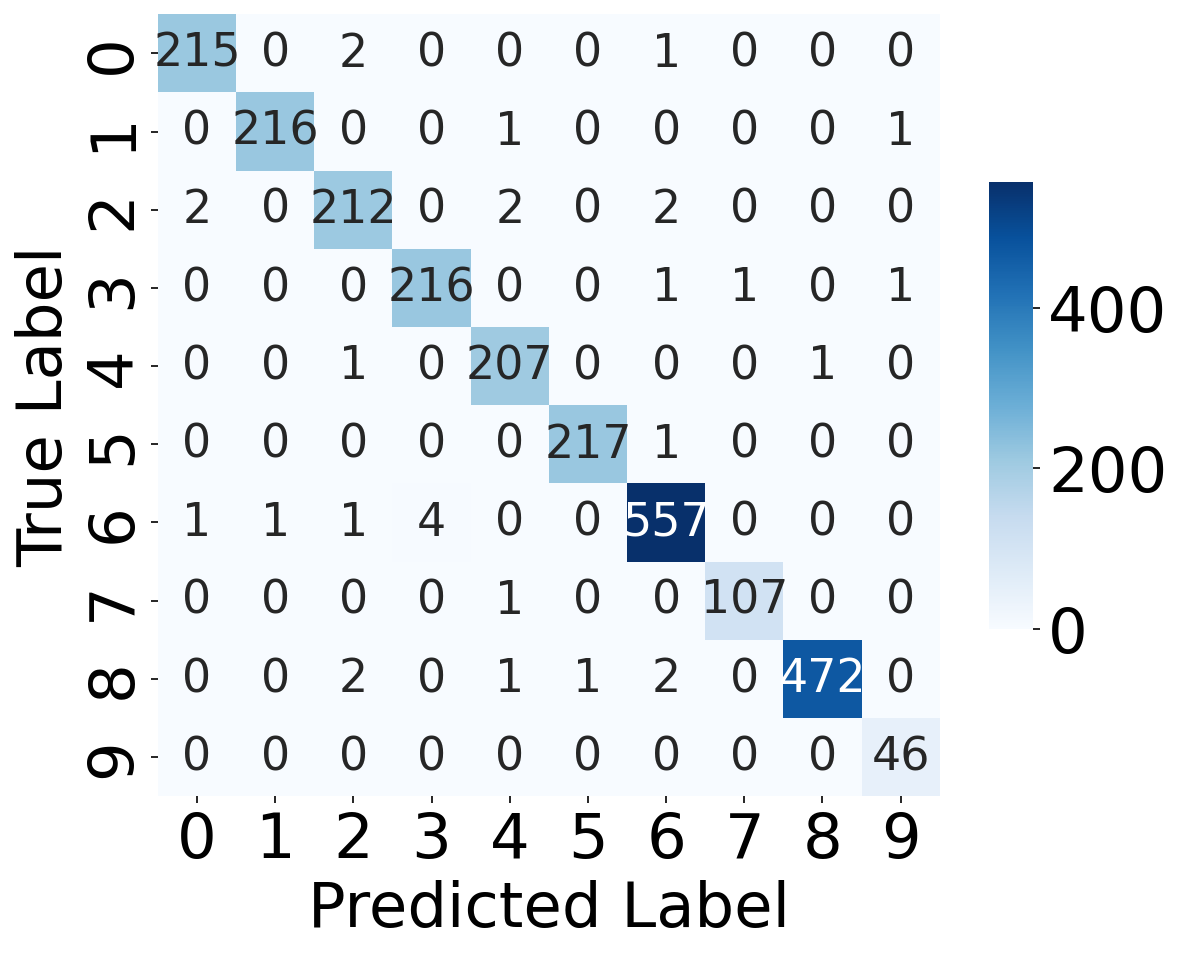

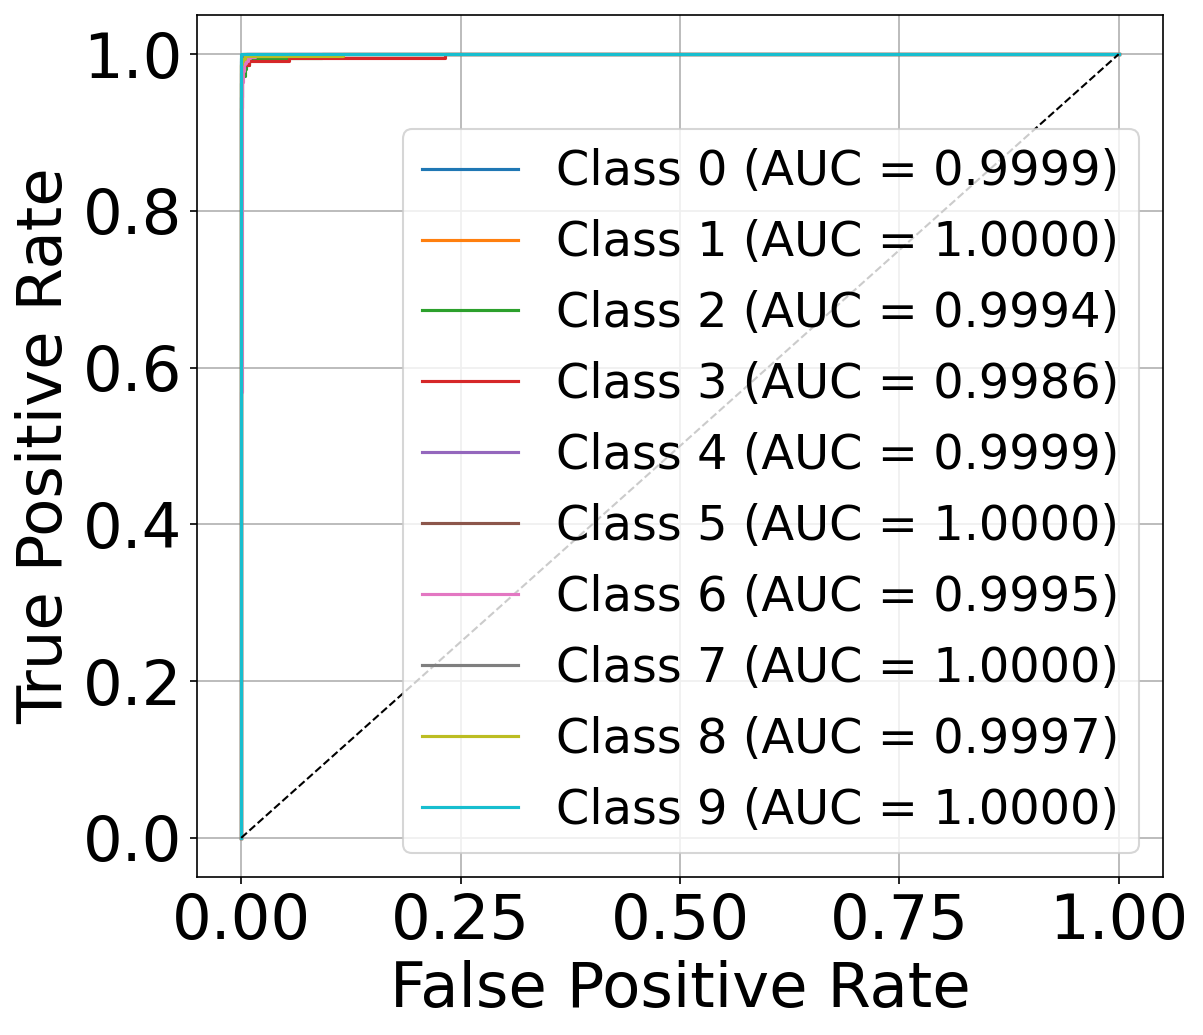

In [53]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# === 1. Load Best Fold Model ===
best_fold = 1  # Replace with the best fold number
model_path = f"best_model_fold{best_fold}.pth"

model = get_timm_model("xception71", num_classes=10)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# === 2. Run Inference on Test Set ===
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.argmax(all_probs, axis=1)

# === 3. Save Classification Report ===
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# === 4. Plot Confusion Matrix and ROC Curve ===
def plot_confusion_and_roc_separately(y_true, y_pred, y_prob, num_classes=10):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7), dpi=150)
    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=ax_cm,
        annot_kws={"size": 22},
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )
    ax_cm.set_xlabel('Predicted Label', fontsize=30)
    ax_cm.set_ylabel('True Label', fontsize=30)
    ax_cm.tick_params(labelsize=30)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    fig_roc, ax_roc = plt.subplots(figsize=(8, 7), dpi=150)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax_roc.set_xlabel('False Positive Rate', fontsize=30)
    ax_roc.set_ylabel('True Positive Rate', fontsize=30)
    ax_roc.tick_params(labelsize=30)
    ax_roc.legend(loc='lower right', fontsize=23)
    ax_roc.grid(True)
    plt.tight_layout()
    plt.show()

# === Call Plotting Function ===
plot_confusion_and_roc_separately(all_labels, all_preds, all_probs, num_classes=10)


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_loss_accuracy(cv_history, num_epochs):
    train_loss_all = np.array(cv_history['train_loss'])  # Shape: (folds, epochs)
    val_loss_all   = np.array(cv_history['val_loss'])
    train_acc_all  = np.array(cv_history['train_acc'])
    val_acc_all    = np.array(cv_history['val_acc'])

    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss   = np.mean(val_loss_all, axis=0)
    avg_train_acc  = np.mean(train_acc_all, axis=0)
    avg_val_acc    = np.mean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average Loss Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Average Accuracy Over Epochs (Across Folds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_loss_accuracy(cv_history, num_epochs):
    train_loss_all = np.array(cv_history['train_loss'])  # Shape: (folds, epochs)
    val_loss_all   = np.array(cv_history['val_loss'])
    train_acc_all  = np.array(cv_history['train_acc'])
    val_acc_all    = np.array(cv_history['val_acc'])

    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss   = np.mean(val_loss_all, axis=0)
    avg_train_acc  = np.mean(train_acc_all, axis=0)
    avg_val_acc    = np.mean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(8, 9))  # Square figure
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title("Average Loss Over Epochs (Across Folds)", fontsize=20)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(8, 9))  # Square figure
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy (%)", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title("Average Accuracy Over Epochs (Across Folds)", fontsize=20)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


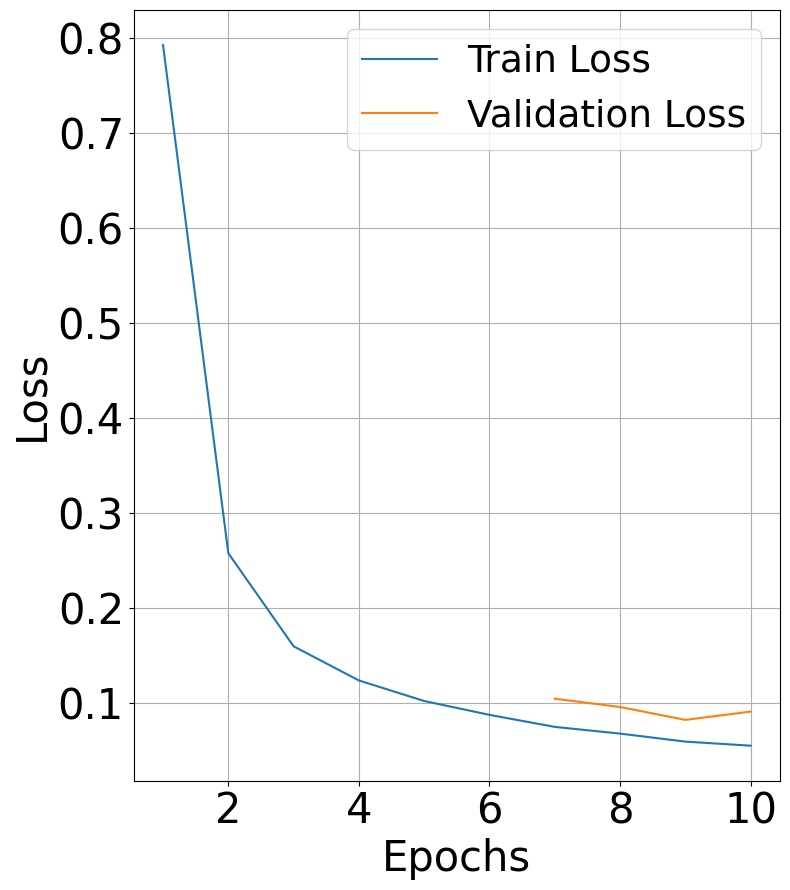

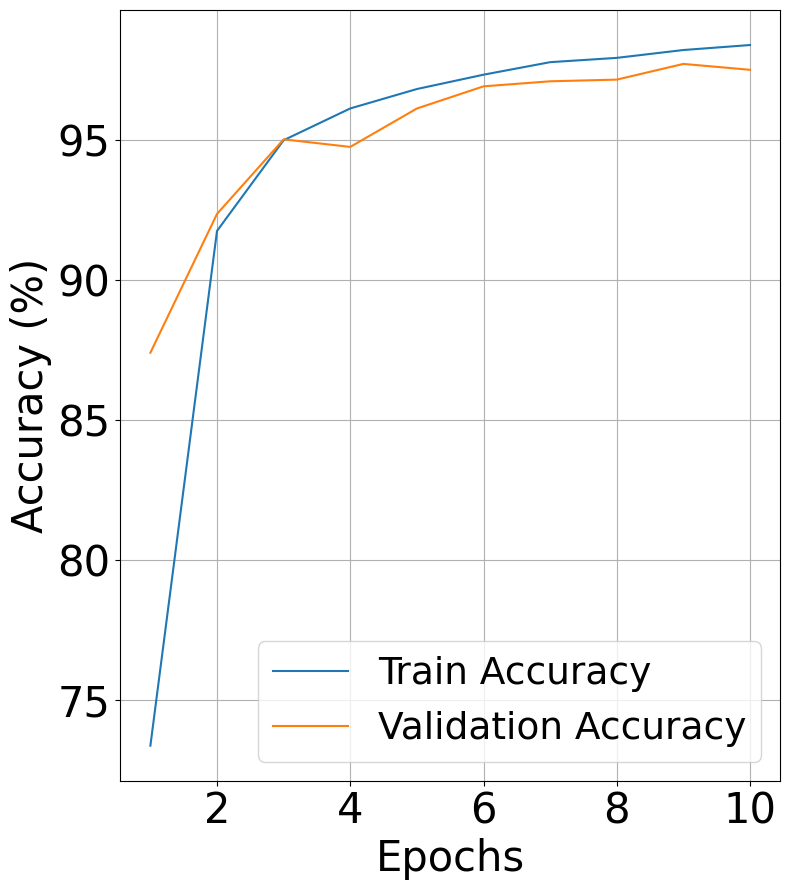

=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.5531           97.4975      0.0527    0.0877   
1   Fold 2             98.4085           96.9970      0.0540    0.1120   
2   Fold 3             98.2972           98.2983      0.0546    0.0610   
3   Fold 4             98.4752           97.0971      0.0561    0.1186   
4   Fold 5             98.1861           98.2966      0.0613    0.0617   
5   Fold 6             98.4198           97.8958      0.0513    0.0978   
6   Fold 7             98.0859           98.5972      0.0609    0.0476   
7   Fold 8             98.3975           97.2946      0.0550    0.1059   
8   Fold 9             98.5644           94.4890      0.0497    0.1775   
9  Fold 10             98.5199           98.5972      0.0504    0.0350   

   Val Macro F1  
0        0.9754  
1        0.9701  
2        0.9828  
3        0.9689  
4        0.9828  
5        0.9771  
6        0.9833  
7        0.9744 

In [30]:
# Step 3: Plot average loss and accuracy over epochs
plot_avg_loss_accuracy(cv_history, num_epochs=10)

# Step 4: Plot confusion matrix and ROC for best fold only
best_fold_idx = summary_df['Val Macro F1'].idxmax()
best_fold_preds = fold_preds[best_fold_idx]  # (y_true, y_pred, fold)


# Step 5: Print summary
print("=== Per-Fold Summary ===")
print(summary_df.round(4))


In [54]:
from sklearn.metrics import classification_report

# Step 1: Get index of best fold (highest macro F1)
best_fold_idx = summary_df['Val Macro F1'].idxmax()
best_y_true, best_y_pred, best_fold = fold_preds[best_fold_idx]

# Step 2: Print best fold number
print(f"\nBest fold is Fold {best_fold + 1}\n")

# Step 3: Print classification report
print("=== Classification Report ===")
print(classification_report(best_y_true, best_y_pred, digits=4))



Best fold is Fold 10

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9886    1.0000    0.9943        87
           1     1.0000    0.9886    0.9943        88
           2     0.9255    1.0000    0.9613        87
           3     0.9773    0.9885    0.9829        87
           4     1.0000    0.9524    0.9756        84
           5     1.0000    1.0000    1.0000        87
           6     0.9911    0.9823    0.9867       226
           7     1.0000    1.0000    1.0000        43
           8     0.9947    0.9791    0.9868       191
           9     0.9474    1.0000    0.9730        18

    accuracy                         0.9860       998
   macro avg     0.9825    0.9891    0.9855       998
weighted avg     0.9865    0.9860    0.9860       998



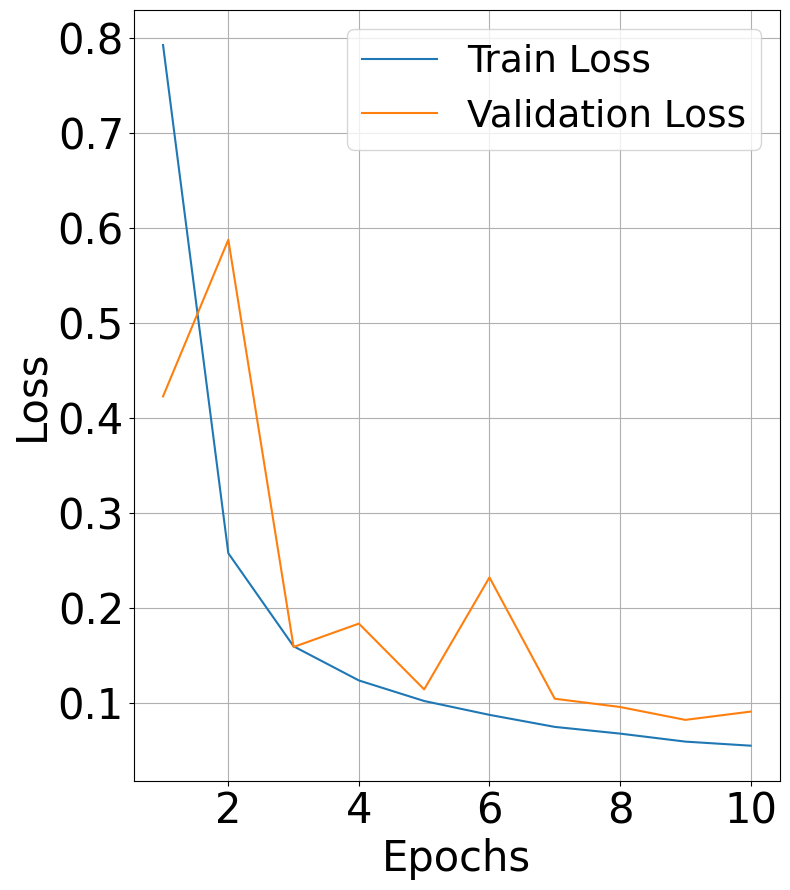

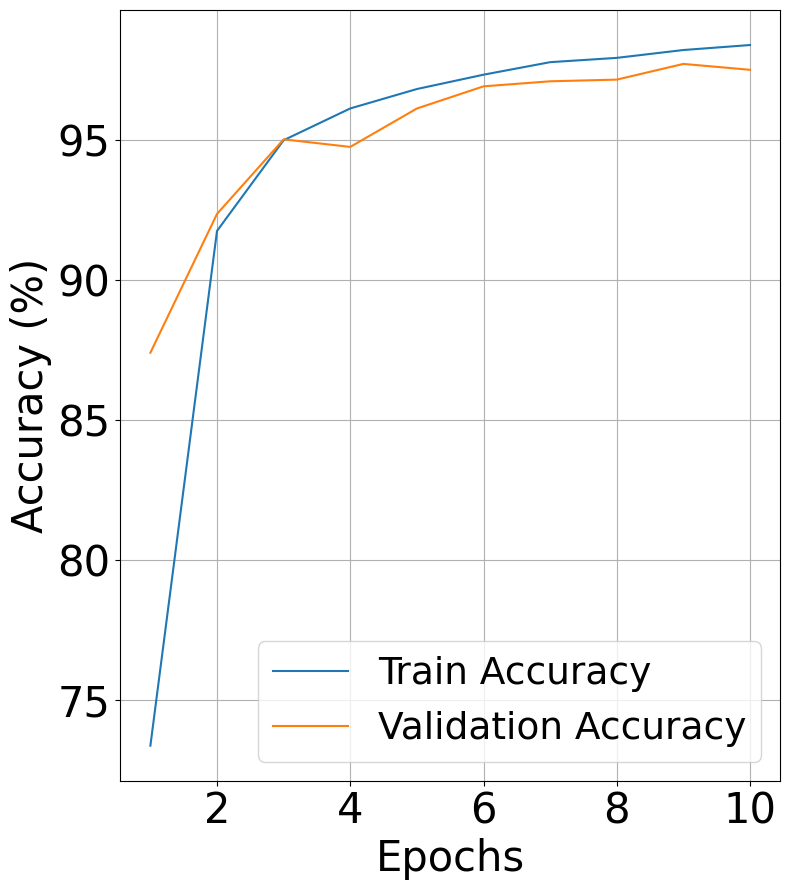

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def pad_sequences_to_length(seq_list, target_len):
    return [seq + [np.nan] * (target_len - len(seq)) if len(seq) < target_len else seq for seq in seq_list]

def plot_avg_loss_accuracy(cv_history, num_epochs=10):
    # Pad folds with missing epochs
    train_loss_all = np.array(pad_sequences_to_length(cv_history['train_loss'], num_epochs))
    val_loss_all   = np.array(pad_sequences_to_length(cv_history['val_loss'], num_epochs))
    train_acc_all  = np.array(pad_sequences_to_length(cv_history['train_acc'], num_epochs))
    val_acc_all    = np.array(pad_sequences_to_length(cv_history['val_acc'], num_epochs))

    # Compute average while ignoring NaNs
    avg_train_loss = np.nanmean(train_loss_all, axis=0)
    avg_val_loss   = np.nanmean(val_loss_all, axis=0)
    avg_train_acc  = np.nanmean(train_acc_all, axis=0)
    avg_val_acc    = np.nanmean(val_acc_all, axis=0)

    # === Plot Loss ===
    plt.figure(figsize=(8, 9))
    plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), avg_val_loss, label='Validation Loss')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(8, 9))
    plt.plot(range(1, num_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), avg_val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy (%)", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=27)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Step 3: Plot average loss and accuracy over epochs
plot_avg_loss_accuracy(cv_history, num_epochs=10)

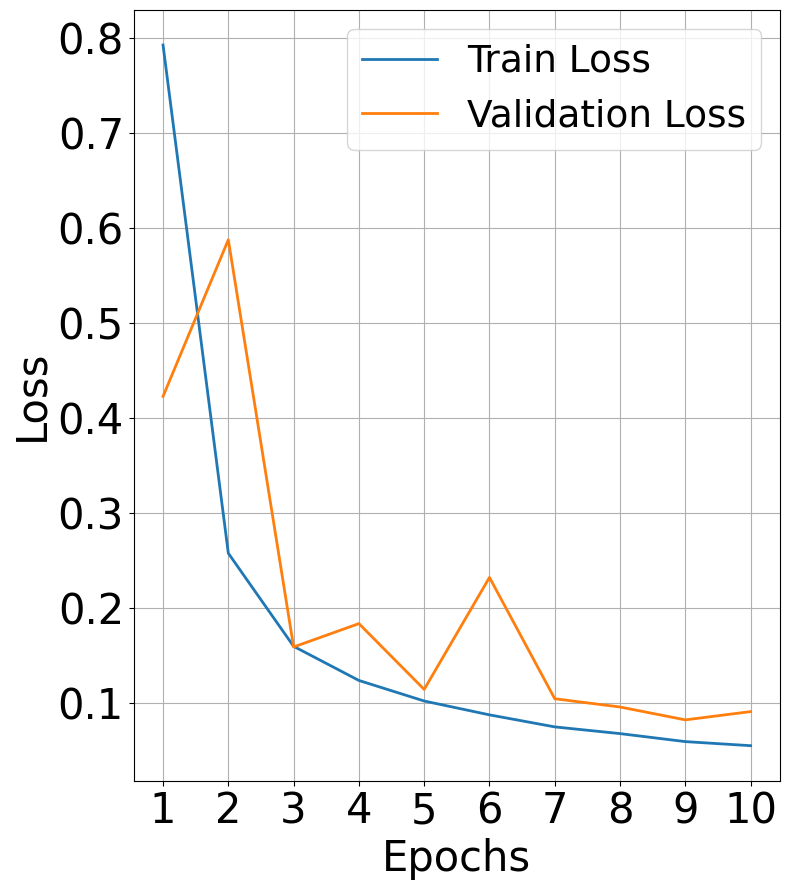

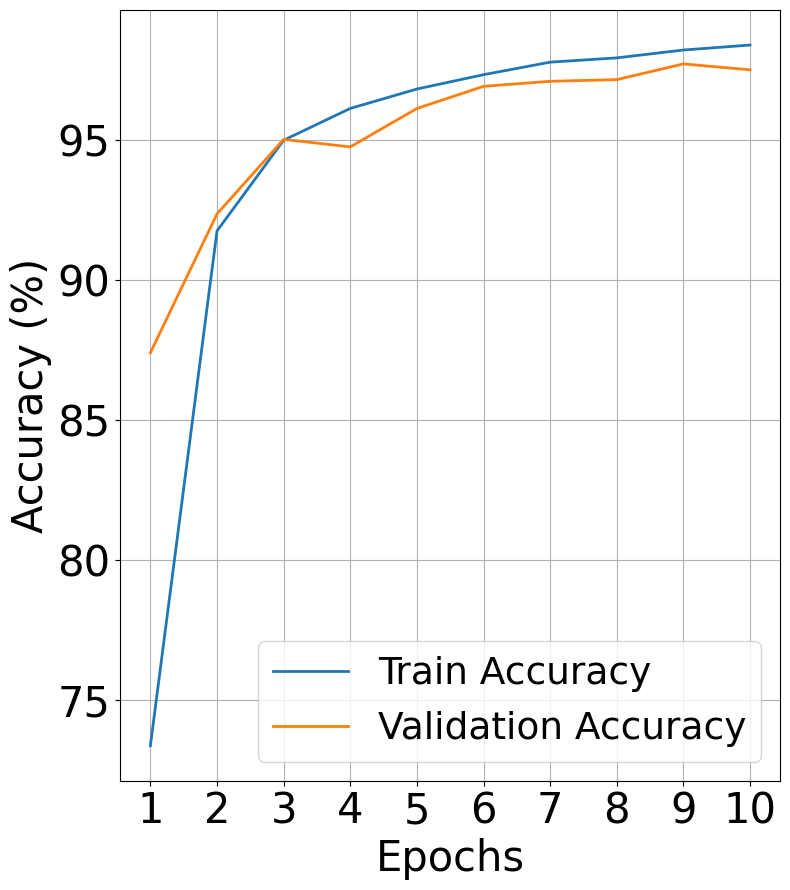

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def pad_sequences_to_length(sequences, target_len):
    """Pads each list in sequences to target_len with NaNs."""
    return [seq + [np.nan] * (target_len - len(seq)) if len(seq) < target_len else seq for seq in sequences]

def plot_avg_loss_accuracy(cv_history, num_epochs=10):
    """
    Plots average loss and accuracy over epochs across folds.
    Handles missing epochs by padding with NaN and masking in averages.
    """

    # === Pad metrics to uniform length ===
    train_loss_all = np.array(pad_sequences_to_length(cv_history['train_loss'], num_epochs))
    val_loss_all   = np.array(pad_sequences_to_length(cv_history['val_loss'], num_epochs))
    train_acc_all  = np.array(pad_sequences_to_length(cv_history['train_acc'], num_epochs))
    val_acc_all    = np.array(pad_sequences_to_length(cv_history['val_acc'], num_epochs))

    # === Compute mean across folds (ignoring NaNs) ===
    avg_train_loss = np.nanmean(train_loss_all, axis=0)
    avg_val_loss   = np.nanmean(val_loss_all, axis=0)
    avg_train_acc  = np.nanmean(train_acc_all, axis=0)
    avg_val_acc    = np.nanmean(val_acc_all, axis=0)

    # === Epoch axis ===
    epochs = np.arange(1, num_epochs + 1)

    # === Plot Loss ===
    plt.figure(figsize=(8, 9))
    plt.plot(epochs, avg_train_loss, label='Train Loss', linewidth=2)
    plt.plot(epochs, avg_val_loss, label='Validation Loss', linewidth=2)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Loss", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.legend(fontsize=27)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    plt.figure(figsize=(8, 9))
    plt.plot(epochs, avg_train_acc, label='Train Accuracy', linewidth=2)
    plt.plot(epochs, avg_val_acc, label='Validation Accuracy', linewidth=2)
    plt.xlabel("Epochs", fontsize=30)
    plt.ylabel("Accuracy (%)", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.legend(fontsize=27)
    plt.tight_layout()
    plt.show()



# Step 3: Plot average loss and accuracy over epochs
plot_avg_loss_accuracy(cv_history, num_epochs=10)

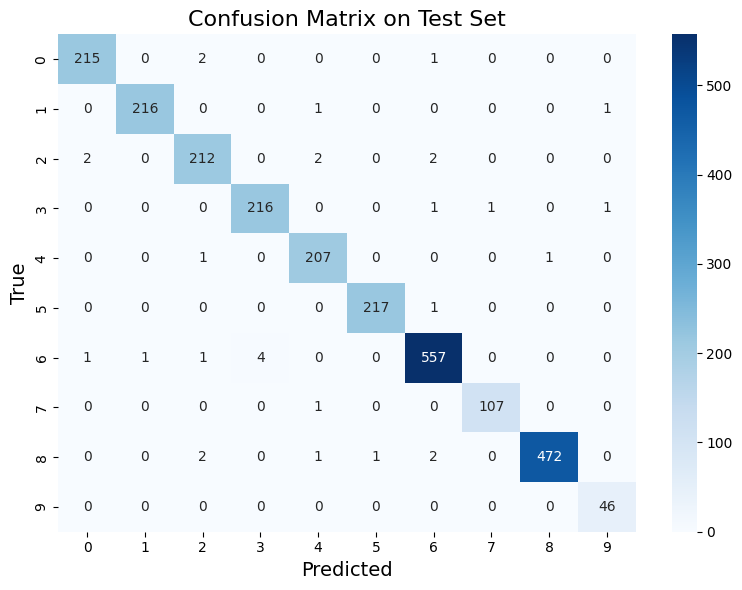

In [52]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Load Best Fold Model ===
best_fold = 1  # Replace with the best fold number
model_path = f"best_model_fold{best_fold}.pth"

model = get_timm_model("xception71", num_classes=10)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# === 2. Run Inference on Test Set ===
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# === 3. Save Classification Report ===
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# === 4. Plot Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix on Test Set", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# from collections import defaultdict

# cv_history = defaultdict(list)  # Stores per-epoch lists for all metrics
# summary_table = []
# fold_preds = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#     print(f"\n--- Fold {fold + 1} ---")

#     # === Prepare Train/Val Data ===
#     X_train = [X_trainval[i] for i in train_idx]
#     y_train = [y_trainval[i] for i in train_idx]
#     X_val   = [X_trainval[i] for i in val_idx]
#     y_val   = [y_trainval[i] for i in val_idx]

#     # === Weighted Sampler ===
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#     sample_weights = [weight_map[y] for y in y_train]
#     sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#     # === DataLoaders ===
#     train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
#     val_dataset   = DeltaSTFTDataset(X_val, y_val, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
#     val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

#     # === Model, Loss, Optimizer ===
#     num_classes = 10
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = get_timm_model("xception71", num_classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#     # === Train Model ===
#     history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

#     # === Store full per-epoch history in cv_history ===
#     for metric_name, epoch_values in history.items():
#         cv_history[metric_name].append(epoch_values)

#     # === Recompute predictions for classification report (optional) ===
#     model.eval()
#     y_true, y_pred = [], []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             outputs = model(X_batch)
#             _, preds = torch.max(outputs, 1)
#             y_true.extend(y_batch.numpy())
#             y_pred.extend(preds.cpu().numpy())
#     fold_preds.append((y_true, y_pred, fold))

#     # === Add to summary table (final epoch stats) ===
#     summary_table.append({
#         "Fold": f"Fold {fold+1}",
#         "Train Accuracy (%)": history['train_acc'][-1],
#         "Val Accuracy (%)": history['val_acc'][-1],
#         "Train Loss": history['train_loss'][-1],
#         "Val Loss": history['val_loss'][-1],
#         "Val Macro F1": f1_score(y_true, y_pred, average='macro')
#     })

#     # === Cleanup ===
#     del model
#     torch.cuda.empty_cache()
#     gc.collect()

# # === Convert summary table to DataFrame for printing ===
# summary_df = pd.DataFrame(summary_table)



--- Fold 1 ---


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.67 GiB of which 49.25 MiB is free. Process 2479 has 132.68 MiB memory in use. Process 8047 has 2.34 GiB memory in use. Including non-PyTorch memory, this process has 4.77 GiB memory in use. Of the allocated memory 4.47 GiB is allocated by PyTorch, and 139.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Identify the best fold using validation F1 macro
best_fold = np.argmax(cv_history['val_f1_macro'])

# Load the best model
model = get_timm_model("xception71", num_classes).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model.eval()

# Evaluate on test set
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9876
Macro F1-score : 0.9874

Classification Report:
               precision    recall  f1-score   support

           0     0.9863    0.9908    0.9886       218
           1     1.0000    0.9908    0.9954       218
           2     0.9907    0.9725    0.9815       218
           3     1.0000    0.9909    0.9954       219
           4     0.9630    0.9952    0.9788       209
           5     0.9909    1.0000    0.9954       218
           6     0.9858    0.9823    0.9840       564
           7     0.9813    0.9722    0.9767       108
           8     0.9875    0.9916    0.9896       478
           9     1.0000    0.9783    0.9890        46

    accuracy                         0.9876      2496
   macro avg     0.9885    0.9865    0.9874      2496
weighted avg     0.9877    0.9876    0.9876      2496



In [32]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)




=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.0095           94.7948      0.0360    0.1821   
1   Fold 2             98.6644           99.2993      0.0432    0.0271   
2   Fold 3             98.6533           96.6967      0.0444    0.1226   
3   Fold 4             98.8759           98.0981      0.0392    0.0728   
4   Fold 5             98.8315           97.9960      0.0404    0.0694   
5   Fold 6             98.3419           97.9960      0.0564    0.0778   
6   Fold 7             98.7870           98.1964      0.0401    0.0542   
7   Fold 8             98.9762           97.0942      0.0328    0.1284   
8   Fold 9             99.2433           97.6954      0.0257    0.0656   
9  Fold 10             99.1876           98.9980      0.0309    0.0464   

   Val Macro F1  
0        0.9541  
1        0.9944  
2        0.9644  
3        0.9801  
4        0.9784  
5        0.9735  
6        0.9818  
7        0.9593

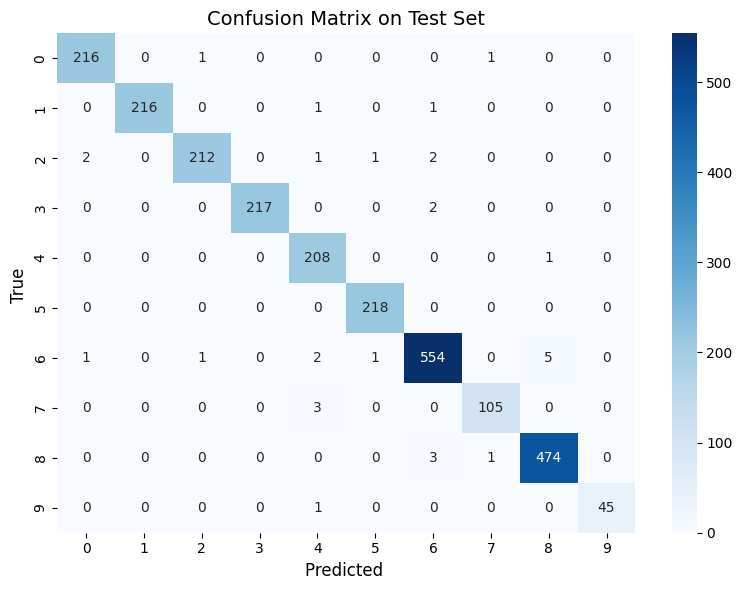

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

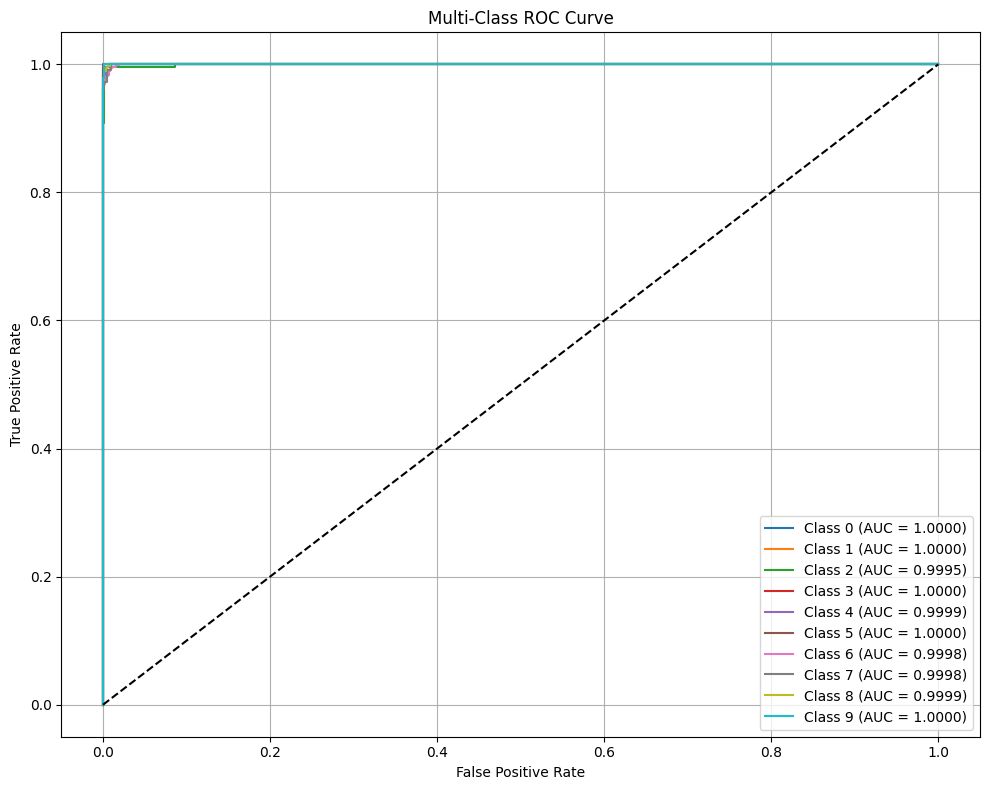

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Model training:  Deit_tiny_patch16_224

In [48]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model


In [49]:
def get_deit_tiny_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("deit_tiny_patch16_224", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [50]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            #with autocast():
            with autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #with torch.no_grad(), autocast():
            with torch.no_grad(), autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [51]:
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Model + optimizer
    num_classes = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = get_timm_model("xception71", num_classes).to(device)
    model = get_timm_model("deit_tiny_patch16_224", num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


    # Train
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Save final metrics (last epoch)
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.24it/s] 


Epoch 1: Train Loss=0.8838, Val Loss=0.3538, Train Acc=68.88%, Val Acc=87.49%, Val F1-Macro=0.8795


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.20it/s] 


Epoch 2: Train Loss=0.2086, Val Loss=0.2533, Train Acc=92.98%, Val Acc=91.79%, Val F1-Macro=0.9181


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.89it/s] 


Epoch 3: Train Loss=0.1267, Val Loss=0.1545, Train Acc=95.77%, Val Acc=94.59%, Val F1-Macro=0.9495


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.77it/s] 


Epoch 4: Train Loss=0.0711, Val Loss=0.1747, Train Acc=97.67%, Val Acc=93.69%, Val F1-Macro=0.9407


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.45it/s] 


Epoch 5: Train Loss=0.0810, Val Loss=0.1016, Train Acc=97.61%, Val Acc=96.50%, Val F1-Macro=0.9693


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.43it/s] 


Epoch 6: Train Loss=0.0664, Val Loss=0.1561, Train Acc=97.95%, Val Acc=94.99%, Val F1-Macro=0.9530


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.92it/s] 


Epoch 7: Train Loss=0.0546, Val Loss=0.1194, Train Acc=98.38%, Val Acc=96.50%, Val F1-Macro=0.9665


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.98it/s] 


Epoch 8: Train Loss=0.0416, Val Loss=0.1643, Train Acc=98.80%, Val Acc=95.10%, Val F1-Macro=0.9548


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.52it/s] 


Epoch 9: Train Loss=0.0552, Val Loss=0.0576, Train Acc=98.40%, Val Acc=98.30%, Val F1-Macro=0.9852


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.57it/s] 


Epoch 10: Train Loss=0.0322, Val Loss=0.0965, Train Acc=99.14%, Val Acc=96.80%, Val F1-Macro=0.9738

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.41it/s] 


Epoch 1: Train Loss=0.7430, Val Loss=0.3080, Train Acc=74.54%, Val Acc=90.69%, Val F1-Macro=0.9166


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.42it/s] 


Epoch 2: Train Loss=0.1543, Val Loss=0.2041, Train Acc=94.66%, Val Acc=92.89%, Val F1-Macro=0.9369


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.13it/s] 


Epoch 3: Train Loss=0.1023, Val Loss=0.1104, Train Acc=96.77%, Val Acc=96.20%, Val F1-Macro=0.9663


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.53it/s] 


Epoch 4: Train Loss=0.0733, Val Loss=0.2123, Train Acc=97.53%, Val Acc=93.09%, Val F1-Macro=0.9355


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.05it/s] 


Epoch 5: Train Loss=0.0671, Val Loss=0.0730, Train Acc=98.02%, Val Acc=97.60%, Val F1-Macro=0.9747


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.96it/s] 


Epoch 6: Train Loss=0.0491, Val Loss=0.1317, Train Acc=98.38%, Val Acc=95.80%, Val F1-Macro=0.9636


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.41it/s] 


Epoch 7: Train Loss=0.0621, Val Loss=0.1509, Train Acc=98.15%, Val Acc=95.10%, Val F1-Macro=0.9509


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.15it/s] 


Epoch 8: Train Loss=0.0354, Val Loss=0.0757, Train Acc=98.81%, Val Acc=97.70%, Val F1-Macro=0.9803


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.37it/s] 


Epoch 9: Train Loss=0.0361, Val Loss=0.0623, Train Acc=99.01%, Val Acc=98.10%, Val F1-Macro=0.9815


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.84it/s] 


Epoch 10: Train Loss=0.0537, Val Loss=0.0894, Train Acc=98.33%, Val Acc=96.90%, Val F1-Macro=0.9729

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.60it/s] 


Epoch 1: Train Loss=0.7131, Val Loss=0.3082, Train Acc=75.46%, Val Acc=88.89%, Val F1-Macro=0.8973


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.47it/s] 


Epoch 2: Train Loss=0.1869, Val Loss=0.3235, Train Acc=93.89%, Val Acc=88.99%, Val F1-Macro=0.8990


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.68it/s] 


Epoch 3: Train Loss=0.1198, Val Loss=0.2011, Train Acc=96.28%, Val Acc=93.29%, Val F1-Macro=0.9423


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.50it/s] 


Epoch 4: Train Loss=0.0693, Val Loss=0.1168, Train Acc=97.89%, Val Acc=95.90%, Val F1-Macro=0.9620


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.90it/s] 


Epoch 5: Train Loss=0.0629, Val Loss=0.1476, Train Acc=98.02%, Val Acc=95.10%, Val F1-Macro=0.9524


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.19it/s] 


Epoch 6: Train Loss=0.0664, Val Loss=0.0896, Train Acc=98.09%, Val Acc=97.40%, Val F1-Macro=0.9719


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.98it/s] 


Epoch 7: Train Loss=0.0354, Val Loss=0.2023, Train Acc=98.90%, Val Acc=93.99%, Val F1-Macro=0.9416


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.86it/s] 


Epoch 8: Train Loss=0.0591, Val Loss=0.1453, Train Acc=98.26%, Val Acc=96.00%, Val F1-Macro=0.9612


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.34it/s] 


Epoch 9: Train Loss=0.0658, Val Loss=0.1373, Train Acc=98.13%, Val Acc=94.79%, Val F1-Macro=0.9542


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.99it/s] 


Epoch 10: Train Loss=0.0354, Val Loss=0.1357, Train Acc=98.92%, Val Acc=95.90%, Val F1-Macro=0.9638

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.71it/s] 


Epoch 1: Train Loss=0.7504, Val Loss=0.4220, Train Acc=73.96%, Val Acc=84.58%, Val F1-Macro=0.8603


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.62it/s] 


Epoch 2: Train Loss=0.1921, Val Loss=0.2922, Train Acc=93.72%, Val Acc=91.49%, Val F1-Macro=0.9146


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.66it/s] 


Epoch 3: Train Loss=0.1103, Val Loss=0.2056, Train Acc=96.41%, Val Acc=93.09%, Val F1-Macro=0.9387


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.98it/s] 


Epoch 4: Train Loss=0.0831, Val Loss=0.1320, Train Acc=97.20%, Val Acc=96.10%, Val F1-Macro=0.9601


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.75it/s] 


Epoch 5: Train Loss=0.0661, Val Loss=0.1830, Train Acc=97.85%, Val Acc=94.09%, Val F1-Macro=0.9451


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.99it/s] 


Epoch 6: Train Loss=0.0557, Val Loss=0.1124, Train Acc=98.12%, Val Acc=96.20%, Val F1-Macro=0.9578


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.93it/s] 


Epoch 7: Train Loss=0.0593, Val Loss=0.1148, Train Acc=97.97%, Val Acc=97.10%, Val F1-Macro=0.9725


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.11it/s] 


Epoch 8: Train Loss=0.0497, Val Loss=0.0842, Train Acc=98.51%, Val Acc=97.30%, Val F1-Macro=0.9763


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.07it/s] 


Epoch 9: Train Loss=0.0487, Val Loss=0.0914, Train Acc=98.38%, Val Acc=97.50%, Val F1-Macro=0.9758


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.15it/s] 


Epoch 10: Train Loss=0.0393, Val Loss=0.0642, Train Acc=98.84%, Val Acc=98.50%, Val F1-Macro=0.9858

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.51it/s] 


Epoch 1: Train Loss=0.8625, Val Loss=0.4204, Train Acc=68.77%, Val Acc=86.97%, Val F1-Macro=0.8820


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.42it/s] 


Epoch 2: Train Loss=0.1938, Val Loss=0.2384, Train Acc=93.53%, Val Acc=91.48%, Val F1-Macro=0.9192


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.65it/s] 


Epoch 3: Train Loss=0.1099, Val Loss=0.1896, Train Acc=96.28%, Val Acc=93.19%, Val F1-Macro=0.9398


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.05it/s] 


Epoch 4: Train Loss=0.0909, Val Loss=0.1413, Train Acc=97.23%, Val Acc=95.59%, Val F1-Macro=0.9513


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.46it/s] 


Epoch 5: Train Loss=0.0566, Val Loss=0.2873, Train Acc=98.16%, Val Acc=91.88%, Val F1-Macro=0.9021


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.05it/s] 


Epoch 6: Train Loss=0.0514, Val Loss=0.1180, Train Acc=98.34%, Val Acc=96.49%, Val F1-Macro=0.9617


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.59it/s] 


Epoch 7: Train Loss=0.0703, Val Loss=0.0758, Train Acc=97.61%, Val Acc=97.39%, Val F1-Macro=0.9670


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.07it/s] 


Epoch 8: Train Loss=0.0440, Val Loss=0.0607, Train Acc=98.66%, Val Acc=97.70%, Val F1-Macro=0.9755


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.10it/s] 


Epoch 9: Train Loss=0.0306, Val Loss=0.1472, Train Acc=99.09%, Val Acc=95.49%, Val F1-Macro=0.9495


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.11it/s] 


Epoch 10: Train Loss=0.0390, Val Loss=0.1236, Train Acc=98.97%, Val Acc=96.29%, Val F1-Macro=0.9609

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.91it/s] 


Epoch 1: Train Loss=0.9312, Val Loss=0.3699, Train Acc=67.20%, Val Acc=86.77%, Val F1-Macro=0.8716


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.22it/s] 


Epoch 2: Train Loss=0.2227, Val Loss=0.2801, Train Acc=92.80%, Val Acc=90.38%, Val F1-Macro=0.9054


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.20it/s] 


Epoch 3: Train Loss=0.1129, Val Loss=0.1618, Train Acc=96.14%, Val Acc=94.09%, Val F1-Macro=0.9359


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.87it/s] 


Epoch 4: Train Loss=0.0864, Val Loss=0.1176, Train Acc=97.32%, Val Acc=95.99%, Val F1-Macro=0.9537


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.41it/s] 


Epoch 5: Train Loss=0.0691, Val Loss=0.1102, Train Acc=97.84%, Val Acc=96.79%, Val F1-Macro=0.9670


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.34it/s] 


Epoch 6: Train Loss=0.0518, Val Loss=0.1510, Train Acc=98.30%, Val Acc=95.89%, Val F1-Macro=0.9622


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.01it/s] 


Epoch 7: Train Loss=0.0493, Val Loss=0.0971, Train Acc=98.50%, Val Acc=96.49%, Val F1-Macro=0.9642


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.66it/s] 


Epoch 8: Train Loss=0.0649, Val Loss=0.2607, Train Acc=97.80%, Val Acc=92.08%, Val F1-Macro=0.9189


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.26it/s] 


Epoch 9: Train Loss=0.0455, Val Loss=0.1076, Train Acc=98.56%, Val Acc=96.49%, Val F1-Macro=0.9662


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.83it/s] 


Epoch 10: Train Loss=0.0365, Val Loss=0.1422, Train Acc=98.91%, Val Acc=96.29%, Val F1-Macro=0.9620

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 76.07it/s] 


Epoch 1: Train Loss=0.7802, Val Loss=0.5052, Train Acc=73.17%, Val Acc=83.17%, Val F1-Macro=0.8344


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.75it/s] 


Epoch 2: Train Loss=0.2031, Val Loss=0.2929, Train Acc=93.39%, Val Acc=91.28%, Val F1-Macro=0.8922


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.15it/s] 


Epoch 3: Train Loss=0.1214, Val Loss=0.1560, Train Acc=95.89%, Val Acc=94.69%, Val F1-Macro=0.9450


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.20it/s] 


Epoch 4: Train Loss=0.0715, Val Loss=0.2103, Train Acc=97.56%, Val Acc=92.48%, Val F1-Macro=0.9263


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.69it/s] 


Epoch 5: Train Loss=0.0838, Val Loss=0.1181, Train Acc=97.41%, Val Acc=96.09%, Val F1-Macro=0.9614


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.23it/s] 


Epoch 6: Train Loss=0.0434, Val Loss=0.1123, Train Acc=98.71%, Val Acc=95.89%, Val F1-Macro=0.9563


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.12it/s] 


Epoch 7: Train Loss=0.0609, Val Loss=0.1679, Train Acc=98.23%, Val Acc=94.69%, Val F1-Macro=0.9534


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.70it/s] 


Epoch 8: Train Loss=0.0452, Val Loss=0.0920, Train Acc=98.41%, Val Acc=96.99%, Val F1-Macro=0.9698


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.93it/s] 


Epoch 9: Train Loss=0.0498, Val Loss=0.2673, Train Acc=98.30%, Val Acc=91.38%, Val F1-Macro=0.9155


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.81it/s] 


Epoch 10: Train Loss=0.0342, Val Loss=0.1191, Train Acc=98.90%, Val Acc=96.09%, Val F1-Macro=0.9642

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.23it/s] 


Epoch 1: Train Loss=0.7715, Val Loss=0.4634, Train Acc=72.42%, Val Acc=84.87%, Val F1-Macro=0.8667


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.06it/s] 


Epoch 2: Train Loss=0.1721, Val Loss=0.2393, Train Acc=94.24%, Val Acc=92.38%, Val F1-Macro=0.9256


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.96it/s] 


Epoch 3: Train Loss=0.1243, Val Loss=0.2013, Train Acc=96.03%, Val Acc=93.99%, Val F1-Macro=0.9491


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.27it/s] 


Epoch 4: Train Loss=0.0745, Val Loss=0.1407, Train Acc=97.59%, Val Acc=95.69%, Val F1-Macro=0.9618


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.59it/s] 


Epoch 5: Train Loss=0.0728, Val Loss=0.1822, Train Acc=97.66%, Val Acc=94.29%, Val F1-Macro=0.9466


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.92it/s] 


Epoch 6: Train Loss=0.0623, Val Loss=0.3552, Train Acc=98.09%, Val Acc=90.68%, Val F1-Macro=0.9066


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.56it/s] 


Epoch 7: Train Loss=0.0522, Val Loss=0.2146, Train Acc=98.41%, Val Acc=93.89%, Val F1-Macro=0.9497


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.30it/s] 


Epoch 8: Train Loss=0.0575, Val Loss=0.1531, Train Acc=98.26%, Val Acc=94.79%, Val F1-Macro=0.9550


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.69it/s] 


Epoch 9: Train Loss=0.0367, Val Loss=0.1334, Train Acc=98.98%, Val Acc=96.39%, Val F1-Macro=0.9719


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.30it/s] 


Epoch 10: Train Loss=0.0496, Val Loss=0.1393, Train Acc=98.55%, Val Acc=95.99%, Val F1-Macro=0.9643

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.97it/s] 


Epoch 1: Train Loss=0.7326, Val Loss=0.4988, Train Acc=74.53%, Val Acc=82.36%, Val F1-Macro=0.8238


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.31it/s] 


Epoch 2: Train Loss=0.1670, Val Loss=0.2424, Train Acc=94.55%, Val Acc=91.98%, Val F1-Macro=0.9175


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.41it/s] 


Epoch 3: Train Loss=0.1058, Val Loss=0.2755, Train Acc=96.76%, Val Acc=91.68%, Val F1-Macro=0.9127


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.50it/s] 


Epoch 4: Train Loss=0.0799, Val Loss=0.1794, Train Acc=97.50%, Val Acc=93.79%, Val F1-Macro=0.9366


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.98it/s] 


Epoch 5: Train Loss=0.0733, Val Loss=0.0904, Train Acc=97.62%, Val Acc=97.19%, Val F1-Macro=0.9645


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.09it/s] 


Epoch 6: Train Loss=0.0553, Val Loss=0.1475, Train Acc=98.22%, Val Acc=95.29%, Val F1-Macro=0.9607


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.30it/s] 


Epoch 7: Train Loss=0.0724, Val Loss=0.1645, Train Acc=97.77%, Val Acc=94.49%, Val F1-Macro=0.9419


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.24it/s] 


Epoch 8: Train Loss=0.0241, Val Loss=0.0913, Train Acc=99.21%, Val Acc=97.09%, Val F1-Macro=0.9705


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.28it/s] 


Epoch 9: Train Loss=0.0484, Val Loss=0.1864, Train Acc=98.54%, Val Acc=93.19%, Val F1-Macro=0.9338


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.67it/s] 


Epoch 10: Train Loss=0.0480, Val Loss=0.0865, Train Acc=98.45%, Val Acc=97.39%, Val F1-Macro=0.9719

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.53it/s] 


Epoch 1: Train Loss=0.7089, Val Loss=0.3112, Train Acc=75.43%, Val Acc=89.98%, Val F1-Macro=0.9029


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 80.27it/s] 


Epoch 2: Train Loss=0.1811, Val Loss=0.2694, Train Acc=93.90%, Val Acc=91.88%, Val F1-Macro=0.9255


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.39it/s] 


Epoch 3: Train Loss=0.1092, Val Loss=0.1145, Train Acc=96.46%, Val Acc=96.09%, Val F1-Macro=0.9625


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.07it/s] 


Epoch 4: Train Loss=0.0708, Val Loss=0.1457, Train Acc=97.80%, Val Acc=95.39%, Val F1-Macro=0.9511


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.30it/s] 


Epoch 5: Train Loss=0.0628, Val Loss=0.2503, Train Acc=97.94%, Val Acc=92.79%, Val F1-Macro=0.9290


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 79.18it/s] 


Epoch 6: Train Loss=0.0721, Val Loss=0.0835, Train Acc=97.76%, Val Acc=97.49%, Val F1-Macro=0.9729


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.84it/s] 


Epoch 7: Train Loss=0.0644, Val Loss=0.2003, Train Acc=98.05%, Val Acc=93.49%, Val F1-Macro=0.9406


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 78.38it/s] 


Epoch 8: Train Loss=0.0531, Val Loss=0.1725, Train Acc=98.39%, Val Acc=93.99%, Val F1-Macro=0.9463


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 76.59it/s] 


Epoch 9: Train Loss=0.0222, Val Loss=0.0777, Train Acc=99.34%, Val Acc=97.49%, Val F1-Macro=0.9755


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 77.53it/s] 

Epoch 10: Train Loss=0.0625, Val Loss=0.1111, Train Acc=98.17%, Val Acc=96.29%, Val F1-Macro=0.9632


In [53]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Identify the best fold using validation F1 macro
best_fold = np.argmax(cv_history['val_f1_macro'])

# Load the best model
model = get_timm_model("deit_tiny_patch16_224", num_classes).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model.eval()

# Evaluate on test set
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9812
Macro F1-score : 0.9841

Classification Report:
               precision    recall  f1-score   support

           0     0.9641    0.9862    0.9751       218
           1     0.9953    0.9633    0.9790       218
           2     0.9859    0.9633    0.9745       218
           3     0.9908    0.9817    0.9862       219
           4     0.9856    0.9809    0.9832       209
           5     0.9864    0.9954    0.9909       218
           6     0.9639    0.9929    0.9782       564
           7     1.0000    0.9907    0.9953       108
           8     0.9872    0.9707    0.9789       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9812      2496
   macro avg     0.9859    0.9825    0.9841      2496
weighted avg     0.9814    0.9812    0.9812      2496



In [54]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)




=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.1430           96.7968      0.0322    0.0965   
1   Fold 2             98.3306           96.8969      0.0537    0.0894   
2   Fold 3             98.9204           95.8959      0.0354    0.1357   
3   Fold 4             98.8425           98.4985      0.0393    0.0642   
4   Fold 5             98.9651           96.2926      0.0390    0.1236   
5   Fold 6             98.9094           96.2926      0.0365    0.1422   
6   Fold 7             98.8983           96.0922      0.0342    0.1191   
7   Fold 8             98.5533           95.9920      0.0496    0.1393   
8   Fold 9             98.4531           97.3948      0.0480    0.0865   
9  Fold 10             98.1749           96.2926      0.0625    0.1111   

   Val Macro F1  
0        0.9738  
1        0.9729  
2        0.9638  
3        0.9858  
4        0.9609  
5        0.9620  
6        0.9642  
7        0.9643

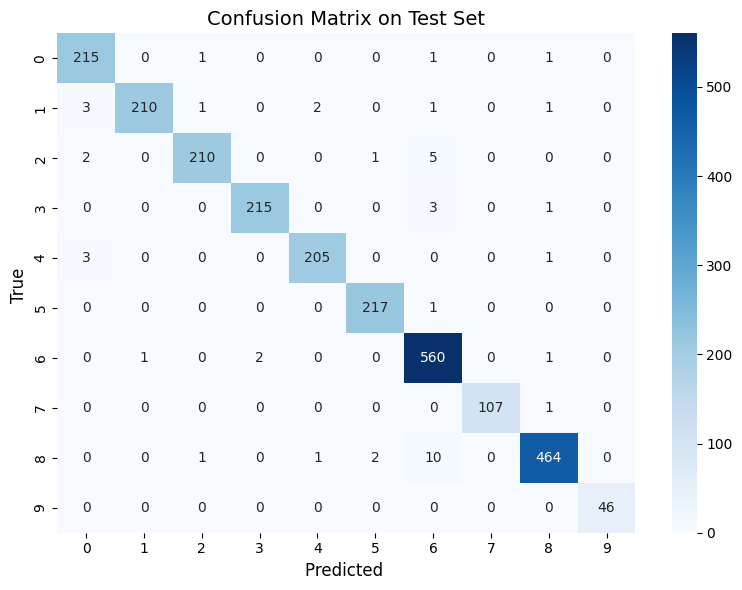

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

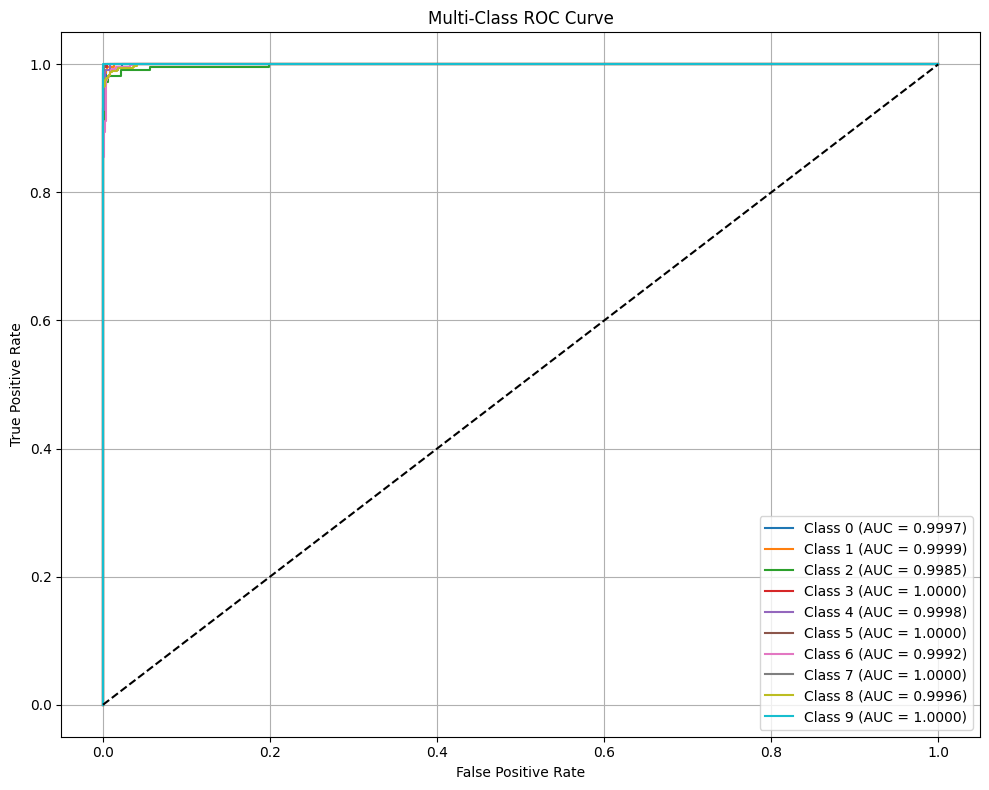

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Model Training: Efficient Net V2 M

In [18]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)

    # Replace classification head
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head') and hasattr(model.head, 'fc'):
        in_features = model.head.fc.in_features
        model.head.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [19]:
def get_effnetv2_m_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("tf_efficientnetv2_m.in21k_ft_in1k", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            #with autocast():
            with autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #with torch.no_grad(), autocast():
            with torch.no_grad(), autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [21]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [22]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()


296

In [25]:
from collections import defaultdict
import gc
import torch

cv_history = defaultdict(list)  # Stores per-epoch lists for all metrics
summary_table = []
fold_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # === Clear GPU memory before new model setup ===
    torch.cuda.empty_cache()
    gc.collect()

    # === Prepare Train/Val Data ===
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val   = [X_trainval[i] for i in val_idx]
    y_val   = [y_trainval[i] for i in val_idx]

    # === Weighted Sampler ===
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # === DataLoaders ===
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset   = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # === Model, Loss, Optimizer ===
    num_classes = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("tf_efficientnetv2_m.in21k_ft_in1k", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # === Train Model ===
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # === Store full per-epoch history in cv_history ===
    for metric_name, epoch_values in history.items():
        cv_history[metric_name].append(epoch_values)

    # === Recompute predictions for classification report (optional) ===
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.cpu().numpy())
    fold_preds.append((y_true, y_pred, fold))

    # === Add to summary table (final epoch stats) ===
    summary_table.append({
        "Fold": f"Fold {fold+1}",
        "Train Accuracy (%)": history['train_acc'][-1],
        "Val Accuracy (%)": history['val_acc'][-1],
        "Train Loss": history['train_loss'][-1],
        "Val Loss": history['val_loss'][-1],
        "Val Macro F1": f1_score(y_true, y_pred, average='macro')
    })

    # === Cleanup ===
    del model
    torch.cuda.empty_cache()
    gc.collect()

# === Convert summary table to DataFrame for printing ===
summary_df = pd.DataFrame(summary_table)



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.39it/s]


Epoch 1: Train Loss=0.6472, Val Loss=0.2854, Train Acc=78.86%, Val Acc=89.89%, Val F1-Macro=0.9060


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.07it/s]


Epoch 2: Train Loss=0.1835, Val Loss=0.1525, Train Acc=94.51%, Val Acc=95.50%, Val F1-Macro=0.9638


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.09it/s]


Epoch 3: Train Loss=0.1161, Val Loss=0.1453, Train Acc=96.53%, Val Acc=96.40%, Val F1-Macro=0.9671


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.02it/s]


Epoch 4: Train Loss=0.0930, Val Loss=0.1437, Train Acc=97.23%, Val Acc=95.90%, Val F1-Macro=0.9659


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.66it/s]


Epoch 5: Train Loss=0.0622, Val Loss=0.0715, Train Acc=98.13%, Val Acc=97.20%, Val F1-Macro=0.9731


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.78it/s]


Epoch 6: Train Loss=0.0518, Val Loss=0.0892, Train Acc=98.42%, Val Acc=96.70%, Val F1-Macro=0.9669


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.04it/s]


Epoch 7: Train Loss=0.0663, Val Loss=0.1311, Train Acc=98.07%, Val Acc=96.70%, Val F1-Macro=0.9651


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.75it/s]


Epoch 8: Train Loss=0.0397, Val Loss=0.0700, Train Acc=98.80%, Val Acc=97.80%, Val F1-Macro=0.9729


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.71it/s]


Epoch 9: Train Loss=0.0440, Val Loss=0.1085, Train Acc=98.82%, Val Acc=97.10%, Val F1-Macro=0.9702


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.36it/s]


Epoch 10: Train Loss=0.0340, Val Loss=0.0466, Train Acc=98.98%, Val Acc=98.40%, Val F1-Macro=0.9820

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.42it/s]


Epoch 1: Train Loss=0.6251, Val Loss=0.1914, Train Acc=79.38%, Val Acc=93.69%, Val F1-Macro=0.9416


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.47it/s]


Epoch 2: Train Loss=0.1909, Val Loss=0.1646, Train Acc=94.31%, Val Acc=94.99%, Val F1-Macro=0.9481


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.30it/s]


Epoch 3: Train Loss=0.1111, Val Loss=0.0940, Train Acc=96.67%, Val Acc=96.80%, Val F1-Macro=0.9676


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.69it/s]


Epoch 4: Train Loss=0.0846, Val Loss=0.1310, Train Acc=97.47%, Val Acc=96.00%, Val F1-Macro=0.9583


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.71it/s]


Epoch 5: Train Loss=0.0651, Val Loss=0.0544, Train Acc=98.05%, Val Acc=98.00%, Val F1-Macro=0.9819


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.04it/s]


Epoch 6: Train Loss=0.0633, Val Loss=0.2252, Train Acc=98.19%, Val Acc=92.09%, Val F1-Macro=0.9044


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.23it/s]


Epoch 7: Train Loss=0.0530, Val Loss=0.0313, Train Acc=98.41%, Val Acc=99.20%, Val F1-Macro=0.9916


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.65it/s]


Epoch 8: Train Loss=0.0502, Val Loss=0.0916, Train Acc=98.52%, Val Acc=97.30%, Val F1-Macro=0.9722


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.58it/s]


Epoch 9: Train Loss=0.0368, Val Loss=0.0693, Train Acc=98.94%, Val Acc=98.00%, Val F1-Macro=0.9817


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.35it/s]

Epoch 10: Train Loss=0.0406, Val Loss=0.0340, Train Acc=98.83%, Val Acc=98.90%, Val F1-Macro=0.9906



--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.34it/s]


Epoch 1: Train Loss=0.6320, Val Loss=0.2579, Train Acc=79.14%, Val Acc=90.69%, Val F1-Macro=0.9096


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.21it/s]


Epoch 2: Train Loss=0.1930, Val Loss=0.1201, Train Acc=94.03%, Val Acc=96.30%, Val F1-Macro=0.9673


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.39it/s]


Epoch 3: Train Loss=0.1016, Val Loss=0.1156, Train Acc=96.81%, Val Acc=96.20%, Val F1-Macro=0.9611


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.39it/s]


Epoch 4: Train Loss=0.0993, Val Loss=0.1695, Train Acc=97.01%, Val Acc=94.19%, Val F1-Macro=0.9546


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.30it/s]


Epoch 5: Train Loss=0.0591, Val Loss=0.0609, Train Acc=98.26%, Val Acc=98.40%, Val F1-Macro=0.9845


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.09it/s]


Epoch 6: Train Loss=0.0574, Val Loss=0.0682, Train Acc=98.31%, Val Acc=97.60%, Val F1-Macro=0.9654


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.78it/s]


Epoch 7: Train Loss=0.0598, Val Loss=0.0803, Train Acc=98.26%, Val Acc=98.00%, Val F1-Macro=0.9818


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.22it/s]


Epoch 8: Train Loss=0.0405, Val Loss=0.1014, Train Acc=98.70%, Val Acc=96.20%, Val F1-Macro=0.9352


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.94it/s]


Epoch 9: Train Loss=0.0325, Val Loss=0.0871, Train Acc=99.08%, Val Acc=97.60%, Val F1-Macro=0.9751


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.68it/s]

Epoch 10: Train Loss=0.0252, Val Loss=0.1378, Train Acc=99.28%, Val Acc=96.20%, Val F1-Macro=0.9479



--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.11it/s]


Epoch 1: Train Loss=0.6472, Val Loss=0.2818, Train Acc=78.27%, Val Acc=90.69%, Val F1-Macro=0.9106


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.19it/s]


Epoch 2: Train Loss=0.1834, Val Loss=0.1558, Train Acc=94.45%, Val Acc=94.89%, Val F1-Macro=0.9508


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.03it/s]


Epoch 3: Train Loss=0.1165, Val Loss=0.1088, Train Acc=96.42%, Val Acc=97.00%, Val F1-Macro=0.9708


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.41it/s]


Epoch 4: Train Loss=0.0790, Val Loss=0.0803, Train Acc=97.54%, Val Acc=97.50%, Val F1-Macro=0.9771


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.14it/s]


Epoch 5: Train Loss=0.0653, Val Loss=0.1690, Train Acc=98.16%, Val Acc=96.10%, Val F1-Macro=0.9593


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.17it/s]


Epoch 6: Train Loss=0.0584, Val Loss=0.0438, Train Acc=98.27%, Val Acc=98.40%, Val F1-Macro=0.9865


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.48it/s]


Epoch 7: Train Loss=0.0523, Val Loss=0.1442, Train Acc=98.51%, Val Acc=96.70%, Val F1-Macro=0.9680


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.49it/s]


Epoch 8: Train Loss=0.0493, Val Loss=0.0627, Train Acc=98.54%, Val Acc=98.40%, Val F1-Macro=0.9824


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.53it/s]


Epoch 9: Train Loss=0.0358, Val Loss=0.0852, Train Acc=98.98%, Val Acc=97.10%, Val F1-Macro=0.9692


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.15it/s]

Epoch 10: Train Loss=0.0405, Val Loss=0.2764, Train Acc=98.81%, Val Acc=93.79%, Val F1-Macro=0.9300



--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.04it/s]


Epoch 1: Train Loss=0.6166, Val Loss=0.1724, Train Acc=79.79%, Val Acc=93.89%, Val F1-Macro=0.9416


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.15it/s]


Epoch 2: Train Loss=0.1791, Val Loss=0.1882, Train Acc=94.54%, Val Acc=94.09%, Val F1-Macro=0.9360


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.00it/s]


Epoch 3: Train Loss=0.1148, Val Loss=0.1331, Train Acc=96.27%, Val Acc=95.79%, Val F1-Macro=0.9634


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.54it/s]


Epoch 4: Train Loss=0.0807, Val Loss=0.0734, Train Acc=97.52%, Val Acc=97.80%, Val F1-Macro=0.9765


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.36it/s]


Epoch 5: Train Loss=0.0735, Val Loss=0.0797, Train Acc=97.92%, Val Acc=97.80%, Val F1-Macro=0.9778


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.07it/s]


Epoch 6: Train Loss=0.0592, Val Loss=0.0475, Train Acc=98.30%, Val Acc=98.20%, Val F1-Macro=0.9760


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.27it/s]


Epoch 7: Train Loss=0.0496, Val Loss=0.0722, Train Acc=98.48%, Val Acc=97.90%, Val F1-Macro=0.9771


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.02it/s]


Epoch 8: Train Loss=0.0394, Val Loss=0.0926, Train Acc=98.82%, Val Acc=97.60%, Val F1-Macro=0.9734


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.42it/s]


Epoch 9: Train Loss=0.0433, Val Loss=0.0437, Train Acc=98.75%, Val Acc=98.50%, Val F1-Macro=0.9843


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.41it/s]


Epoch 10: Train Loss=0.0365, Val Loss=0.0165, Train Acc=98.89%, Val Acc=99.50%, Val F1-Macro=0.9959

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.33it/s]


Epoch 1: Train Loss=0.6201, Val Loss=0.3180, Train Acc=79.99%, Val Acc=89.38%, Val F1-Macro=0.8971


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.46it/s]


Epoch 2: Train Loss=0.1854, Val Loss=0.1178, Train Acc=94.28%, Val Acc=97.09%, Val F1-Macro=0.9712


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.25it/s]


Epoch 3: Train Loss=0.1210, Val Loss=0.0692, Train Acc=96.33%, Val Acc=97.70%, Val F1-Macro=0.9757


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.78it/s]


Epoch 4: Train Loss=0.0899, Val Loss=0.1327, Train Acc=97.23%, Val Acc=96.09%, Val F1-Macro=0.9609


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.36it/s]


Epoch 5: Train Loss=0.0632, Val Loss=0.0997, Train Acc=98.10%, Val Acc=97.29%, Val F1-Macro=0.9670


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.74it/s]


Epoch 6: Train Loss=0.0565, Val Loss=0.1387, Train Acc=98.32%, Val Acc=95.09%, Val F1-Macro=0.9462


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.71it/s]


Epoch 7: Train Loss=0.0484, Val Loss=0.1238, Train Acc=98.44%, Val Acc=96.49%, Val F1-Macro=0.9618


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.41it/s]


Epoch 8: Train Loss=0.0455, Val Loss=0.0684, Train Acc=98.68%, Val Acc=98.50%, Val F1-Macro=0.9827


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.36it/s]


Epoch 9: Train Loss=0.0365, Val Loss=0.0715, Train Acc=99.01%, Val Acc=97.90%, Val F1-Macro=0.9745


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.94it/s]


Epoch 10: Train Loss=0.0324, Val Loss=0.0893, Train Acc=99.02%, Val Acc=97.49%, Val F1-Macro=0.9764

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.28it/s]


Epoch 1: Train Loss=0.6302, Val Loss=0.2745, Train Acc=79.35%, Val Acc=92.38%, Val F1-Macro=0.9292


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.13it/s]


Epoch 2: Train Loss=0.1746, Val Loss=0.1475, Train Acc=94.70%, Val Acc=94.79%, Val F1-Macro=0.9429


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.79it/s]


Epoch 3: Train Loss=0.1082, Val Loss=0.1836, Train Acc=96.58%, Val Acc=94.29%, Val F1-Macro=0.9430


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.14it/s]


Epoch 4: Train Loss=0.0993, Val Loss=0.0696, Train Acc=96.88%, Val Acc=97.90%, Val F1-Macro=0.9817


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.10it/s]


Epoch 5: Train Loss=0.0683, Val Loss=0.1457, Train Acc=97.83%, Val Acc=94.59%, Val F1-Macro=0.9483


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.42it/s]


Epoch 6: Train Loss=0.0514, Val Loss=0.1211, Train Acc=98.40%, Val Acc=96.09%, Val F1-Macro=0.9662


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.24it/s]


Epoch 7: Train Loss=0.0485, Val Loss=0.7182, Train Acc=98.50%, Val Acc=90.08%, Val F1-Macro=0.8576


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.31it/s]


Epoch 8: Train Loss=0.0504, Val Loss=0.0845, Train Acc=98.46%, Val Acc=97.70%, Val F1-Macro=0.9798


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.22it/s]


Epoch 9: Train Loss=0.0356, Val Loss=0.0513, Train Acc=98.93%, Val Acc=98.50%, Val F1-Macro=0.9869


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.34it/s]

Epoch 10: Train Loss=0.0521, Val Loss=0.0608, Train Acc=98.61%, Val Acc=97.49%, Val F1-Macro=0.9770



--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.03it/s]


Epoch 1: Train Loss=0.6188, Val Loss=0.3698, Train Acc=79.67%, Val Acc=88.48%, Val F1-Macro=0.8923


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.12it/s]


Epoch 2: Train Loss=0.1791, Val Loss=0.1867, Train Acc=94.67%, Val Acc=94.29%, Val F1-Macro=0.9449


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.30it/s]


Epoch 3: Train Loss=0.1160, Val Loss=0.2240, Train Acc=96.46%, Val Acc=94.19%, Val F1-Macro=0.9484


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.33it/s]


Epoch 4: Train Loss=0.0948, Val Loss=0.1497, Train Acc=97.15%, Val Acc=95.49%, Val F1-Macro=0.9559


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.75it/s]


Epoch 5: Train Loss=0.0584, Val Loss=0.2859, Train Acc=98.21%, Val Acc=93.79%, Val F1-Macro=0.9404


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.45it/s]


Epoch 6: Train Loss=0.0500, Val Loss=0.2937, Train Acc=98.43%, Val Acc=92.28%, Val F1-Macro=0.9329


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.30it/s]


Epoch 7: Train Loss=0.0682, Val Loss=0.0788, Train Acc=97.83%, Val Acc=97.29%, Val F1-Macro=0.9759


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.38it/s]


Epoch 8: Train Loss=0.0307, Val Loss=0.1365, Train Acc=99.10%, Val Acc=95.69%, Val F1-Macro=0.9543


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.58it/s]


Epoch 9: Train Loss=0.0528, Val Loss=0.0636, Train Acc=98.39%, Val Acc=97.80%, Val F1-Macro=0.9807


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.72it/s]

Epoch 10: Train Loss=0.0344, Val Loss=0.1060, Train Acc=99.03%, Val Acc=96.39%, Val F1-Macro=0.9660



--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.67it/s]


Epoch 1: Train Loss=0.6245, Val Loss=0.2540, Train Acc=79.09%, Val Acc=91.38%, Val F1-Macro=0.9148


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.39it/s]


Epoch 2: Train Loss=0.1814, Val Loss=0.1215, Train Acc=94.41%, Val Acc=95.19%, Val F1-Macro=0.9558


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.17it/s]


Epoch 3: Train Loss=0.1157, Val Loss=0.0809, Train Acc=96.54%, Val Acc=97.39%, Val F1-Macro=0.9757


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.17it/s]


Epoch 4: Train Loss=0.0862, Val Loss=0.0688, Train Acc=97.52%, Val Acc=98.40%, Val F1-Macro=0.9840


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.41it/s]


Epoch 5: Train Loss=0.0840, Val Loss=0.0593, Train Acc=97.34%, Val Acc=98.20%, Val F1-Macro=0.9808


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.37it/s]


Epoch 6: Train Loss=0.0458, Val Loss=0.1026, Train Acc=98.54%, Val Acc=97.49%, Val F1-Macro=0.9667


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 35.27it/s]


Epoch 7: Train Loss=0.0536, Val Loss=0.1132, Train Acc=98.53%, Val Acc=97.09%, Val F1-Macro=0.9701


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 34.09it/s]


Epoch 8: Train Loss=0.0340, Val Loss=0.1019, Train Acc=98.97%, Val Acc=96.79%, Val F1-Macro=0.9641


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.14it/s]


Epoch 9: Train Loss=0.0480, Val Loss=0.0805, Train Acc=98.61%, Val Acc=97.19%, Val F1-Macro=0.9661


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.72it/s]


Epoch 10: Train Loss=0.0360, Val Loss=0.0399, Train Acc=98.98%, Val Acc=98.40%, Val F1-Macro=0.9848

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.48it/s]


Epoch 1: Train Loss=0.6161, Val Loss=0.2394, Train Acc=79.68%, Val Acc=92.69%, Val F1-Macro=0.9262


Epoch 2/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.03it/s]


Epoch 2: Train Loss=0.1716, Val Loss=0.1838, Train Acc=94.64%, Val Acc=94.09%, Val F1-Macro=0.9502


Epoch 3/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.51it/s]


Epoch 3: Train Loss=0.1221, Val Loss=0.0729, Train Acc=96.27%, Val Acc=97.49%, Val F1-Macro=0.9761


Epoch 4/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.32it/s]


Epoch 4: Train Loss=0.0828, Val Loss=0.1205, Train Acc=97.59%, Val Acc=96.79%, Val F1-Macro=0.9705


Epoch 5/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.88it/s]


Epoch 5: Train Loss=0.0666, Val Loss=0.0492, Train Acc=97.93%, Val Acc=98.00%, Val F1-Macro=0.9827


Epoch 6/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.36it/s]


Epoch 6: Train Loss=0.0446, Val Loss=0.1079, Train Acc=98.73%, Val Acc=97.09%, Val F1-Macro=0.9690


Epoch 7/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.62it/s]


Epoch 7: Train Loss=0.0494, Val Loss=0.1308, Train Acc=98.61%, Val Acc=96.29%, Val F1-Macro=0.9644


Epoch 8/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 32.99it/s]


Epoch 8: Train Loss=0.0401, Val Loss=0.0605, Train Acc=98.76%, Val Acc=98.50%, Val F1-Macro=0.9859


Epoch 9/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.11it/s]


Epoch 9: Train Loss=0.0337, Val Loss=0.0807, Train Acc=98.99%, Val Acc=97.39%, Val F1-Macro=0.9773


Epoch 10/10 [Val]: 100%|██████████| 125/125 [00:03<00:00, 33.27it/s]

Epoch 10: Train Loss=0.0397, Val Loss=0.0804, Train Acc=98.89%, Val Acc=97.29%, Val F1-Macro=0.9709


In [29]:
# === Load Best Fold Model or Retrain Full ===
# Option 1: Choose best fold and load model
best_fold = np.argmax(summary_df["Val Accuracy (%)"].values)
model_path = f"best_model_fold{best_fold}.pth"
model = get_timm_model("tf_efficientnetv2_m.in21k_ft_in1k", num_classes=10)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# === Test DataLoader ===
test_dataset = DeltaSTFTDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# === Get Predictions ===
all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(y_batch.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


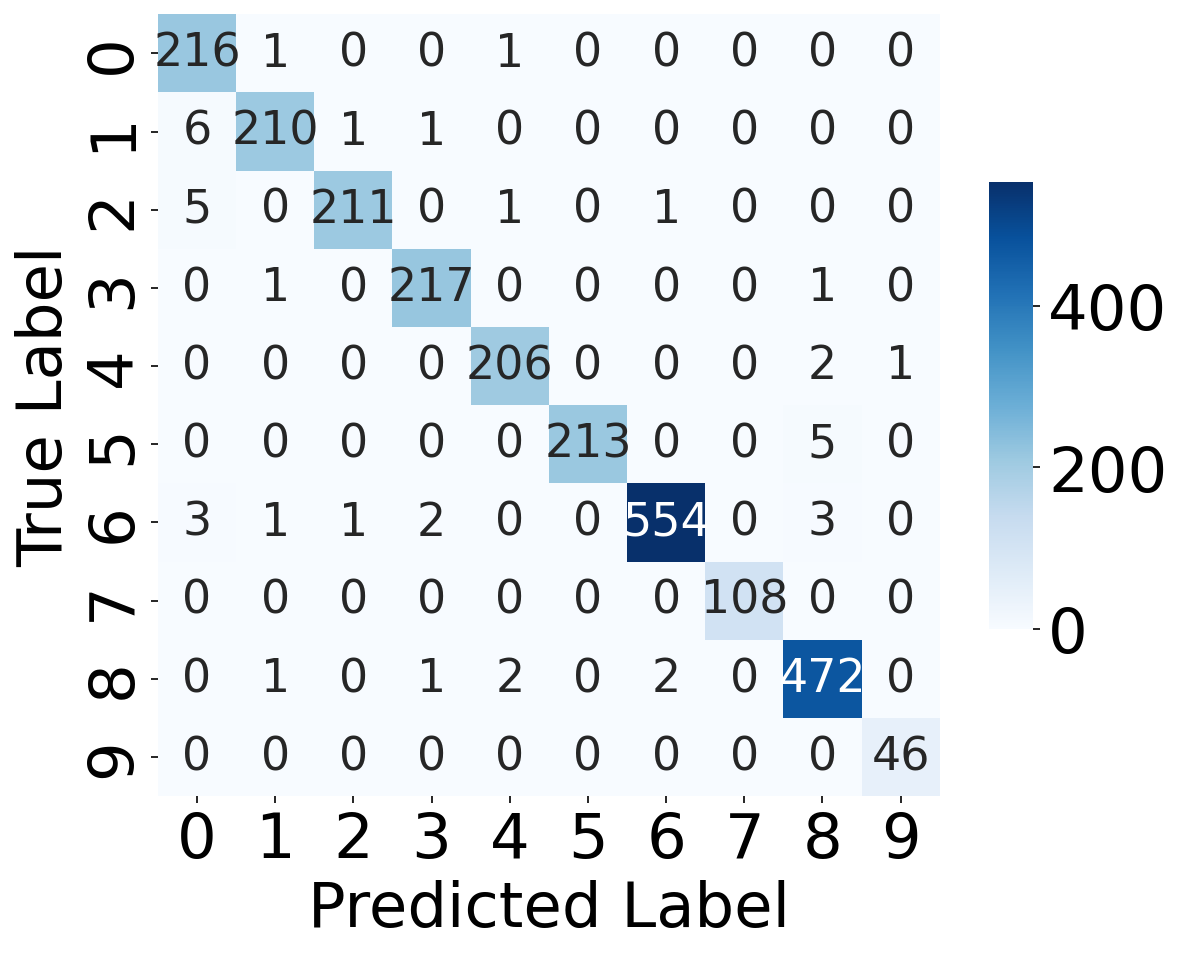

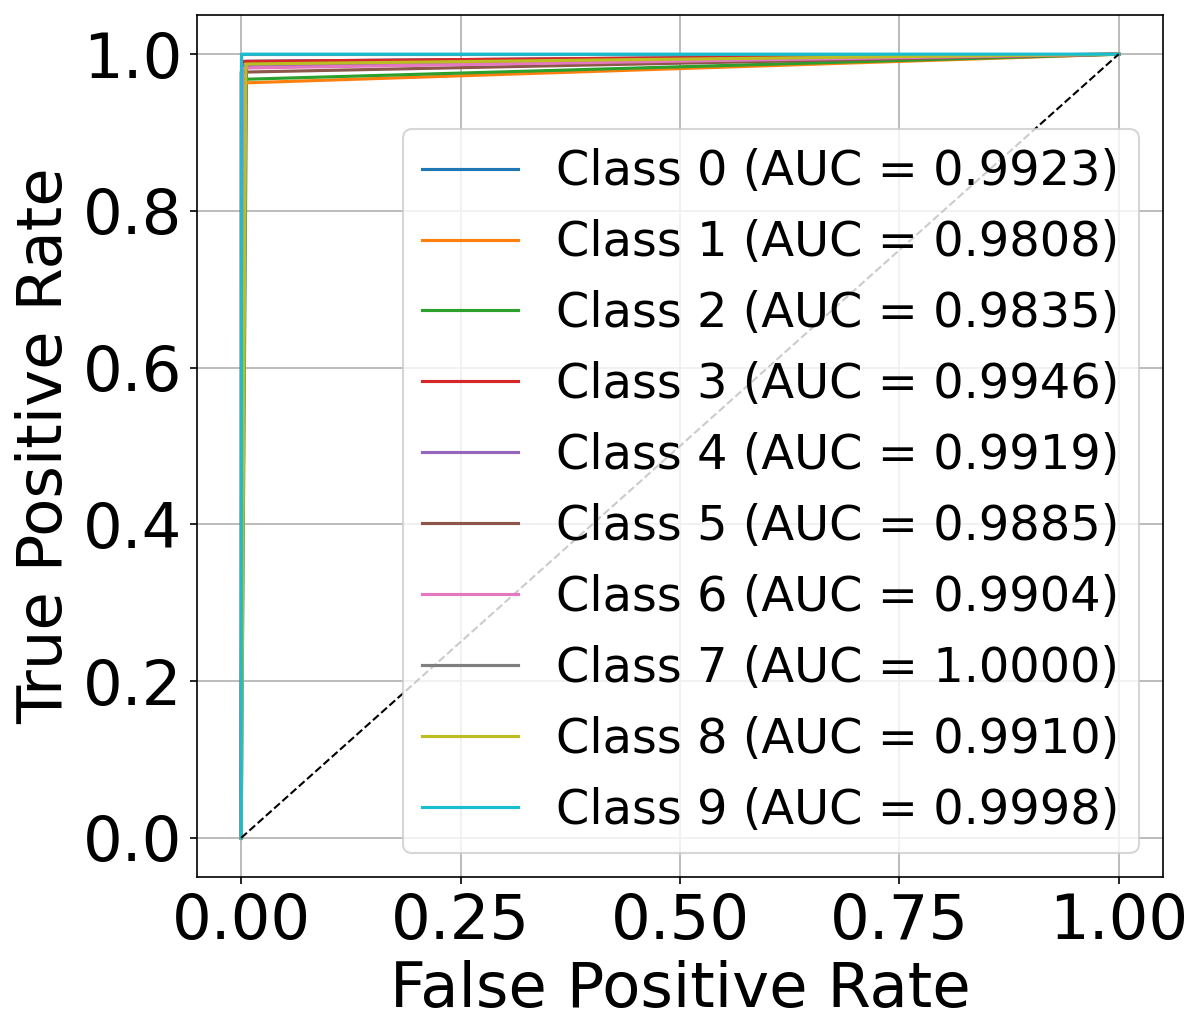

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_confusion_and_roc_separately(y_true, y_pred, num_classes=10):
    # === Binarize for ROC ===
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7), dpi=150)

    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=ax_cm,
        annot_kws={"size": 22},  # Big numbers inside heatmap cells
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )

    ax_cm.set_xlabel('Predicted Label', fontsize=30)
    ax_cm.set_ylabel('True Label', fontsize=30)
    ax_cm.tick_params(labelsize=30)

    # Adjust colorbar ticks
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)

    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    fig_roc, ax_roc = plt.subplots(figsize=(8, 7), dpi=150)

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax_roc.set_xlabel('False Positive Rate', fontsize=30)
    ax_roc.set_ylabel('True Positive Rate', fontsize=30)
    ax_roc.tick_params(labelsize=30)
    ax_roc.legend(loc='lower right', fontsize=23)
    ax_roc.grid(True)

    plt.tight_layout()
    plt.show()

plot_confusion_and_roc_separately(all_labels, all_preds, num_classes=10)


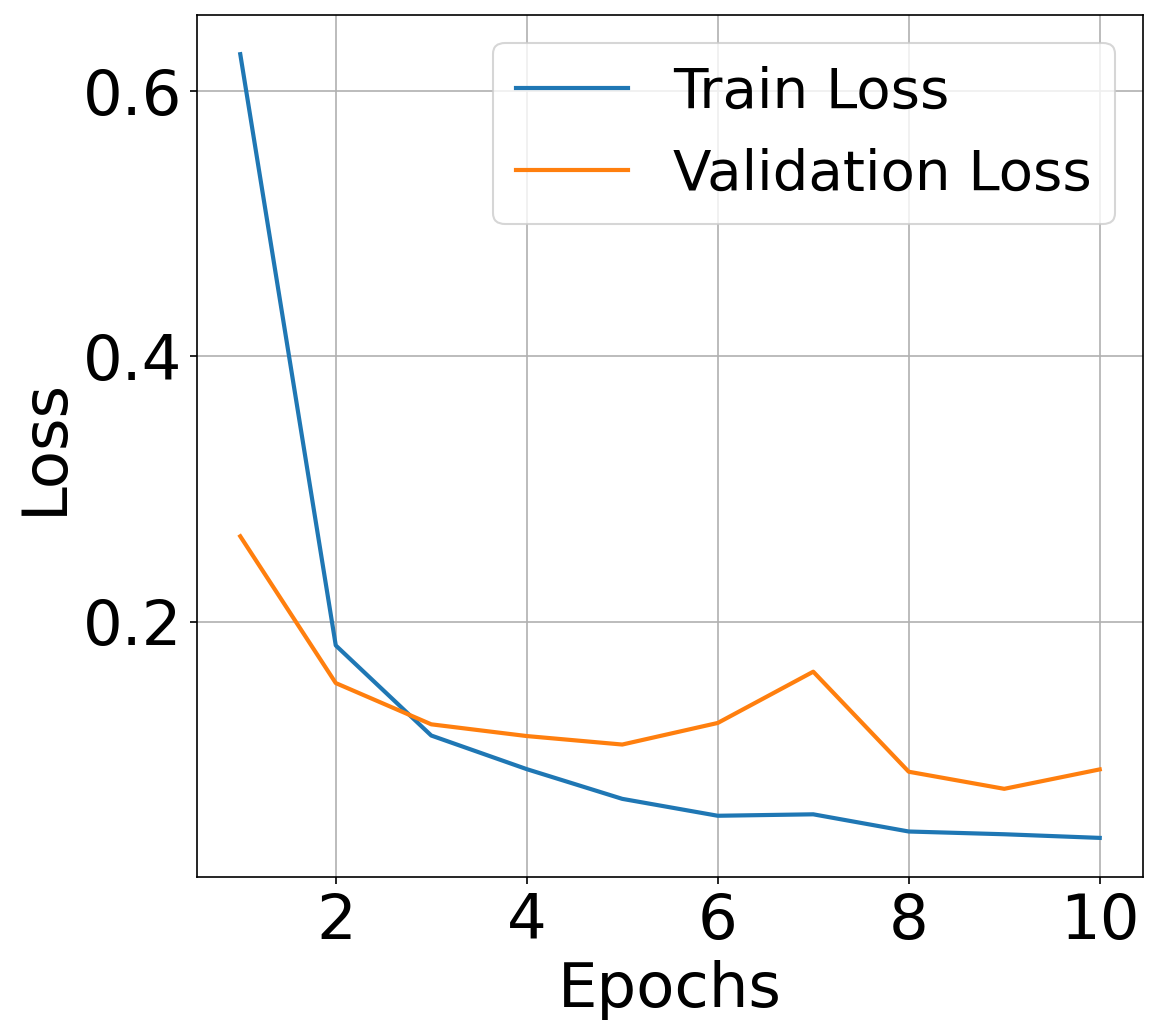

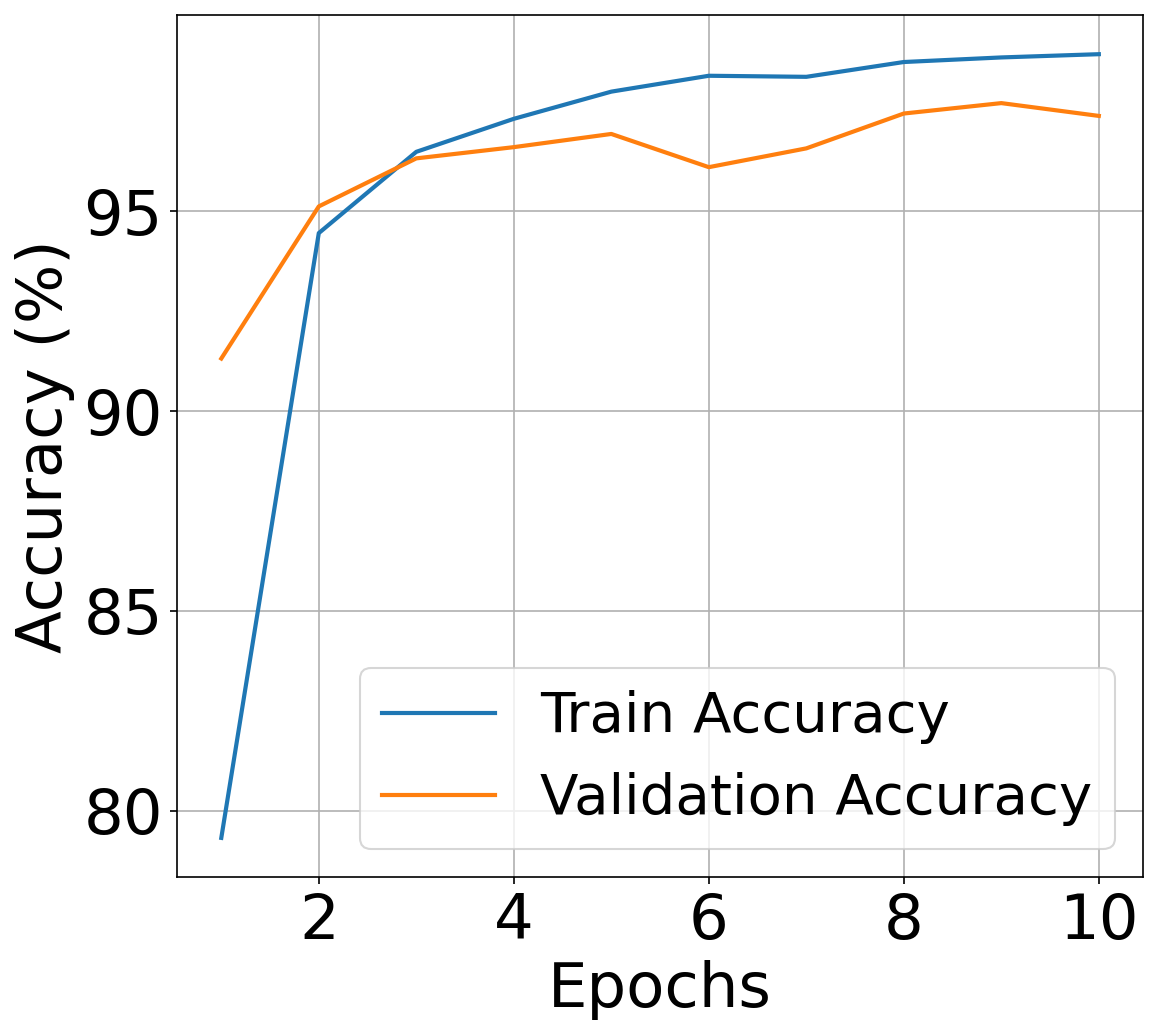

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest

def pad_and_average(metric_list, fill_value=np.nan):
    """
    Pads metric lists to the longest length using NaN and computes the mean per epoch.
    """
    padded = list(zip_longest(*metric_list, fillvalue=fill_value))
    return np.nanmean(padded, axis=1)

def plot_avg_loss_accuracy(cv_history):
    """
    Automatically plots average loss and accuracy across folds, starting from epoch 1.
    Handles folds with different epoch lengths.
    """
    avg_train_loss = pad_and_average(cv_history['train_loss'])
    avg_val_loss   = pad_and_average(cv_history['val_loss'])
    avg_train_acc  = pad_and_average(cv_history['train_acc'])
    avg_val_acc    = pad_and_average(cv_history['val_acc'])

    num_epochs = len(avg_train_loss)
    epochs = range(1, num_epochs + 1)

    # === Plot Loss ===
    fig_loss, ax_loss = plt.subplots(figsize=(8, 7), dpi=150)
    ax_loss.plot(epochs, avg_train_loss, label='Train Loss', linewidth=2)
    ax_loss.plot(epochs, avg_val_loss, label='Validation Loss', linewidth=2)
    ax_loss.set_xlabel("Epochs", fontsize=30)
    ax_loss.set_ylabel("Loss", fontsize=30)
    ax_loss.tick_params(labelsize=30)
    ax_loss.legend(fontsize=27)
    ax_loss.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    fig_acc, ax_acc = plt.subplots(figsize=(8, 7), dpi=150)
    ax_acc.plot(epochs, avg_train_acc, label='Train Accuracy', linewidth=2)
    ax_acc.plot(epochs, avg_val_acc, label='Validation Accuracy', linewidth=2)
    ax_acc.set_xlabel("Epochs", fontsize=30)
    ax_acc.set_ylabel("Accuracy (%)", fontsize=30)
    ax_acc.tick_params(labelsize=30)
    ax_acc.legend(fontsize=27)
    ax_acc.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_loss_accuracy(cv_history)



In [40]:
from sklearn.metrics import classification_report

# Step 1: Get index of best fold (highest macro F1)
best_fold_idx = summary_df['Val Macro F1'].idxmax()
best_y_true, best_y_pred, best_fold = fold_preds[best_fold_idx]

# Step 2: Print best fold number
print(f"\nBest fold is Fold {best_fold + 1}\n")

# Step 3: Print classification report
print("=== Classification Report ===")
print(classification_report(best_y_true, best_y_pred, digits=4))


Best fold is Fold 5

=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        88
           1     1.0000    0.9885    0.9942        87
           2     1.0000    1.0000    1.0000        88
           3     0.9775    1.0000    0.9886        87
           4     0.9765    1.0000    0.9881        83
           5     1.0000    1.0000    1.0000        88
           6     0.9955    0.9867    0.9911       225
           7     1.0000    1.0000    1.0000        43
           8     1.0000    0.9948    0.9974       191
           9     1.0000    1.0000    1.0000        18

    accuracy                         0.9950       998
   macro avg     0.9950    0.9970    0.9959       998
weighted avg     0.9951    0.9950    0.9950       998



In [44]:
import pandas as pd
from IPython.display import display, Markdown

# === Extract final epoch values from each fold ===
summary_table = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": [fold[-1] for fold in cv_history['train_acc']],
    "Val Accuracy (%)":   [fold[-1] for fold in cv_history['val_acc']],
    "Train Loss":         [fold[-1] for fold in cv_history['train_loss']],
    "Val Loss":           [fold[-1] for fold in cv_history['val_loss']],
    "Val Macro F1":       [fold[-1] for fold in cv_history['val_f1_macro']],
})

# === Round to 4 decimals ===
summary_table = summary_table.round(4)

# === Add average row ===
average_row = {
    "Fold": "Average",
    "Train Accuracy (%)": summary_table["Train Accuracy (%)"].mean(),
    "Val Accuracy (%)":   summary_table["Val Accuracy (%)"].mean(),
    "Train Loss":         summary_table["Train Loss"].mean(),
    "Val Loss":           summary_table["Val Loss"].mean(),
    "Val Macro F1":       summary_table["Val Macro F1"].mean(),
}
summary_table = pd.concat([summary_table, pd.DataFrame([average_row])], ignore_index=True)

# === Display in notebook ===
display(Markdown("### ✅ Per-Fold Final Epoch Summary"))
display(summary_table.style.format(precision=4))


### ✅ Per-Fold Final Epoch Summary

,Fold,Train Accuracy (%),Val Accuracy (%),Train Loss,Val Loss,Val Macro F1
0,Fold 1,98.9761,98.3984,0.0340,0.0466,0.9820
1,Fold 2,98.8314,98.8989,0.0406,0.0340,0.9906
2,Fold 3,99.2766,96.1962,0.0252,0.1378,0.9479
3,Fold 4,98.8091,93.7938,0.0405,0.2764,0.9300
4,Fold 5,98.8872,99.4990,0.0365,0.0165,0.9959
5,Fold 6,99.0207,97.4950,0.0324,0.0893,0.9764
6,Fold 7,98.6089,97.4950,0.0521,0.0608,0.9770
7,Fold 8,99.0318,96.3928,0.0344,0.1060,0.9660
8,Fold 9,98.9762,98.3968,0.0360,0.0399,0.9848
9,Fold 10,98.8872,97.2946,0.0397,0.0804,0.9709


: 

In [ ]:
# cv_history = {
#     'train_acc': [], 'val_acc': [],
#     'train_loss': [], 'val_loss': [],
#     'val_f1_macro': [], 'val_classwise_f1': []
# }

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#     print(f"\n--- Fold {fold + 1} ---")

#     # Prepare train/val data
#     X_train = [X_trainval[i] for i in train_idx]
#     y_train = [y_trainval[i] for i in train_idx]
#     X_val = [X_trainval[i] for i in val_idx]
#     y_val = [y_trainval[i] for i in val_idx]

#     # Weighted sampler
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#     sample_weights = [weight_map[y] for y in y_train]
#     sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#     # DataLoaders
#     train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
#     val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

#     # Model + optimizer
#     num_classes = 10
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     #model = get_timm_model("xception71", num_classes).to(device)
#     model = get_timm_model("tf_efficientnetv2_m.in21k_ft_in1k", num_classes).to(device)

#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


#     # Train
#     history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

#     # Save final metrics (last epoch)
#     cv_history['train_acc'].append(history['train_acc'][-1])
#     cv_history['val_acc'].append(history['val_acc'][-1])
#     cv_history['train_loss'].append(history['train_loss'][-1])
#     cv_history['val_loss'].append(history['val_loss'][-1])
#     cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
#     cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.35it/s]


Epoch 1: Train Loss=0.6122, Val Loss=0.3332, Train Acc=80.30%, Val Acc=89.29%, Val F1-Macro=0.8960


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.71it/s]


Epoch 2: Train Loss=0.1562, Val Loss=0.1461, Train Acc=95.23%, Val Acc=95.50%, Val F1-Macro=0.9578


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 3: Train Loss=0.1031, Val Loss=0.1653, Train Acc=96.79%, Val Acc=95.10%, Val F1-Macro=0.9440


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.77it/s]


Epoch 4: Train Loss=0.0649, Val Loss=0.0894, Train Acc=97.96%, Val Acc=97.30%, Val F1-Macro=0.9681


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.75it/s]


Epoch 5: Train Loss=0.0552, Val Loss=0.0789, Train Acc=98.17%, Val Acc=97.20%, Val F1-Macro=0.9693


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 6: Train Loss=0.0518, Val Loss=0.1323, Train Acc=98.46%, Val Acc=96.60%, Val F1-Macro=0.9560


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.74it/s]


Epoch 7: Train Loss=0.0441, Val Loss=0.0749, Train Acc=98.89%, Val Acc=97.30%, Val F1-Macro=0.9755


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s]


Epoch 8: Train Loss=0.0382, Val Loss=0.0508, Train Acc=98.86%, Val Acc=98.20%, Val F1-Macro=0.9841


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.60it/s]


Epoch 9: Train Loss=0.0338, Val Loss=0.0603, Train Acc=98.92%, Val Acc=98.20%, Val F1-Macro=0.9802


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.71it/s]


Epoch 10: Train Loss=0.0428, Val Loss=0.0434, Train Acc=98.81%, Val Acc=98.60%, Val F1-Macro=0.9871

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 1: Train Loss=0.6110, Val Loss=0.2517, Train Acc=80.23%, Val Acc=91.89%, Val F1-Macro=0.9269


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 2: Train Loss=0.1661, Val Loss=0.1341, Train Acc=94.92%, Val Acc=96.00%, Val F1-Macro=0.9656


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.64it/s]


Epoch 3: Train Loss=0.0999, Val Loss=0.1180, Train Acc=96.74%, Val Acc=95.70%, Val F1-Macro=0.9579


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.73it/s]


Epoch 4: Train Loss=0.0722, Val Loss=0.0844, Train Acc=97.85%, Val Acc=97.10%, Val F1-Macro=0.9684


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s]


Epoch 5: Train Loss=0.0597, Val Loss=0.0389, Train Acc=98.20%, Val Acc=98.90%, Val F1-Macro=0.9878


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 6: Train Loss=0.0605, Val Loss=0.0759, Train Acc=98.27%, Val Acc=97.40%, Val F1-Macro=0.9785


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.63it/s]


Epoch 7: Train Loss=0.0426, Val Loss=0.0872, Train Acc=98.74%, Val Acc=96.90%, Val F1-Macro=0.9682


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 8: Train Loss=0.0324, Val Loss=0.1618, Train Acc=98.94%, Val Acc=96.90%, Val F1-Macro=0.9722


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 9: Train Loss=0.0416, Val Loss=0.0676, Train Acc=98.74%, Val Acc=98.50%, Val F1-Macro=0.9845


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.63it/s]


Epoch 10: Train Loss=0.0237, Val Loss=0.0454, Train Acc=99.38%, Val Acc=98.40%, Val F1-Macro=0.9822

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.61it/s]


Epoch 1: Train Loss=0.6136, Val Loss=0.3159, Train Acc=80.10%, Val Acc=88.79%, Val F1-Macro=0.8862


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.45it/s]


Epoch 2: Train Loss=0.1535, Val Loss=0.1085, Train Acc=95.36%, Val Acc=97.00%, Val F1-Macro=0.9752


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 3: Train Loss=0.0988, Val Loss=0.1073, Train Acc=96.65%, Val Acc=96.30%, Val F1-Macro=0.9629


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 4: Train Loss=0.0757, Val Loss=0.1553, Train Acc=97.52%, Val Acc=95.10%, Val F1-Macro=0.9518


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 5: Train Loss=0.0573, Val Loss=0.0590, Train Acc=98.24%, Val Acc=98.50%, Val F1-Macro=0.9833


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.52it/s]


Epoch 6: Train Loss=0.0492, Val Loss=0.1838, Train Acc=98.54%, Val Acc=95.40%, Val F1-Macro=0.9514


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.60it/s]


Epoch 7: Train Loss=0.0446, Val Loss=0.0684, Train Acc=98.73%, Val Acc=98.20%, Val F1-Macro=0.9792


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.74it/s]


Epoch 8: Train Loss=0.0392, Val Loss=0.0550, Train Acc=98.82%, Val Acc=98.50%, Val F1-Macro=0.9855


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.54it/s]


Epoch 9: Train Loss=0.0323, Val Loss=0.0897, Train Acc=99.05%, Val Acc=97.60%, Val F1-Macro=0.9752


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 10: Train Loss=0.0398, Val Loss=0.0699, Train Acc=98.89%, Val Acc=98.00%, Val F1-Macro=0.9781

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.54it/s]


Epoch 1: Train Loss=0.6052, Val Loss=0.3223, Train Acc=80.41%, Val Acc=89.89%, Val F1-Macro=0.8985


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 2: Train Loss=0.1542, Val Loss=0.1617, Train Acc=95.23%, Val Acc=94.69%, Val F1-Macro=0.9518


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s]


Epoch 3: Train Loss=0.0934, Val Loss=0.1037, Train Acc=97.23%, Val Acc=96.30%, Val F1-Macro=0.9579


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.37it/s]


Epoch 4: Train Loss=0.0656, Val Loss=0.1412, Train Acc=98.00%, Val Acc=96.00%, Val F1-Macro=0.9622


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 5: Train Loss=0.0570, Val Loss=0.0704, Train Acc=98.24%, Val Acc=97.80%, Val F1-Macro=0.9765


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 6: Train Loss=0.0526, Val Loss=0.0989, Train Acc=98.42%, Val Acc=96.60%, Val F1-Macro=0.9655


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 7: Train Loss=0.0364, Val Loss=0.0953, Train Acc=98.99%, Val Acc=96.90%, Val F1-Macro=0.9728


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 8: Train Loss=0.0383, Val Loss=0.0732, Train Acc=98.81%, Val Acc=97.70%, Val F1-Macro=0.9746


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s]


Epoch 9: Train Loss=0.0415, Val Loss=0.1076, Train Acc=98.80%, Val Acc=97.00%, Val F1-Macro=0.9704


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.58it/s]


Epoch 10: Train Loss=0.0370, Val Loss=0.1025, Train Acc=98.92%, Val Acc=97.40%, Val F1-Macro=0.9703

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.14it/s]


Epoch 1: Train Loss=0.5961, Val Loss=0.2430, Train Acc=80.04%, Val Acc=92.89%, Val F1-Macro=0.9293


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.61it/s]


Epoch 2: Train Loss=0.1579, Val Loss=0.1414, Train Acc=95.39%, Val Acc=95.79%, Val F1-Macro=0.9604


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.75it/s]


Epoch 3: Train Loss=0.0944, Val Loss=0.1112, Train Acc=97.02%, Val Acc=97.29%, Val F1-Macro=0.9738


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 4: Train Loss=0.0766, Val Loss=0.0732, Train Acc=97.63%, Val Acc=97.60%, Val F1-Macro=0.9779


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 5: Train Loss=0.0537, Val Loss=0.0992, Train Acc=98.31%, Val Acc=97.29%, Val F1-Macro=0.9728


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.49it/s]


Epoch 6: Train Loss=0.0479, Val Loss=0.1016, Train Acc=98.52%, Val Acc=97.70%, Val F1-Macro=0.9762


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.64it/s]


Epoch 7: Train Loss=0.0520, Val Loss=0.1114, Train Acc=98.34%, Val Acc=96.49%, Val F1-Macro=0.9609


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 8: Train Loss=0.0385, Val Loss=0.0766, Train Acc=98.74%, Val Acc=98.20%, Val F1-Macro=0.9786


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 9: Train Loss=0.0356, Val Loss=0.0681, Train Acc=98.92%, Val Acc=97.80%, Val F1-Macro=0.9777


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s]


Epoch 10: Train Loss=0.0275, Val Loss=0.0516, Train Acc=99.13%, Val Acc=98.80%, Val F1-Macro=0.9863

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.53it/s]


Epoch 1: Train Loss=0.6002, Val Loss=0.2982, Train Acc=80.15%, Val Acc=90.38%, Val F1-Macro=0.9025


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.41it/s]


Epoch 2: Train Loss=0.1733, Val Loss=0.2129, Train Acc=94.51%, Val Acc=93.79%, Val F1-Macro=0.9360


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 3: Train Loss=0.0885, Val Loss=0.1290, Train Acc=97.32%, Val Acc=96.39%, Val F1-Macro=0.9612


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 4: Train Loss=0.0717, Val Loss=0.0927, Train Acc=97.80%, Val Acc=96.99%, Val F1-Macro=0.9697


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 5: Train Loss=0.0620, Val Loss=0.1250, Train Acc=98.19%, Val Acc=95.79%, Val F1-Macro=0.9574


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.72it/s]


Epoch 6: Train Loss=0.0459, Val Loss=0.1066, Train Acc=98.60%, Val Acc=96.59%, Val F1-Macro=0.9631


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.57it/s]


Epoch 7: Train Loss=0.0543, Val Loss=0.0859, Train Acc=98.46%, Val Acc=97.49%, Val F1-Macro=0.9761


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.60it/s]


Epoch 8: Train Loss=0.0260, Val Loss=0.1207, Train Acc=99.34%, Val Acc=96.29%, Val F1-Macro=0.9601


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.51it/s]


Epoch 9: Train Loss=0.0473, Val Loss=0.0636, Train Acc=98.55%, Val Acc=98.10%, Val F1-Macro=0.9753


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.59it/s]


Epoch 10: Train Loss=0.0218, Val Loss=0.0768, Train Acc=99.32%, Val Acc=97.80%, Val F1-Macro=0.9733

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.60it/s]


Epoch 1: Train Loss=0.6020, Val Loss=0.3010, Train Acc=80.71%, Val Acc=90.68%, Val F1-Macro=0.9072


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.55it/s]


Epoch 2: Train Loss=0.1666, Val Loss=0.1661, Train Acc=94.85%, Val Acc=94.59%, Val F1-Macro=0.9517


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 3: Train Loss=0.0969, Val Loss=0.0886, Train Acc=97.07%, Val Acc=96.79%, Val F1-Macro=0.9704


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.56it/s]


Epoch 4: Train Loss=0.0734, Val Loss=0.0556, Train Acc=97.80%, Val Acc=98.00%, Val F1-Macro=0.9782


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 5: Train Loss=0.0558, Val Loss=0.0758, Train Acc=98.30%, Val Acc=97.80%, Val F1-Macro=0.9791


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.86it/s]


Epoch 6: Train Loss=0.0437, Val Loss=0.0365, Train Acc=98.72%, Val Acc=98.60%, Val F1-Macro=0.9853


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.55it/s]


Epoch 7: Train Loss=0.0495, Val Loss=0.0550, Train Acc=98.61%, Val Acc=98.20%, Val F1-Macro=0.9815


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s]


Epoch 8: Train Loss=0.0476, Val Loss=0.0508, Train Acc=98.56%, Val Acc=98.40%, Val F1-Macro=0.9826


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s]


Epoch 9: Train Loss=0.0387, Val Loss=0.0910, Train Acc=98.89%, Val Acc=97.09%, Val F1-Macro=0.9701


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.58it/s]


Epoch 10: Train Loss=0.0347, Val Loss=0.0395, Train Acc=98.88%, Val Acc=98.40%, Val F1-Macro=0.9814

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.44it/s]


Epoch 1: Train Loss=0.6115, Val Loss=0.2409, Train Acc=80.45%, Val Acc=91.38%, Val F1-Macro=0.9162


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.52it/s]


Epoch 2: Train Loss=0.1567, Val Loss=0.1379, Train Acc=95.25%, Val Acc=94.59%, Val F1-Macro=0.9474


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 3: Train Loss=0.0925, Val Loss=0.1315, Train Acc=97.22%, Val Acc=95.99%, Val F1-Macro=0.9646


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.39it/s]


Epoch 4: Train Loss=0.0653, Val Loss=0.1132, Train Acc=98.03%, Val Acc=95.99%, Val F1-Macro=0.9614


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.64it/s]


Epoch 5: Train Loss=0.0614, Val Loss=0.1061, Train Acc=97.95%, Val Acc=96.59%, Val F1-Macro=0.9665


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.66it/s]


Epoch 6: Train Loss=0.0435, Val Loss=0.0693, Train Acc=98.73%, Val Acc=97.60%, Val F1-Macro=0.9772


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.72it/s]


Epoch 7: Train Loss=0.0424, Val Loss=0.0717, Train Acc=98.74%, Val Acc=97.39%, Val F1-Macro=0.9731


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.51it/s]


Epoch 8: Train Loss=0.0378, Val Loss=0.0977, Train Acc=98.95%, Val Acc=97.29%, Val F1-Macro=0.9768


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.50it/s]


Epoch 9: Train Loss=0.0430, Val Loss=0.1075, Train Acc=98.89%, Val Acc=96.89%, Val F1-Macro=0.9744


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.55it/s]


Epoch 10: Train Loss=0.0275, Val Loss=0.1154, Train Acc=99.11%, Val Acc=96.79%, Val F1-Macro=0.9623

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.46it/s]


Epoch 1: Train Loss=0.6328, Val Loss=0.2691, Train Acc=79.43%, Val Acc=90.58%, Val F1-Macro=0.9108


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.64it/s]


Epoch 2: Train Loss=0.1666, Val Loss=0.1610, Train Acc=94.95%, Val Acc=95.29%, Val F1-Macro=0.9549


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.64it/s]


Epoch 3: Train Loss=0.0946, Val Loss=0.1994, Train Acc=97.03%, Val Acc=93.29%, Val F1-Macro=0.9407


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s]


Epoch 4: Train Loss=0.0654, Val Loss=0.1157, Train Acc=97.87%, Val Acc=96.29%, Val F1-Macro=0.9651


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.46it/s]


Epoch 5: Train Loss=0.0508, Val Loss=0.1033, Train Acc=98.46%, Val Acc=96.89%, Val F1-Macro=0.9684


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.59it/s]


Epoch 6: Train Loss=0.0493, Val Loss=0.0786, Train Acc=98.58%, Val Acc=97.70%, Val F1-Macro=0.9756


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.63it/s]


Epoch 7: Train Loss=0.0492, Val Loss=0.0786, Train Acc=98.63%, Val Acc=97.60%, Val F1-Macro=0.9765


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.54it/s]


Epoch 8: Train Loss=0.0425, Val Loss=0.1628, Train Acc=98.64%, Val Acc=95.49%, Val F1-Macro=0.9584


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.26it/s]


Epoch 9: Train Loss=0.0353, Val Loss=0.0823, Train Acc=98.97%, Val Acc=97.70%, Val F1-Macro=0.9743


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.45it/s]


Epoch 10: Train Loss=0.0316, Val Loss=0.0812, Train Acc=99.01%, Val Acc=97.70%, Val F1-Macro=0.9739

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 1: Train Loss=0.6342, Val Loss=0.2059, Train Acc=79.38%, Val Acc=93.29%, Val F1-Macro=0.9415


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.43it/s]


Epoch 2: Train Loss=0.1567, Val Loss=0.1218, Train Acc=95.08%, Val Acc=96.19%, Val F1-Macro=0.9664


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s]


Epoch 3: Train Loss=0.1015, Val Loss=0.1249, Train Acc=96.71%, Val Acc=96.29%, Val F1-Macro=0.9641


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.55it/s]


Epoch 4: Train Loss=0.0663, Val Loss=0.1003, Train Acc=98.15%, Val Acc=96.69%, Val F1-Macro=0.9670


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Epoch 5: Train Loss=0.0700, Val Loss=0.1113, Train Acc=97.86%, Val Acc=96.89%, Val F1-Macro=0.9700


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.58it/s]


Epoch 6: Train Loss=0.0420, Val Loss=0.1339, Train Acc=98.86%, Val Acc=96.49%, Val F1-Macro=0.9660


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.51it/s]


Epoch 7: Train Loss=0.0511, Val Loss=0.0422, Train Acc=98.53%, Val Acc=98.50%, Val F1-Macro=0.9827


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.62it/s]


Epoch 8: Train Loss=0.0489, Val Loss=0.0820, Train Acc=98.70%, Val Acc=97.49%, Val F1-Macro=0.9769


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s]


Epoch 9: Train Loss=0.0382, Val Loss=0.0476, Train Acc=98.85%, Val Acc=98.60%, Val F1-Macro=0.9866


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.58it/s]


Epoch 10: Train Loss=0.0304, Val Loss=0.0334, Train Acc=99.12%, Val Acc=99.00%, Val F1-Macro=0.9911


In [1]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Identify the best fold using validation F1 macro
best_fold = np.argmax(cv_history['val_f1_macro'])

# Load the best model
model = get_timm_model("tf_efficientnetv2_m.in21k_ft_in1k", num_classes).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model.eval()

# Evaluate on test set
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)


NameError: name 'cv_history' is not defined

In [23]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)




=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.8091           98.5986      0.0428    0.0434   
1   Fold 2             99.3767           98.3984      0.0237    0.0454   
2   Fold 3             98.8870           97.9980      0.0398    0.0699   
3   Fold 4             98.9204           97.3974      0.0370    0.1025   
4   Fold 5             99.1320           98.7976      0.0275    0.0516   
5   Fold 6             99.3212           97.7956      0.0218    0.0768   
6   Fold 7             98.8760           98.3968      0.0347    0.0395   
7   Fold 8             99.1097           96.7936      0.0275    0.1154   
8   Fold 9             99.0096           97.6954      0.0316    0.0812   
9  Fold 10             99.1209           98.9980      0.0304    0.0334   

   Val Macro F1  
0        0.9871  
1        0.9822  
2        0.9781  
3        0.9703  
4        0.9863  
5        0.9733  
6        0.9814  
7        0.9623

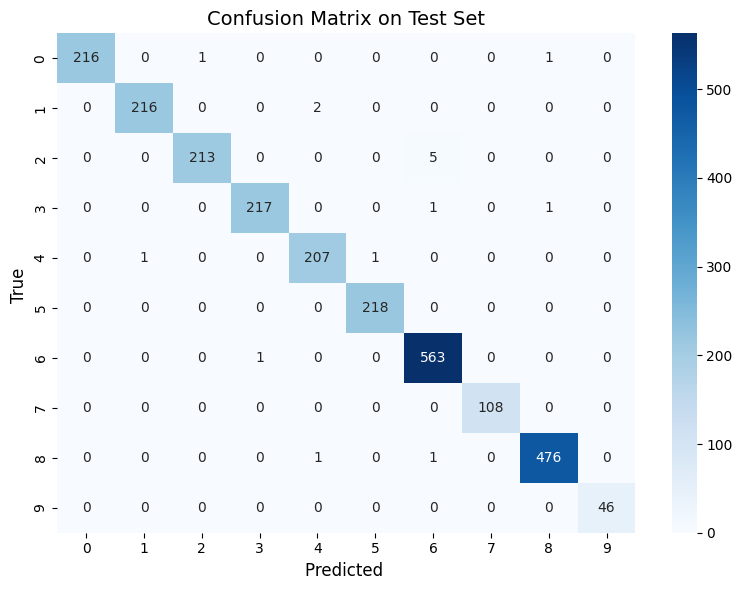

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

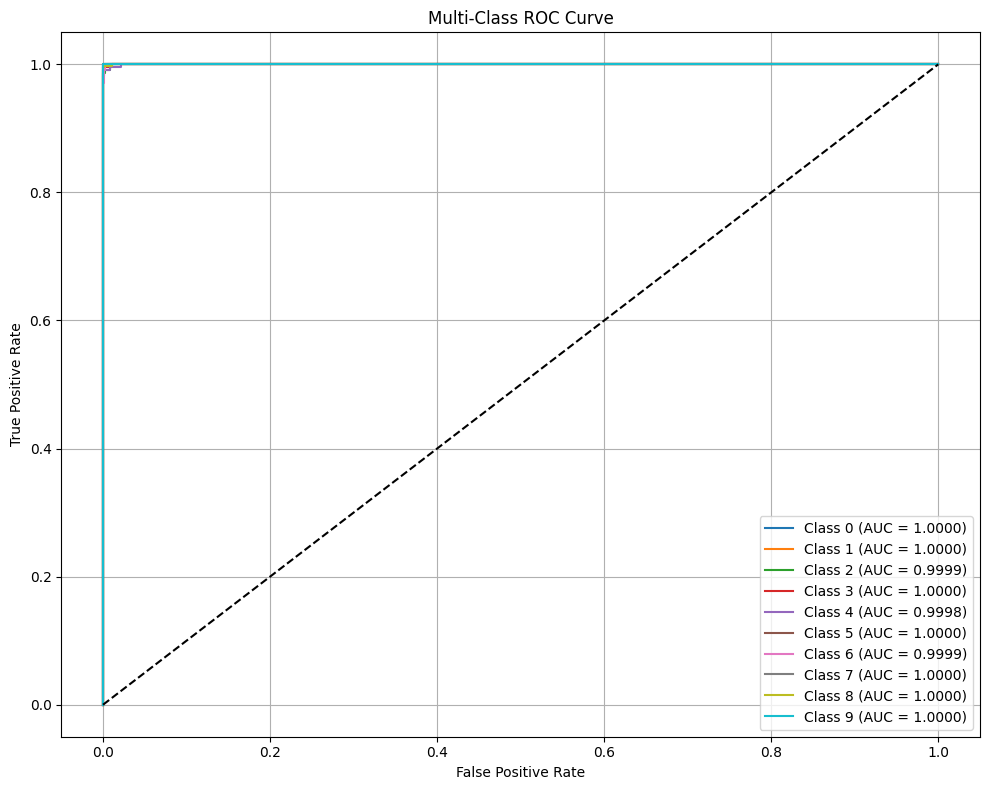

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Inception Net V3

In [19]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)

    # Replace classification head
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head') and hasattr(model.head, 'fc'):
        in_features = model.head.fc.in_features
        model.head.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [23]:
def get_inception_v3_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load pretrained Inception V3 from timm
    model = timm.create_model("inception_v3", pretrained=True, num_classes=num_classes, in_chans=3)
    
    # Resize input layer if needed (in_chans=3 already matches your input format)
    # NOTE: InceptionV3 expects input size >= 299x299. You'll need to upsample your 128x64 inputs.
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    return model, device, criterion, optimizer


In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'val_classwise_f1': []}
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            #with autocast():
            with autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #with torch.no_grad(), autocast():
            with torch.no_grad(), autocast(device_type='cuda'):

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [24]:
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders
    train_dataset = DeltaSTFTDataset(X_train, y_train, transform=transform)
    val_dataset = DeltaSTFTDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Model + optimizer
    num_classes = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = get_timm_model("xception71", num_classes).to(device)
    #model = get_timm_model("get_inception_v3_bundle", num_classes).to(device)
    model, device, criterion, optimizer = get_inception_v3_bundle(num_classes=10)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


    # Train
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Save final metrics (last epoch)
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 26.53it/s]


Epoch 1: Train Loss=0.8326, Val Loss=0.4764, Train Acc=72.10%, Val Acc=83.78%, Val F1-Macro=0.8435


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.62it/s]


Epoch 2: Train Loss=0.2717, Val Loss=0.2404, Train Acc=90.92%, Val Acc=92.19%, Val F1-Macro=0.9248


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.00it/s]


Epoch 3: Train Loss=0.1574, Val Loss=0.1511, Train Acc=95.13%, Val Acc=95.60%, Val F1-Macro=0.9506


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.01it/s]


Epoch 4: Train Loss=0.1201, Val Loss=0.1618, Train Acc=96.18%, Val Acc=95.10%, Val F1-Macro=0.9557


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.86it/s]


Epoch 5: Train Loss=0.0888, Val Loss=0.1155, Train Acc=97.15%, Val Acc=96.20%, Val F1-Macro=0.9575


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.95it/s]


Epoch 6: Train Loss=0.0909, Val Loss=0.1602, Train Acc=97.04%, Val Acc=94.99%, Val F1-Macro=0.9502


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.49it/s]


Epoch 7: Train Loss=0.0711, Val Loss=0.0907, Train Acc=97.53%, Val Acc=97.20%, Val F1-Macro=0.9716


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 30.76it/s]


Epoch 8: Train Loss=0.0622, Val Loss=0.1118, Train Acc=97.91%, Val Acc=96.00%, Val F1-Macro=0.9606


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.99it/s]


Epoch 9: Train Loss=0.0678, Val Loss=0.1848, Train Acc=97.92%, Val Acc=94.39%, Val F1-Macro=0.9525


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.98it/s]


Epoch 10: Train Loss=0.0515, Val Loss=0.0772, Train Acc=98.52%, Val Acc=97.60%, Val F1-Macro=0.9779

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.11it/s]


Epoch 1: Train Loss=0.8391, Val Loss=0.5211, Train Acc=72.02%, Val Acc=83.08%, Val F1-Macro=0.8446


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.99it/s]


Epoch 2: Train Loss=0.2773, Val Loss=0.2239, Train Acc=90.86%, Val Acc=92.69%, Val F1-Macro=0.9304


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.97it/s]


Epoch 3: Train Loss=0.1741, Val Loss=0.2140, Train Acc=94.22%, Val Acc=93.09%, Val F1-Macro=0.9335


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.79it/s]


Epoch 4: Train Loss=0.1213, Val Loss=0.2432, Train Acc=96.19%, Val Acc=91.49%, Val F1-Macro=0.9107


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 26.15it/s]


Epoch 5: Train Loss=0.1024, Val Loss=0.1333, Train Acc=96.56%, Val Acc=95.70%, Val F1-Macro=0.9548


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.10it/s]


Epoch 6: Train Loss=0.0915, Val Loss=0.2127, Train Acc=97.28%, Val Acc=93.39%, Val F1-Macro=0.9381


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.86it/s]


Epoch 7: Train Loss=0.0639, Val Loss=0.1629, Train Acc=97.92%, Val Acc=93.99%, Val F1-Macro=0.9377


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.97it/s]


Epoch 8: Train Loss=0.0637, Val Loss=0.0953, Train Acc=97.91%, Val Acc=96.50%, Val F1-Macro=0.9656


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.06it/s]


Epoch 9: Train Loss=0.0614, Val Loss=0.0450, Train Acc=98.14%, Val Acc=98.60%, Val F1-Macro=0.9855


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.04it/s]


Epoch 10: Train Loss=0.0642, Val Loss=0.0883, Train Acc=98.06%, Val Acc=96.80%, Val F1-Macro=0.9690

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.93it/s]


Epoch 1: Train Loss=0.8733, Val Loss=0.5526, Train Acc=70.54%, Val Acc=81.58%, Val F1-Macro=0.8259


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 26.21it/s]


Epoch 2: Train Loss=0.2964, Val Loss=0.2676, Train Acc=90.24%, Val Acc=91.59%, Val F1-Macro=0.9248


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.14it/s]


Epoch 3: Train Loss=0.1668, Val Loss=0.3168, Train Acc=94.35%, Val Acc=90.99%, Val F1-Macro=0.9112


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.68it/s]


Epoch 4: Train Loss=0.1300, Val Loss=0.1404, Train Acc=95.73%, Val Acc=95.60%, Val F1-Macro=0.9607


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.44it/s]


Epoch 5: Train Loss=0.0982, Val Loss=0.1168, Train Acc=96.89%, Val Acc=96.70%, Val F1-Macro=0.9704


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.68it/s]


Epoch 6: Train Loss=0.0952, Val Loss=0.1580, Train Acc=96.93%, Val Acc=95.60%, Val F1-Macro=0.9527


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.62it/s]


Epoch 7: Train Loss=0.0779, Val Loss=0.1298, Train Acc=97.36%, Val Acc=96.00%, Val F1-Macro=0.9607


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.32it/s]


Epoch 8: Train Loss=0.0585, Val Loss=0.1205, Train Acc=98.07%, Val Acc=95.80%, Val F1-Macro=0.9529


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.17it/s]


Epoch 9: Train Loss=0.0734, Val Loss=0.1108, Train Acc=97.56%, Val Acc=95.80%, Val F1-Macro=0.9559


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.77it/s]


Epoch 10: Train Loss=0.0530, Val Loss=0.1192, Train Acc=98.24%, Val Acc=94.99%, Val F1-Macro=0.9529

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.68it/s]


Epoch 1: Train Loss=0.8923, Val Loss=0.4955, Train Acc=70.22%, Val Acc=83.38%, Val F1-Macro=0.8425


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.79it/s]


Epoch 2: Train Loss=0.2747, Val Loss=0.2646, Train Acc=90.60%, Val Acc=91.09%, Val F1-Macro=0.9063


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.67it/s]


Epoch 3: Train Loss=0.1698, Val Loss=0.3529, Train Acc=94.64%, Val Acc=89.09%, Val F1-Macro=0.8742


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 28.44it/s]


Epoch 4: Train Loss=0.1240, Val Loss=0.1822, Train Acc=96.10%, Val Acc=94.49%, Val F1-Macro=0.9462


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.84it/s]


Epoch 5: Train Loss=0.1050, Val Loss=0.1202, Train Acc=96.44%, Val Acc=96.10%, Val F1-Macro=0.9631


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.93it/s]


Epoch 6: Train Loss=0.0856, Val Loss=0.2402, Train Acc=97.25%, Val Acc=93.99%, Val F1-Macro=0.9091


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.98it/s]


Epoch 7: Train Loss=0.0716, Val Loss=0.2047, Train Acc=97.87%, Val Acc=94.19%, Val F1-Macro=0.9431


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.92it/s]


Epoch 8: Train Loss=0.0654, Val Loss=0.1640, Train Acc=97.83%, Val Acc=95.30%, Val F1-Macro=0.9590


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.96it/s]


Epoch 9: Train Loss=0.0495, Val Loss=0.0630, Train Acc=98.45%, Val Acc=97.80%, Val F1-Macro=0.9787


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.95it/s]


Epoch 10: Train Loss=0.0603, Val Loss=0.1551, Train Acc=98.14%, Val Acc=95.20%, Val F1-Macro=0.9484

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 25.46it/s]


Epoch 1: Train Loss=0.8801, Val Loss=0.4365, Train Acc=70.95%, Val Acc=84.87%, Val F1-Macro=0.8506


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.80it/s]


Epoch 2: Train Loss=0.2810, Val Loss=0.2383, Train Acc=90.57%, Val Acc=92.48%, Val F1-Macro=0.9142


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.87it/s]


Epoch 3: Train Loss=0.1662, Val Loss=0.2974, Train Acc=94.49%, Val Acc=91.38%, Val F1-Macro=0.9258


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.35it/s]


Epoch 4: Train Loss=0.1207, Val Loss=0.2037, Train Acc=96.05%, Val Acc=93.99%, Val F1-Macro=0.9435


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.67it/s]


Epoch 5: Train Loss=0.0988, Val Loss=0.1407, Train Acc=96.83%, Val Acc=95.99%, Val F1-Macro=0.9608


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.73it/s]


Epoch 6: Train Loss=0.0942, Val Loss=0.2715, Train Acc=96.85%, Val Acc=91.58%, Val F1-Macro=0.9153


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.94it/s]


Epoch 7: Train Loss=0.0705, Val Loss=0.1741, Train Acc=97.79%, Val Acc=94.09%, Val F1-Macro=0.9312


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 26.52it/s]


Epoch 8: Train Loss=0.0670, Val Loss=0.1239, Train Acc=97.66%, Val Acc=96.09%, Val F1-Macro=0.9584


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 22.07it/s]


Epoch 9: Train Loss=0.0754, Val Loss=0.1245, Train Acc=97.52%, Val Acc=96.49%, Val F1-Macro=0.9691


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.84it/s]


Epoch 10: Train Loss=0.0438, Val Loss=0.1194, Train Acc=98.66%, Val Acc=96.89%, Val F1-Macro=0.9614

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.57it/s]


Epoch 1: Train Loss=0.8810, Val Loss=0.5249, Train Acc=71.09%, Val Acc=83.17%, Val F1-Macro=0.8213


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.54it/s]


Epoch 2: Train Loss=0.2729, Val Loss=0.2704, Train Acc=90.56%, Val Acc=90.18%, Val F1-Macro=0.9001


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.93it/s]


Epoch 3: Train Loss=0.1638, Val Loss=0.1596, Train Acc=94.56%, Val Acc=94.69%, Val F1-Macro=0.9413


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.86it/s]


Epoch 4: Train Loss=0.1412, Val Loss=0.1226, Train Acc=95.24%, Val Acc=96.29%, Val F1-Macro=0.9620


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 23.81it/s]


Epoch 5: Train Loss=0.0966, Val Loss=0.1735, Train Acc=96.98%, Val Acc=94.19%, Val F1-Macro=0.9391


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.97it/s]


Epoch 6: Train Loss=0.0843, Val Loss=0.1005, Train Acc=97.30%, Val Acc=96.69%, Val F1-Macro=0.9674


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.92it/s]


Epoch 7: Train Loss=0.0796, Val Loss=0.0710, Train Acc=97.57%, Val Acc=98.10%, Val F1-Macro=0.9781


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.28it/s]


Epoch 8: Train Loss=0.0668, Val Loss=0.1172, Train Acc=97.85%, Val Acc=96.99%, Val F1-Macro=0.9693


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.16it/s]


Epoch 9: Train Loss=0.0683, Val Loss=0.0627, Train Acc=97.97%, Val Acc=97.60%, Val F1-Macro=0.9749


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.79it/s]


Epoch 10: Train Loss=0.0628, Val Loss=0.1150, Train Acc=98.17%, Val Acc=96.49%, Val F1-Macro=0.9597

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.66it/s]


Epoch 1: Train Loss=0.8810, Val Loss=0.5515, Train Acc=70.67%, Val Acc=82.26%, Val F1-Macro=0.8243


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.00it/s]


Epoch 2: Train Loss=0.2880, Val Loss=0.3703, Train Acc=90.46%, Val Acc=89.18%, Val F1-Macro=0.8850


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.98it/s]


Epoch 3: Train Loss=0.1655, Val Loss=0.1973, Train Acc=94.73%, Val Acc=93.59%, Val F1-Macro=0.9331


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.79it/s]


Epoch 4: Train Loss=0.1246, Val Loss=0.1371, Train Acc=95.97%, Val Acc=96.09%, Val F1-Macro=0.9607


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.87it/s]


Epoch 5: Train Loss=0.1147, Val Loss=0.1408, Train Acc=96.44%, Val Acc=94.49%, Val F1-Macro=0.9510


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.12it/s]


Epoch 6: Train Loss=0.0846, Val Loss=0.1575, Train Acc=97.46%, Val Acc=95.09%, Val F1-Macro=0.9572


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.96it/s]


Epoch 7: Train Loss=0.0771, Val Loss=0.1027, Train Acc=97.54%, Val Acc=96.29%, Val F1-Macro=0.9603


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.90it/s]


Epoch 8: Train Loss=0.0670, Val Loss=0.1177, Train Acc=97.91%, Val Acc=96.39%, Val F1-Macro=0.9617


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 42.11it/s]


Epoch 9: Train Loss=0.0707, Val Loss=0.1540, Train Acc=97.86%, Val Acc=95.09%, Val F1-Macro=0.9526


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.62it/s]


Epoch 10: Train Loss=0.0622, Val Loss=0.0921, Train Acc=97.95%, Val Acc=97.09%, Val F1-Macro=0.9672

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.84it/s]


Epoch 1: Train Loss=0.8577, Val Loss=0.6063, Train Acc=71.93%, Val Acc=79.16%, Val F1-Macro=0.8170


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.93it/s]


Epoch 2: Train Loss=0.2659, Val Loss=0.2849, Train Acc=91.12%, Val Acc=91.48%, Val F1-Macro=0.9173


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.85it/s]


Epoch 3: Train Loss=0.1682, Val Loss=0.2174, Train Acc=94.46%, Val Acc=93.59%, Val F1-Macro=0.9376


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.05it/s]


Epoch 4: Train Loss=0.1123, Val Loss=0.2945, Train Acc=96.29%, Val Acc=91.88%, Val F1-Macro=0.9205


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.27it/s]


Epoch 5: Train Loss=0.1114, Val Loss=0.2794, Train Acc=96.25%, Val Acc=92.59%, Val F1-Macro=0.9323


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.11it/s]


Epoch 6: Train Loss=0.0805, Val Loss=0.1373, Train Acc=97.50%, Val Acc=96.39%, Val F1-Macro=0.9686


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.87it/s]


Epoch 7: Train Loss=0.0699, Val Loss=0.2422, Train Acc=97.82%, Val Acc=94.09%, Val F1-Macro=0.9441


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 39.99it/s]


Epoch 8: Train Loss=0.0743, Val Loss=0.1442, Train Acc=97.50%, Val Acc=95.89%, Val F1-Macro=0.9652


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.52it/s]


Epoch 9: Train Loss=0.0609, Val Loss=0.1556, Train Acc=98.07%, Val Acc=96.79%, Val F1-Macro=0.9722


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.05it/s]


Epoch 10: Train Loss=0.0413, Val Loss=0.1591, Train Acc=98.63%, Val Acc=95.29%, Val F1-Macro=0.9552

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.22it/s]


Epoch 1: Train Loss=0.8685, Val Loss=0.6027, Train Acc=70.80%, Val Acc=81.36%, Val F1-Macro=0.8321


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 42.21it/s]


Epoch 2: Train Loss=0.2764, Val Loss=0.2143, Train Acc=91.05%, Val Acc=92.38%, Val F1-Macro=0.9272


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.45it/s]


Epoch 3: Train Loss=0.1740, Val Loss=0.2239, Train Acc=94.81%, Val Acc=92.69%, Val F1-Macro=0.9360


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.24it/s]


Epoch 4: Train Loss=0.1173, Val Loss=0.1398, Train Acc=95.90%, Val Acc=95.79%, Val F1-Macro=0.9590


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 39.00it/s]


Epoch 5: Train Loss=0.1140, Val Loss=0.1826, Train Acc=96.33%, Val Acc=95.79%, Val F1-Macro=0.9559


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.85it/s]


Epoch 6: Train Loss=0.0773, Val Loss=0.1567, Train Acc=97.54%, Val Acc=95.39%, Val F1-Macro=0.9540


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.23it/s]


Epoch 7: Train Loss=0.0773, Val Loss=0.1270, Train Acc=97.56%, Val Acc=96.39%, Val F1-Macro=0.9651


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.11it/s]


Epoch 8: Train Loss=0.0699, Val Loss=0.1648, Train Acc=97.66%, Val Acc=95.79%, Val F1-Macro=0.9516


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.94it/s]


Epoch 9: Train Loss=0.0714, Val Loss=0.0787, Train Acc=97.62%, Val Acc=97.49%, Val F1-Macro=0.9723


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.37it/s]


Epoch 10: Train Loss=0.0522, Val Loss=0.0944, Train Acc=98.32%, Val Acc=97.49%, Val F1-Macro=0.9721

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 41.00it/s]


Epoch 1: Train Loss=0.8974, Val Loss=0.5402, Train Acc=70.47%, Val Acc=81.46%, Val F1-Macro=0.8364


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 2: Train Loss=0.2690, Val Loss=0.2459, Train Acc=90.83%, Val Acc=91.58%, Val F1-Macro=0.9255


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.90it/s]


Epoch 3: Train Loss=0.1679, Val Loss=0.1501, Train Acc=94.42%, Val Acc=94.99%, Val F1-Macro=0.9503


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.62it/s]


Epoch 4: Train Loss=0.1183, Val Loss=0.1922, Train Acc=96.13%, Val Acc=93.99%, Val F1-Macro=0.9470


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 42.15it/s]


Epoch 5: Train Loss=0.1040, Val Loss=0.1238, Train Acc=96.74%, Val Acc=96.39%, Val F1-Macro=0.9633


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.84it/s]


Epoch 6: Train Loss=0.0881, Val Loss=0.1380, Train Acc=97.21%, Val Acc=95.19%, Val F1-Macro=0.9530


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.63it/s]


Epoch 7: Train Loss=0.0735, Val Loss=0.1005, Train Acc=97.60%, Val Acc=97.09%, Val F1-Macro=0.9725


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.74it/s]


Epoch 8: Train Loss=0.0852, Val Loss=0.0995, Train Acc=97.48%, Val Acc=96.89%, Val F1-Macro=0.9711


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.92it/s]


Epoch 9: Train Loss=0.0585, Val Loss=0.1537, Train Acc=98.12%, Val Acc=95.29%, Val F1-Macro=0.9527


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 40.48it/s]


Epoch 10: Train Loss=0.0552, Val Loss=0.0910, Train Acc=98.19%, Val Acc=97.49%, Val F1-Macro=0.9738



=== Final Test Set Evaluation ===
Accuracy       : 0.9792
Macro F1-score : 0.9789

Classification Report:
               precision    recall  f1-score   support

           0     0.9435    0.9954    0.9688       218
           1     0.9771    0.9771    0.9771       218
           2     0.9676    0.9587    0.9631       218
           3     1.0000    0.9909    0.9954       219
           4     0.9624    0.9809    0.9716       209
           5     0.9520    1.0000    0.9754       218
           6     0.9908    0.9557    0.9729       564
           7     0.9903    0.9444    0.9668       108
           8     0.9958    1.0000    0.9979       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9792      2496
   macro avg     0.9779    0.9803    0.9789      2496
weighted avg     0.9796    0.9792    0.9792      2496



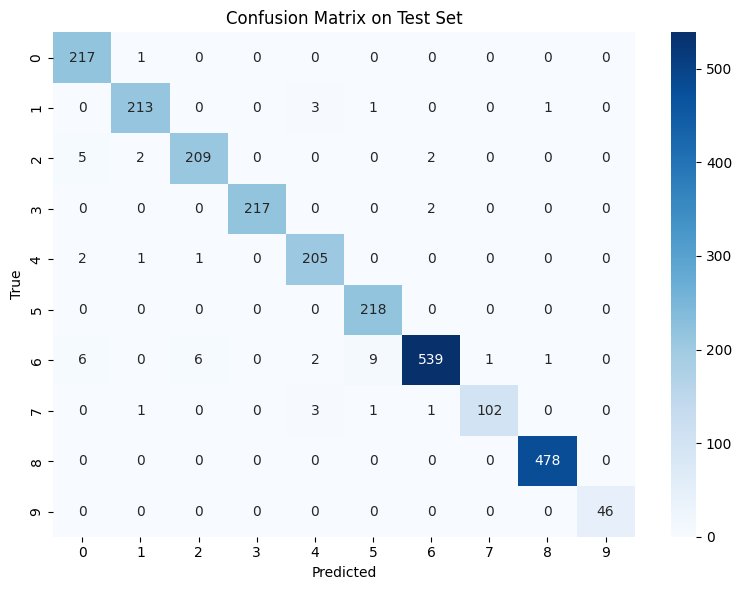

In [26]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import torch

# Identify best fold by macro F1-score
best_fold = np.argmax(cv_history['val_f1_macro'])

# === Reload the best model ===
model, device, _, _ = get_inception_v3_bundle(num_classes=10)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth", map_location=device))
model.eval()

# === Evaluate on Test Set ===
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# === Compute Evaluation Metrics ===
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)

# Optional: Save report to CSV
import pandas as pd
report_df = pd.DataFrame(classification_report(all_labels, all_preds, output_dict=True)).transpose()
report_df.to_csv("final_test_classification_report.csv")

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.5198           97.5976      0.0515    0.0772   
1   Fold 2             98.0634           96.7968      0.0642    0.0883   
2   Fold 3             98.2415           94.9950      0.0530    0.1192   
3   Fold 4             98.1413           95.1952      0.0603    0.1551   
4   Fold 5             98.6646           96.8938      0.0438    0.1194   
5   Fold 6             98.1749           96.4930      0.0628    0.1150   
6   Fold 7             97.9524           97.0942      0.0622    0.0921   
7   Fold 8             98.6312           95.2906      0.0413    0.1591   
8   Fold 9             98.3196           97.4950      0.0522    0.0944   
9  Fold 10             98.1861           97.4950      0.0552    0.0910   

   Val Macro F1  
0        0.9779  
1        0.9690  
2        0.9529  
3        0.9484  
4        0.9614  
5        0.9597  
6        0.9672  
7        0.9552

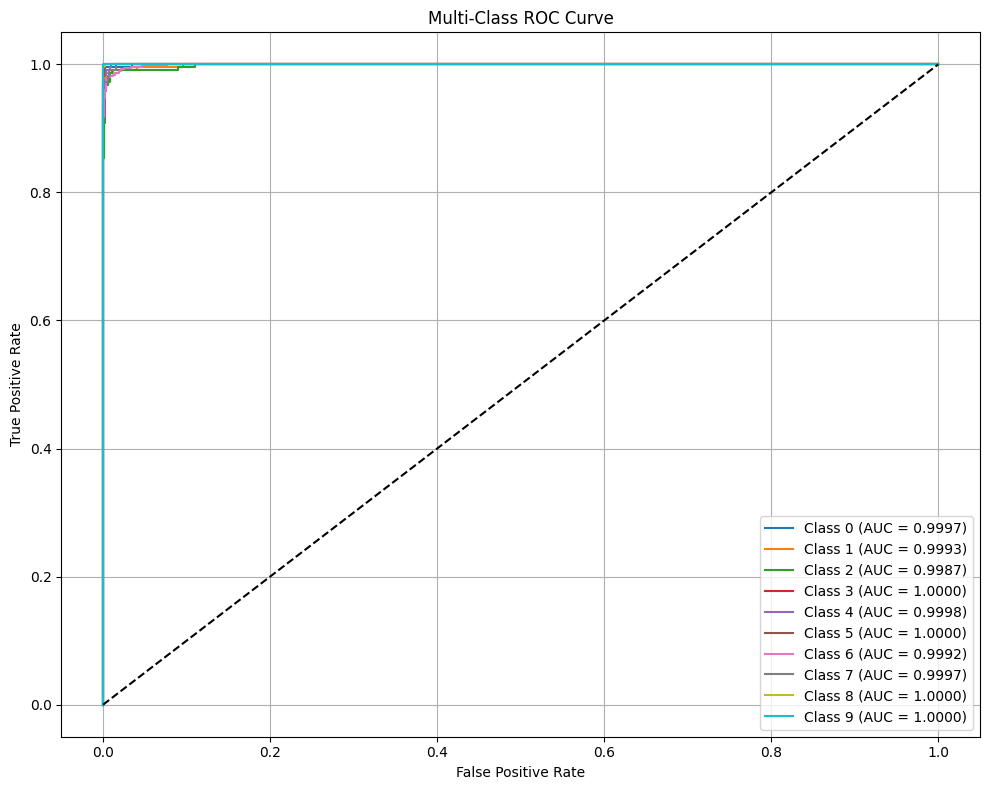

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Identify the best fold using validation F1 macro
best_fold = np.argmax(cv_history['val_f1_macro'])

# Load the best model
model = get_timm_model("get_inception_v3_bundle", num_classes).to(device)
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model.eval()

# Evaluate on test set
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)


RuntimeError: Unknown model (get_inception_v3_bundle)